# Analysis of RAS saturation mutagenesis data

In the following we compare predictions from Rhapsody, PolyPhen-2, EVmutation on RAS variants presented in:
[Bandaru P et al, *Deconstruction of the Ras switching cycle through saturation mutagenesis*, Elife (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5538825/)

In [1]:
import sys, os, pickle, csv, glob
import numpy as np

In [2]:
# Insert here local path to Rhapsody folder
sys.path.insert(0, '../../rhapsody/')

## Re-training of unbiased classifier

A few RAS mutations are found in the Integrated Dataset used for training. In order to get completely unbiased predictions, we will retrain a classifier by excluding those variants from the training dataset.

**NB:** The Uniprot names for gene HRAS are `P01112` or `RASH_HUMAN`.

In [3]:
from rhapsody import *

In [4]:
ID = pickle.load(open('../RF_training/Integrated_Dataset.pkl', 'rb'))

ID_del = ID[ID['true_label']==1]
ID_neu = ID[ID['true_label']==0]

known_del_SAVs = [SAV['SAV_coords'] for SAV in ID_del if SAV['SAV_coords'].startswith('P01112')]
known_neu_SAVs = [SAV['SAV_coords'] for SAV in ID_neu if SAV['SAV_coords'].startswith('P01112')]

print(f'{len(known_del_SAVs)} known deleterious RAS SAVs:')
print(known_del_SAVs)
print(f'\n{len(known_neu_SAVs)} known neutral RAS SAVs:')
print(known_neu_SAVs)

17 known deleterious RAS SAVs:
['P01112 146 A V', 'P01112 146 A T', 'P01112 117 K R', 'P01112 63 E K', 'P01112 58 T I', 'P01112 22 Q K', 'P01112 13 G D', 'P01112 13 G C', 'P01112 12 G A', 'P01112 12 G C', 'P01112 61 Q K', 'P01112 12 G D', 'P01112 61 Q L', 'P01112 12 G V', 'P01112 12 G S', 'P01112 12 G E', 'P01112 13 G R']

0 known neutral RAS SAVs:
[]


Let's exclude these variants from the dataset. We will also only consider variants with associated PDB structures larger than 150 residues, which we found to improve prediction accuracy. 

In [5]:
ID_subset = ID[ [i for i,SAV in enumerate(ID) if not SAV['SAV_coords'].startswith('P01112') 
                                                 and SAV['PDB_length']>=150] ]
len(ID_subset)

23370

In [6]:
# complete set of Rhapsody features
full_clsf_featset = ['SAV_coords', 'true_label', 
                     'wt_PSIC', 'Delta_PSIC', 'SASA', 'ANM_MSF-chain', 
                     'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                     'stiffness-chain', 'entropy', 'ranked_MI', 'BLOSUM']
# reduced set of Rhapsody features (without features computed on Pfam domains)
redx_clsf_featset = [f for f in full_clsf_featset if f not in ['entropy', 'ranked_MI']]

In [7]:
if not os.path.isdir('results'):
    os.mkdir('results/')

In [8]:
# training of full classifier
if os.path.isdir('results/full_clsf'):
    print('full classifier already trained')
else:
    os.mkdir('results/full_clsf')
    full_clsf = trainRFclassifier(ID_subset[full_clsf_featset])
    for file in glob.glob('*png') + ['trained_classifier.pkl',]:
        os.rename(file, os.path.join('results/full_clsf', file))

@> 4587 out of 23370 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.854   OOB score = 0.822
@> CV iteration # 2:    ROC-AUC = 0.855   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.835   OOB score = 0.826
@> CV iteration # 4:    ROC-AUC = 0.864   OOB score = 0.822
@> CV iteration # 5:    ROC-AUC = 0.840   OOB score = 0.825
@> CV iteration # 6:    ROC-AUC = 0.866   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.872   OOB score = 0.822
@> CV iteration # 8:    ROC-AUC = 0.849   OOB score = 0.822
@> CV iteration # 9:    ROC-AUC = 0.847   OOB score = 0.824
@> CV iteration #10:    ROC-AUC = 0.840   OOB score = 0.826
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   18783
@> fraction of positives:   0.731
@> mean ROC-AUC:            0.852
@> mean OOB score:          0.823
@> optimal cutoff*:         0.745 +/- 0.024
@> (* argmax of Youden's index)
@> feature importances:
@>           

In [9]:
# training of reduced classifier
if os.path.isdir('results/redx_clsf'):
    print('reduced classifier already trained')
else:
    os.mkdir('results/redx_clsf')
    redx_clsf = trainRFclassifier(ID_subset[redx_clsf_featset])
    for file in glob.glob('*png') + ['trained_classifier.pkl',]:
        os.rename(file, os.path.join('results/redx_clsf', file))

@> 207 out of 23370 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.849   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.807
@> CV iteration # 3:    ROC-AUC = 0.834   OOB score = 0.808
@> CV iteration # 4:    ROC-AUC = 0.837   OOB score = 0.808
@> CV iteration # 5:    ROC-AUC = 0.824   OOB score = 0.810
@> CV iteration # 6:    ROC-AUC = 0.839   OOB score = 0.809
@> CV iteration # 7:    ROC-AUC = 0.843   OOB score = 0.807
@> CV iteration # 8:    ROC-AUC = 0.827   OOB score = 0.808
@> CV iteration # 9:    ROC-AUC = 0.850   OOB score = 0.808
@> CV iteration #10:    ROC-AUC = 0.836   OOB score = 0.809
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23163
@> fraction of positives:   0.711
@> mean ROC-AUC:            0.837
@> mean OOB score:          0.808
@> optimal cutoff*:         0.728 +/- 0.026
@> (* argmax of Youden's index)
@> feature importances:
@>            

## Rhapsody predictions
We will perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis).

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2`

In [10]:
if os.path.isdir('results/predictions'):
    print('predictions already precomputed')
    rh = pickle.load(open('results/predictions/rhapsody-pickle.pkl', 'rb'))
else:
    os.mkdir('results/predictions')
    # run rhapsody
    rh = rhapsody('data/pph2/pph2-full.txt', 'results/full_clsf/trained_classifier.pkl',
                  aux_classifier='results/redx_clsf/trained_classifier.pkl', input_type='PP2')
    # store files
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join('results/predictions', f))

@> Logging into file: rhapsody-log.txt
@> Logging started at 2019-02-15 17:35:13.583377
@> Imported feature set: 'wt_PSIC'
@>                       'Delta_PSIC'
@>                       'SASA'
@>                       'ANM_MSF-chain'
@>                       'ANM_effectiveness-chain'
@>                       'ANM_sensitivity-chain'
@>                       'stiffness-chain'
@>                       'entropy'
@>                       'ranked_MI'
@>                       'BLOSUM'
@> PolyPhen-2's output parsed.
@> Sequence-conservation features have been retrieved from PolyPhen-2's output.
@> Mapping SAVs to PDB structures...
@> [1/3591] Mapping SAV 'P01112 1 M A' to PDB...
@> Pickle 'UniprotMap-P01112.pkl' recovered.
@> [2/3591] Mapping SAV 'P01112 126 E P' to PDB...
@> [3/3591] Mapping SAV 'P01112 126 E Q' to PDB...
@> [4/3591] Mapping SAV 'P01112 126 E R' to PDB...
@> [5/3591] Mapping SAV 'P01112 126 E S' to PDB...
@> [6/3591] Mapping SAV 'P01112 126 E T' to PDB...
@> [7/3591] Mapping 

@> [145/3591] Mapping SAV 'P01112 119 D K' to PDB...
@> [146/3591] Mapping SAV 'P01112 119 D L' to PDB...
@> [147/3591] Mapping SAV 'P01112 119 D M' to PDB...
@> [148/3591] Mapping SAV 'P01112 119 D N' to PDB...
@> [149/3591] Mapping SAV 'P01112 119 D P' to PDB...
@> [150/3591] Mapping SAV 'P01112 119 D Q' to PDB...
@> [151/3591] Mapping SAV 'P01112 119 D R' to PDB...
@> [152/3591] Mapping SAV 'P01112 119 D S' to PDB...
@> [153/3591] Mapping SAV 'P01112 120 L N' to PDB...
@> [154/3591] Mapping SAV 'P01112 119 D T' to PDB...
@> [155/3591] Mapping SAV 'P01112 119 D W' to PDB...
@> [156/3591] Mapping SAV 'P01112 119 D Y' to PDB...
@> [157/3591] Mapping SAV 'P01112 120 L A' to PDB...
@> [158/3591] Mapping SAV 'P01112 120 L C' to PDB...
@> [159/3591] Mapping SAV 'P01112 120 L D' to PDB...
@> [160/3591] Mapping SAV 'P01112 120 L E' to PDB...
@> [161/3591] Mapping SAV 'P01112 120 L F' to PDB...
@> [162/3591] Mapping SAV 'P01112 120 L G' to PDB...
@> [163/3591] Mapping SAV 'P01112 120 L H' to 

@> [300/3591] Mapping SAV 'P01112 142 I H' to PDB...
@> [301/3591] Mapping SAV 'P01112 142 I K' to PDB...
@> [302/3591] Mapping SAV 'P01112 142 I L' to PDB...
@> [303/3591] Mapping SAV 'P01112 142 I M' to PDB...
@> [304/3591] Mapping SAV 'P01112 142 I N' to PDB...
@> [305/3591] Mapping SAV 'P01112 142 I P' to PDB...
@> [306/3591] Mapping SAV 'P01112 142 I A' to PDB...
@> [307/3591] Mapping SAV 'P01112 139 I T' to PDB...
@> [308/3591] Mapping SAV 'P01112 141 Y G' to PDB...
@> [309/3591] Mapping SAV 'P01112 141 Y E' to PDB...
@> [310/3591] Mapping SAV 'P01112 139 I W' to PDB...
@> [311/3591] Mapping SAV 'P01112 139 I Y' to PDB...
@> [312/3591] Mapping SAV 'P01112 140 P A' to PDB...
@> [313/3591] Mapping SAV 'P01112 140 P C' to PDB...
@> [314/3591] Mapping SAV 'P01112 140 P D' to PDB...
@> [315/3591] Mapping SAV 'P01112 140 P E' to PDB...
@> [316/3591] Mapping SAV 'P01112 140 P F' to PDB...
@> [317/3591] Mapping SAV 'P01112 140 P G' to PDB...
@> [318/3591] Mapping SAV 'P01112 140 P H' to 

@> [455/3591] Mapping SAV 'P01112 103 V E' to PDB...
@> [456/3591] Mapping SAV 'P01112 103 V F' to PDB...
@> [457/3591] Mapping SAV 'P01112 103 V G' to PDB...
@> [458/3591] Mapping SAV 'P01112 103 V H' to PDB...
@> [459/3591] Mapping SAV 'P01112 103 V I' to PDB...
@> [460/3591] Mapping SAV 'P01112 103 V K' to PDB...
@> [461/3591] Mapping SAV 'P01112 103 V L' to PDB...
@> [462/3591] Mapping SAV 'P01112 102 R W' to PDB...
@> [463/3591] Mapping SAV 'P01112 103 V M' to PDB...
@> [464/3591] Mapping SAV 'P01112 103 V P' to PDB...
@> [465/3591] Mapping SAV 'P01112 103 V Q' to PDB...
@> [466/3591] Mapping SAV 'P01112 103 V R' to PDB...
@> [467/3591] Mapping SAV 'P01112 103 V S' to PDB...
@> [468/3591] Mapping SAV 'P01112 103 V T' to PDB...
@> [469/3591] Mapping SAV 'P01112 103 V W' to PDB...
@> [470/3591] Mapping SAV 'P01112 103 V Y' to PDB...
@> [471/3591] Mapping SAV 'P01112 104 K A' to PDB...
@> [472/3591] Mapping SAV 'P01112 104 K C' to PDB...
@> [473/3591] Mapping SAV 'P01112 104 K D' to 

@> [611/3591] Mapping SAV 'P01112 96 Y P' to PDB...
@> [612/3591] Mapping SAV 'P01112 96 Y Q' to PDB...
@> [613/3591] Mapping SAV 'P01112 96 Y R' to PDB...
@> [614/3591] Mapping SAV 'P01112 96 Y S' to PDB...
@> [615/3591] Mapping SAV 'P01112 96 Y F' to PDB...
@> [616/3591] Mapping SAV 'P01112 101 K H' to PDB...
@> [617/3591] Mapping SAV 'P01112 98 E K' to PDB...
@> [618/3591] Mapping SAV 'P01112 98 E M' to PDB...
@> [619/3591] Mapping SAV 'P01112 100 I A' to PDB...
@> [620/3591] Mapping SAV 'P01112 100 I C' to PDB...
@> [621/3591] Mapping SAV 'P01112 100 I D' to PDB...
@> [622/3591] Mapping SAV 'P01112 100 I E' to PDB...
@> [623/3591] Mapping SAV 'P01112 100 I F' to PDB...
@> [624/3591] Mapping SAV 'P01112 100 I G' to PDB...
@> [625/3591] Mapping SAV 'P01112 100 I H' to PDB...
@> [626/3591] Mapping SAV 'P01112 100 I K' to PDB...
@> [627/3591] Mapping SAV 'P01112 100 I L' to PDB...
@> [628/3591] Mapping SAV 'P01112 100 I M' to PDB...
@> [629/3591] Mapping SAV 'P01112 100 I N' to PDB...


@> [767/3591] Mapping SAV 'P01112 116 N R' to PDB...
@> [768/3591] Mapping SAV 'P01112 116 N S' to PDB...
@> [769/3591] Mapping SAV 'P01112 116 N T' to PDB...
@> [770/3591] Mapping SAV 'P01112 117 K P' to PDB...
@> [771/3591] Mapping SAV 'P01112 116 N V' to PDB...
@> [772/3591] Mapping SAV 'P01112 116 N Y' to PDB...
@> [773/3591] Mapping SAV 'P01112 117 K A' to PDB...
@> [774/3591] Mapping SAV 'P01112 117 K C' to PDB...
@> [775/3591] Mapping SAV 'P01112 117 K D' to PDB...
@> [776/3591] Mapping SAV 'P01112 117 K E' to PDB...
@> [777/3591] Mapping SAV 'P01112 117 K F' to PDB...
@> [778/3591] Mapping SAV 'P01112 117 K G' to PDB...
@> [779/3591] Mapping SAV 'P01112 117 K H' to PDB...
@> [780/3591] Mapping SAV 'P01112 117 K I' to PDB...
@> [781/3591] Mapping SAV 'P01112 117 K L' to PDB...
@> [782/3591] Mapping SAV 'P01112 117 K M' to PDB...
@> [783/3591] Mapping SAV 'P01112 116 N W' to PDB...
@> [784/3591] Mapping SAV 'P01112 113 L F' to PDB...
@> [785/3591] Mapping SAV 'P01112 113 L E' to 

@> [922/3591] Mapping SAV 'P01112 175 D A' to PDB...
@> [923/3591] Mapping SAV 'P01112 175 D C' to PDB...
@> [924/3591] Mapping SAV 'P01112 174 P L' to PDB...
@> [925/3591] Mapping SAV 'P01112 175 D E' to PDB...
@> [926/3591] Mapping SAV 'P01112 173 P S' to PDB...
@> [927/3591] Mapping SAV 'P01112 173 P Q' to PDB...
@> [928/3591] Mapping SAV 'P01112 172 N I' to PDB...
@> [929/3591] Mapping SAV 'P01112 172 N K' to PDB...
@> [930/3591] Mapping SAV 'P01112 172 N L' to PDB...
@> [931/3591] Mapping SAV 'P01112 172 N M' to PDB...
@> [932/3591] Mapping SAV 'P01112 172 N P' to PDB...
@> [933/3591] Mapping SAV 'P01112 172 N Q' to PDB...
@> [934/3591] Mapping SAV 'P01112 172 N R' to PDB...
@> [935/3591] Mapping SAV 'P01112 172 N S' to PDB...
@> [936/3591] Mapping SAV 'P01112 172 N T' to PDB...
@> [937/3591] Mapping SAV 'P01112 172 N V' to PDB...
@> [938/3591] Mapping SAV 'P01112 172 N W' to PDB...
@> [939/3591] Mapping SAV 'P01112 173 P R' to PDB...
@> [940/3591] Mapping SAV 'P01112 172 N Y' to 

@> [1076/3591] Mapping SAV 'P01112 171 L H' to PDB...
@> [1077/3591] Mapping SAV 'P01112 171 L I' to PDB...
@> [1078/3591] Mapping SAV 'P01112 171 L K' to PDB...
@> [1079/3591] Mapping SAV 'P01112 170 K V' to PDB...
@> [1080/3591] Mapping SAV 'P01112 171 L M' to PDB...
@> [1081/3591] Mapping SAV 'P01112 171 L P' to PDB...
@> [1082/3591] Mapping SAV 'P01112 171 L Q' to PDB...
@> [1083/3591] Mapping SAV 'P01112 171 L R' to PDB...
@> [1084/3591] Mapping SAV 'P01112 171 L S' to PDB...
@> [1085/3591] Mapping SAV 'P01112 171 L T' to PDB...
@> [1086/3591] Mapping SAV 'P01112 171 L V' to PDB...
@> [1087/3591] Mapping SAV 'P01112 171 L W' to PDB...
@> [1088/3591] Mapping SAV 'P01112 171 L Y' to PDB...
@> [1089/3591] Mapping SAV 'P01112 172 N A' to PDB...
@> [1090/3591] Mapping SAV 'P01112 172 N C' to PDB...
@> [1091/3591] Mapping SAV 'P01112 172 N D' to PDB...
@> [1092/3591] Mapping SAV 'P01112 171 L N' to PDB...
@> [1093/3591] Mapping SAV 'P01112 169 R H' to PDB...
@> [1094/3591] Mapping SAV '

@> [1228/3591] Mapping SAV 'P01112 188 L F' to PDB...
@> [1229/3591] Mapping SAV 'P01112 188 L G' to PDB...
@> [1230/3591] Mapping SAV 'P01112 188 L H' to PDB...
@> [1231/3591] Mapping SAV 'P01112 188 L I' to PDB...
@> [1232/3591] Mapping SAV 'P01112 187 V S' to PDB...
@> [1233/3591] Mapping SAV 'P01112 184 C E' to PDB...
@> [1234/3591] Mapping SAV 'P01112 184 C D' to PDB...
@> [1235/3591] Mapping SAV 'P01112 184 C A' to PDB...
@> [1236/3591] Mapping SAV 'P01112 179 P S' to PDB...
@> [1237/3591] Mapping SAV 'P01112 179 P T' to PDB...
@> [1238/3591] Mapping SAV 'P01112 179 P V' to PDB...
@> [1239/3591] Mapping SAV 'P01112 179 P W' to PDB...
@> [1240/3591] Mapping SAV 'P01112 179 P Y' to PDB...
@> [1241/3591] Mapping SAV 'P01112 180 G A' to PDB...
@> [1242/3591] Mapping SAV 'P01112 180 G C' to PDB...
@> [1243/3591] Mapping SAV 'P01112 180 G D' to PDB...
@> [1244/3591] Mapping SAV 'P01112 180 G E' to PDB...
@> [1245/3591] Mapping SAV 'P01112 180 G F' to PDB...
@> [1246/3591] Mapping SAV '

@> [1380/3591] Mapping SAV 'P01112 148 T W' to PDB...
@> [1381/3591] Mapping SAV 'P01112 148 T Y' to PDB...
@> [1382/3591] Mapping SAV 'P01112 149 R A' to PDB...
@> [1383/3591] Mapping SAV 'P01112 149 R C' to PDB...
@> [1384/3591] Mapping SAV 'P01112 149 R D' to PDB...
@> [1385/3591] Mapping SAV 'P01112 149 R E' to PDB...
@> [1386/3591] Mapping SAV 'P01112 149 R F' to PDB...
@> [1387/3591] Mapping SAV 'P01112 149 R G' to PDB...
@> [1388/3591] Mapping SAV 'P01112 150 Q C' to PDB...
@> [1389/3591] Mapping SAV 'P01112 149 R H' to PDB...
@> [1390/3591] Mapping SAV 'P01112 149 R K' to PDB...
@> [1391/3591] Mapping SAV 'P01112 149 R L' to PDB...
@> [1392/3591] Mapping SAV 'P01112 149 R M' to PDB...
@> [1393/3591] Mapping SAV 'P01112 149 R N' to PDB...
@> [1394/3591] Mapping SAV 'P01112 149 R P' to PDB...
@> [1395/3591] Mapping SAV 'P01112 149 R Q' to PDB...
@> [1396/3591] Mapping SAV 'P01112 149 R S' to PDB...
@> [1397/3591] Mapping SAV 'P01112 149 R T' to PDB...
@> [1398/3591] Mapping SAV '

@> [1532/3591] Mapping SAV 'P01112 148 T C' to PDB...
@> [1533/3591] Mapping SAV 'P01112 148 T D' to PDB...
@> [1534/3591] Mapping SAV 'P01112 148 T E' to PDB...
@> [1535/3591] Mapping SAV 'P01112 148 T F' to PDB...
@> [1536/3591] Mapping SAV 'P01112 148 T G' to PDB...
@> [1537/3591] Mapping SAV 'P01112 148 T H' to PDB...
@> [1538/3591] Mapping SAV 'P01112 148 T I' to PDB...
@> [1539/3591] Mapping SAV 'P01112 148 T K' to PDB...
@> [1540/3591] Mapping SAV 'P01112 148 T L' to PDB...
@> [1541/3591] Mapping SAV 'P01112 147 K W' to PDB...
@> [1542/3591] Mapping SAV 'P01112 145 S Q' to PDB...
@> [1543/3591] Mapping SAV 'P01112 147 K E' to PDB...
@> [1544/3591] Mapping SAV 'P01112 147 K C' to PDB...
@> [1545/3591] Mapping SAV 'P01112 145 S T' to PDB...
@> [1546/3591] Mapping SAV 'P01112 145 S V' to PDB...
@> [1547/3591] Mapping SAV 'P01112 145 S W' to PDB...
@> [1548/3591] Mapping SAV 'P01112 145 S Y' to PDB...
@> [1549/3591] Mapping SAV 'P01112 146 A C' to PDB...
@> [1550/3591] Mapping SAV '

@> [1684/3591] Mapping SAV 'P01112 160 V I' to PDB...
@> [1685/3591] Mapping SAV 'P01112 156 F D' to PDB...
@> [1686/3591] Mapping SAV 'P01112 156 F E' to PDB...
@> [1687/3591] Mapping SAV 'P01112 156 F G' to PDB...
@> [1688/3591] Mapping SAV 'P01112 156 F H' to PDB...
@> [1689/3591] Mapping SAV 'P01112 156 F I' to PDB...
@> [1690/3591] Mapping SAV 'P01112 156 F K' to PDB...
@> [1691/3591] Mapping SAV 'P01112 156 F L' to PDB...
@> [1692/3591] Mapping SAV 'P01112 156 F M' to PDB...
@> [1693/3591] Mapping SAV 'P01112 156 F N' to PDB...
@> [1694/3591] Mapping SAV 'P01112 156 F P' to PDB...
@> [1695/3591] Mapping SAV 'P01112 156 F Q' to PDB...
@> [1696/3591] Mapping SAV 'P01112 156 F C' to PDB...
@> [1697/3591] Mapping SAV 'P01112 156 F R' to PDB...
@> [1698/3591] Mapping SAV 'P01112 156 F T' to PDB...
@> [1699/3591] Mapping SAV 'P01112 156 F V' to PDB...
@> [1700/3591] Mapping SAV 'P01112 156 F W' to PDB...
@> [1701/3591] Mapping SAV 'P01112 156 F Y' to PDB...
@> [1702/3591] Mapping SAV '

@> [1837/3591] Mapping SAV 'P01112 31 E W' to PDB...
@> [1838/3591] Mapping SAV 'P01112 31 E F' to PDB...
@> [1839/3591] Mapping SAV 'P01112 31 E H' to PDB...
@> [1840/3591] Mapping SAV 'P01112 31 E I' to PDB...
@> [1841/3591] Mapping SAV 'P01112 31 E K' to PDB...
@> [1842/3591] Mapping SAV 'P01112 31 E L' to PDB...
@> [1843/3591] Mapping SAV 'P01112 31 E M' to PDB...
@> [1844/3591] Mapping SAV 'P01112 31 E N' to PDB...
@> [1845/3591] Mapping SAV 'P01112 31 E P' to PDB...
@> [1846/3591] Mapping SAV 'P01112 31 E Q' to PDB...
@> [1847/3591] Mapping SAV 'P01112 31 E R' to PDB...
@> [1848/3591] Mapping SAV 'P01112 31 E S' to PDB...
@> [1849/3591] Mapping SAV 'P01112 31 E T' to PDB...
@> [1850/3591] Mapping SAV 'P01112 31 E G' to PDB...
@> [1851/3591] Mapping SAV 'P01112 30 D N' to PDB...
@> [1852/3591] Mapping SAV 'P01112 33 D K' to PDB...
@> [1853/3591] Mapping SAV 'P01112 33 D M' to PDB...
@> [1854/3591] Mapping SAV 'P01112 35 T A' to PDB...
@> [1855/3591] Mapping SAV 'P01112 35 T C' to 

@> [1992/3591] Mapping SAV 'P01112 29 V A' to PDB...
@> [1993/3591] Mapping SAV 'P01112 28 F W' to PDB...
@> [1994/3591] Mapping SAV 'P01112 27 H Q' to PDB...
@> [1995/3591] Mapping SAV 'P01112 27 H R' to PDB...
@> [1996/3591] Mapping SAV 'P01112 27 H S' to PDB...
@> [1997/3591] Mapping SAV 'P01112 27 H T' to PDB...
@> [1998/3591] Mapping SAV 'P01112 27 H V' to PDB...
@> [1999/3591] Mapping SAV 'P01112 27 H W' to PDB...
@> [2000/3591] Mapping SAV 'P01112 27 H Y' to PDB...
@> [2001/3591] Mapping SAV 'P01112 28 F A' to PDB...
@> [2002/3591] Mapping SAV 'P01112 28 F C' to PDB...
@> [2003/3591] Mapping SAV 'P01112 28 F D' to PDB...
@> [2004/3591] Mapping SAV 'P01112 28 F E' to PDB...
@> [2005/3591] Mapping SAV 'P01112 28 F Y' to PDB...
@> [2006/3591] Mapping SAV 'P01112 28 F G' to PDB...
@> [2007/3591] Mapping SAV 'P01112 28 F I' to PDB...
@> [2008/3591] Mapping SAV 'P01112 28 F K' to PDB...
@> [2009/3591] Mapping SAV 'P01112 28 F L' to PDB...
@> [2010/3591] Mapping SAV 'P01112 28 F M' to 

@> [2147/3591] Mapping SAV 'P01112 38 D Q' to PDB...
@> [2148/3591] Mapping SAV 'P01112 38 D R' to PDB...
@> [2149/3591] Mapping SAV 'P01112 38 D S' to PDB...
@> [2150/3591] Mapping SAV 'P01112 38 D T' to PDB...
@> [2151/3591] Mapping SAV 'P01112 38 D V' to PDB...
@> [2152/3591] Mapping SAV 'P01112 38 D W' to PDB...
@> [2153/3591] Mapping SAV 'P01112 38 D Y' to PDB...
@> [2154/3591] Mapping SAV 'P01112 39 S A' to PDB...
@> [2155/3591] Mapping SAV 'P01112 39 S C' to PDB...
@> [2156/3591] Mapping SAV 'P01112 39 S D' to PDB...
@> [2157/3591] Mapping SAV 'P01112 39 S E' to PDB...
@> [2158/3591] Mapping SAV 'P01112 38 D P' to PDB...
@> [2159/3591] Mapping SAV 'P01112 39 S F' to PDB...
@> [2160/3591] Mapping SAV 'P01112 37 E V' to PDB...
@> [2161/3591] Mapping SAV 'P01112 37 E S' to PDB...
@> [2162/3591] Mapping SAV 'P01112 36 I M' to PDB...
@> [2163/3591] Mapping SAV 'P01112 36 I N' to PDB...
@> [2164/3591] Mapping SAV 'P01112 36 I P' to PDB...
@> [2165/3591] Mapping SAV 'P01112 36 I Q' to 

@> [2303/3591] Mapping SAV 'P01112 11 A K' to PDB...
@> [2304/3591] Mapping SAV 'P01112 11 A L' to PDB...
@> [2305/3591] Mapping SAV 'P01112 11 A M' to PDB...
@> [2306/3591] Mapping SAV 'P01112 11 A N' to PDB...
@> [2307/3591] Mapping SAV 'P01112 11 A P' to PDB...
@> [2308/3591] Mapping SAV 'P01112 11 A Q' to PDB...
@> [2309/3591] Mapping SAV 'P01112 11 A R' to PDB...
@> [2310/3591] Mapping SAV 'P01112 11 A S' to PDB...
@> [2311/3591] Mapping SAV 'P01112 11 A T' to PDB...
@> [2312/3591] Mapping SAV 'P01112 11 A V' to PDB...
@> [2313/3591] Mapping SAV 'P01112 11 A W' to PDB...
@> [2314/3591] Mapping SAV 'P01112 11 A I' to PDB...
@> [2315/3591] Mapping SAV 'P01112 11 A Y' to PDB...
@> [2316/3591] Mapping SAV 'P01112 12 G C' to PDB...
@> [2317/3591] Mapping SAV 'P01112 12 G D' to PDB...
@> [2318/3591] Mapping SAV 'P01112 12 G E' to PDB...
@> [2319/3591] Mapping SAV 'P01112 12 G F' to PDB...
@> [2320/3591] Mapping SAV 'P01112 12 G H' to PDB...
@> [2321/3591] Mapping SAV 'P01112 12 G I' to 

@> [2460/3591] Mapping SAV 'P01112 4 Y V' to PDB...
@> [2461/3591] Mapping SAV 'P01112 4 Y W' to PDB...
@> [2462/3591] Mapping SAV 'P01112 5 K A' to PDB...
@> [2463/3591] Mapping SAV 'P01112 5 K C' to PDB...
@> [2464/3591] Mapping SAV 'P01112 5 K D' to PDB...
@> [2465/3591] Mapping SAV 'P01112 5 K E' to PDB...
@> [2466/3591] Mapping SAV 'P01112 5 K F' to PDB...
@> [2467/3591] Mapping SAV 'P01112 4 Y P' to PDB...
@> [2468/3591] Mapping SAV 'P01112 12 G R' to PDB...
@> [2469/3591] Mapping SAV 'P01112 12 G S' to PDB...
@> [2470/3591] Mapping SAV 'P01112 12 G T' to PDB...
@> [2471/3591] Mapping SAV 'P01112 20 T G' to PDB...
@> [2472/3591] Mapping SAV 'P01112 20 T H' to PDB...
@> [2473/3591] Mapping SAV 'P01112 20 T I' to PDB...
@> [2474/3591] Mapping SAV 'P01112 20 T K' to PDB...
@> [2475/3591] Mapping SAV 'P01112 20 T L' to PDB...
@> [2476/3591] Mapping SAV 'P01112 20 T M' to PDB...
@> [2477/3591] Mapping SAV 'P01112 20 T N' to PDB...
@> [2478/3591] Mapping SAV 'P01112 20 T P' to PDB...
@

@> [2615/3591] Mapping SAV 'P01112 13 G C' to PDB...
@> [2616/3591] Mapping SAV 'P01112 13 G D' to PDB...
@> [2617/3591] Mapping SAV 'P01112 13 G E' to PDB...
@> [2618/3591] Mapping SAV 'P01112 13 G F' to PDB...
@> [2619/3591] Mapping SAV 'P01112 13 G H' to PDB...
@> [2620/3591] Mapping SAV 'P01112 13 G I' to PDB...
@> [2621/3591] Mapping SAV 'P01112 13 G K' to PDB...
@> [2622/3591] Mapping SAV 'P01112 14 V E' to PDB...
@> [2623/3591] Mapping SAV 'P01112 13 G L' to PDB...
@> [2624/3591] Mapping SAV 'P01112 13 G N' to PDB...
@> [2625/3591] Mapping SAV 'P01112 13 G P' to PDB...
@> [2626/3591] Mapping SAV 'P01112 13 G Q' to PDB...
@> [2627/3591] Mapping SAV 'P01112 13 G R' to PDB...
@> [2628/3591] Mapping SAV 'P01112 13 G S' to PDB...
@> [2629/3591] Mapping SAV 'P01112 13 G T' to PDB...
@> [2630/3591] Mapping SAV 'P01112 13 G V' to PDB...
@> [2631/3591] Mapping SAV 'P01112 13 G W' to PDB...
@> [2632/3591] Mapping SAV 'P01112 13 G Y' to PDB...
@> [2633/3591] Mapping SAV 'P01112 14 V A' to 

@> [2770/3591] Mapping SAV 'P01112 83 A G' to PDB...
@> [2771/3591] Mapping SAV 'P01112 83 A H' to PDB...
@> [2772/3591] Mapping SAV 'P01112 83 A I' to PDB...
@> [2773/3591] Mapping SAV 'P01112 83 A K' to PDB...
@> [2774/3591] Mapping SAV 'P01112 83 A L' to PDB...
@> [2775/3591] Mapping SAV 'P01112 83 A M' to PDB...
@> [2776/3591] Mapping SAV 'P01112 82 F W' to PDB...
@> [2777/3591] Mapping SAV 'P01112 80 C R' to PDB...
@> [2778/3591] Mapping SAV 'P01112 82 F E' to PDB...
@> [2779/3591] Mapping SAV 'P01112 82 F C' to PDB...
@> [2780/3591] Mapping SAV 'P01112 80 C T' to PDB...
@> [2781/3591] Mapping SAV 'P01112 80 C V' to PDB...
@> [2782/3591] Mapping SAV 'P01112 80 C W' to PDB...
@> [2783/3591] Mapping SAV 'P01112 80 C Y' to PDB...
@> [2784/3591] Mapping SAV 'P01112 81 V A' to PDB...
@> [2785/3591] Mapping SAV 'P01112 81 V C' to PDB...
@> [2786/3591] Mapping SAV 'P01112 81 V D' to PDB...
@> [2787/3591] Mapping SAV 'P01112 81 V E' to PDB...
@> [2788/3591] Mapping SAV 'P01112 81 V F' to 

@> [2925/3591] Mapping SAV 'P01112 91 E L' to PDB...
@> [2926/3591] Mapping SAV 'P01112 91 E M' to PDB...
@> [2927/3591] Mapping SAV 'P01112 91 E N' to PDB...
@> [2928/3591] Mapping SAV 'P01112 91 E P' to PDB...
@> [2929/3591] Mapping SAV 'P01112 91 E Q' to PDB...
@> [2930/3591] Mapping SAV 'P01112 91 E R' to PDB...
@> [2931/3591] Mapping SAV 'P01112 91 E D' to PDB...
@> [2932/3591] Mapping SAV 'P01112 91 E S' to PDB...
@> [2933/3591] Mapping SAV 'P01112 91 E V' to PDB...
@> [2934/3591] Mapping SAV 'P01112 91 E W' to PDB...
@> [2935/3591] Mapping SAV 'P01112 91 E Y' to PDB...
@> [2936/3591] Mapping SAV 'P01112 92 D A' to PDB...
@> [2937/3591] Mapping SAV 'P01112 92 D C' to PDB...
@> [2938/3591] Mapping SAV 'P01112 92 D E' to PDB...
@> [2939/3591] Mapping SAV 'P01112 92 D F' to PDB...
@> [2940/3591] Mapping SAV 'P01112 92 D G' to PDB...
@> [2941/3591] Mapping SAV 'P01112 92 D H' to PDB...
@> [2942/3591] Mapping SAV 'P01112 92 D I' to PDB...
@> [2943/3591] Mapping SAV 'P01112 92 D K' to 

@> [3080/3591] Mapping SAV 'P01112 84 I T' to PDB...
@> [3081/3591] Mapping SAV 'P01112 84 I V' to PDB...
@> [3082/3591] Mapping SAV 'P01112 84 I W' to PDB...
@> [3083/3591] Mapping SAV 'P01112 84 I Y' to PDB...
@> [3084/3591] Mapping SAV 'P01112 84 I K' to PDB...
@> [3085/3591] Mapping SAV 'P01112 86 N M' to PDB...
@> [3086/3591] Mapping SAV 'P01112 86 N P' to PDB...
@> [3087/3591] Mapping SAV 'P01112 86 N Q' to PDB...
@> [3088/3591] Mapping SAV 'P01112 88 K F' to PDB...
@> [3089/3591] Mapping SAV 'P01112 88 K G' to PDB...
@> [3090/3591] Mapping SAV 'P01112 88 K H' to PDB...
@> [3091/3591] Mapping SAV 'P01112 88 K I' to PDB...
@> [3092/3591] Mapping SAV 'P01112 88 K L' to PDB...
@> [3093/3591] Mapping SAV 'P01112 88 K M' to PDB...
@> [3094/3591] Mapping SAV 'P01112 88 K N' to PDB...
@> [3095/3591] Mapping SAV 'P01112 88 K P' to PDB...
@> [3096/3591] Mapping SAV 'P01112 88 K Q' to PDB...
@> [3097/3591] Mapping SAV 'P01112 88 K R' to PDB...
@> [3098/3591] Mapping SAV 'P01112 88 K S' to 

@> [3235/3591] Mapping SAV 'P01112 57 D M' to PDB...
@> [3236/3591] Mapping SAV 'P01112 57 D N' to PDB...
@> [3237/3591] Mapping SAV 'P01112 57 D P' to PDB...
@> [3238/3591] Mapping SAV 'P01112 57 D Q' to PDB...
@> [3239/3591] Mapping SAV 'P01112 57 D R' to PDB...
@> [3240/3591] Mapping SAV 'P01112 58 T L' to PDB...
@> [3241/3591] Mapping SAV 'P01112 57 D S' to PDB...
@> [3242/3591] Mapping SAV 'P01112 57 D V' to PDB...
@> [3243/3591] Mapping SAV 'P01112 57 D W' to PDB...
@> [3244/3591] Mapping SAV 'P01112 57 D Y' to PDB...
@> [3245/3591] Mapping SAV 'P01112 58 T A' to PDB...
@> [3246/3591] Mapping SAV 'P01112 58 T C' to PDB...
@> [3247/3591] Mapping SAV 'P01112 58 T D' to PDB...
@> [3248/3591] Mapping SAV 'P01112 58 T E' to PDB...
@> [3249/3591] Mapping SAV 'P01112 58 T F' to PDB...
@> [3250/3591] Mapping SAV 'P01112 58 T G' to PDB...
@> [3251/3591] Mapping SAV 'P01112 58 T H' to PDB...
@> [3252/3591] Mapping SAV 'P01112 58 T I' to PDB...
@> [3253/3591] Mapping SAV 'P01112 57 D T' to 

@> [3390/3591] Mapping SAV 'P01112 68 R P' to PDB...
@> [3391/3591] Mapping SAV 'P01112 68 R Q' to PDB...
@> [3392/3591] Mapping SAV 'P01112 68 R S' to PDB...
@> [3393/3591] Mapping SAV 'P01112 68 R E' to PDB...
@> [3394/3591] Mapping SAV 'P01112 68 R T' to PDB...
@> [3395/3591] Mapping SAV 'P01112 67 M K' to PDB...
@> [3396/3591] Mapping SAV 'P01112 67 M H' to PDB...
@> [3397/3591] Mapping SAV 'P01112 66 A D' to PDB...
@> [3398/3591] Mapping SAV 'P01112 66 A E' to PDB...
@> [3399/3591] Mapping SAV 'P01112 66 A F' to PDB...
@> [3400/3591] Mapping SAV 'P01112 66 A G' to PDB...
@> [3401/3591] Mapping SAV 'P01112 66 A H' to PDB...
@> [3402/3591] Mapping SAV 'P01112 66 A I' to PDB...
@> [3403/3591] Mapping SAV 'P01112 66 A K' to PDB...
@> [3404/3591] Mapping SAV 'P01112 66 A L' to PDB...
@> [3405/3591] Mapping SAV 'P01112 66 A M' to PDB...
@> [3406/3591] Mapping SAV 'P01112 66 A N' to PDB...
@> [3407/3591] Mapping SAV 'P01112 66 A P' to PDB...
@> [3408/3591] Mapping SAV 'P01112 67 M I' to 

@> [3545/3591] Mapping SAV 'P01112 65 S A' to PDB...
@> [3546/3591] Mapping SAV 'P01112 65 S C' to PDB...
@> [3547/3591] Mapping SAV 'P01112 65 S D' to PDB...
@> [3548/3591] Mapping SAV 'P01112 64 Y M' to PDB...
@> [3549/3591] Mapping SAV 'P01112 65 S E' to PDB...
@> [3550/3591] Mapping SAV 'P01112 65 S G' to PDB...
@> [3551/3591] Mapping SAV 'P01112 65 S H' to PDB...
@> [3552/3591] Mapping SAV 'P01112 65 S I' to PDB...
@> [3553/3591] Mapping SAV 'P01112 65 S K' to PDB...
@> [3554/3591] Mapping SAV 'P01112 65 S L' to PDB...
@> [3555/3591] Mapping SAV 'P01112 65 S M' to PDB...
@> [3556/3591] Mapping SAV 'P01112 65 S N' to PDB...
@> [3557/3591] Mapping SAV 'P01112 65 S P' to PDB...
@> [3558/3591] Mapping SAV 'P01112 65 S Q' to PDB...
@> [3559/3591] Mapping SAV 'P01112 65 S R' to PDB...
@> [3560/3591] Mapping SAV 'P01112 65 S T' to PDB...
@> [3561/3591] Mapping SAV 'P01112 65 S F' to PDB...
@> [3562/3591] Mapping SAV 'P01112 64 Y L' to PDB...
@> [3563/3591] Mapping SAV 'P01112 64 Y K' to 

@> [448/3591] Analizing mutation site 4Q21:A 122...
@> [449/3591] Analizing mutation site 4Q21:A 122...
@> [450/3591] Analizing mutation site 4Q21:A 121...
@> [451/3591] Analizing mutation site 4Q21:A 122...
@> [452/3591] Analizing mutation site 4Q21:A 122...
@> [453/3591] Analizing mutation site 4Q21:A 122...
@> [454/3591] Analizing mutation site 4Q21:A 122...
@> [455/3591] Analizing mutation site 4Q21:A 122...
@> [456/3591] Analizing mutation site 4Q21:A 122...
@> [457/3591] Analizing mutation site 4Q21:A 122...
@> [458/3591] Analizing mutation site 4Q21:A 122...
@> [459/3591] Analizing mutation site 4Q21:A 122...
@> [460/3591] Analizing mutation site 4Q21:A 122...
@> [461/3591] Analizing mutation site 4Q21:A 120...
@> [462/3591] Analizing mutation site 4Q21:A 121...
@> [463/3591] Analizing mutation site 4Q21:A 121...
@> [464/3591] Analizing mutation site 4Q21:A 120...
@> [465/3591] Analizing mutation site 4Q21:A 120...
@> [466/3591] Analizing mutation site 4Q21:A 120...
@> [467/3591

@> [606/3591] Analizing mutation site 4Q21:A 128...
@> [607/3591] Analizing mutation site 4Q21:A 128...
@> [608/3591] Analizing mutation site 4Q21:A 128...
@> [609/3591] Analizing mutation site 4Q21:A 128...
@> [610/3591] Analizing mutation site 4Q21:A 128...
@> [611/3591] Analizing mutation site 4Q21:A 128...
@> [612/3591] Analizing mutation site 4Q21:A 128...
@> [613/3591] Analizing mutation site 4Q21:A 128...
@> [614/3591] Analizing mutation site 4Q21:A 129...
@> [615/3591] Analizing mutation site 4Q21:A 129...
@> [616/3591] Analizing mutation site 4Q21:A 130...
@> [617/3591] Analizing mutation site 4Q21:A 131...
@> [618/3591] Analizing mutation site 4Q21:A 131...
@> [619/3591] Analizing mutation site 4Q21:A 131...
@> [620/3591] Analizing mutation site 4Q21:A 131...
@> [621/3591] Analizing mutation site 4Q21:A 131...
@> [622/3591] Analizing mutation site 4Q21:A 131...
@> [623/3591] Analizing mutation site 4Q21:A 131...
@> [624/3591] Analizing mutation site 4Q21:A 131...
@> [625/3591

@> [764/3591] Analizing mutation site 4Q21:A 102...
@> [765/3591] Analizing mutation site 4Q21:A 102...
@> [766/3591] Analizing mutation site 4Q21:A 101...
@> [767/3591] Analizing mutation site 4Q21:A 101...
@> [768/3591] Analizing mutation site 4Q21:A 101...
@> [769/3591] Analizing mutation site 4Q21:A 101...
@> [770/3591] Analizing mutation site 4Q21:A 100...
@> [771/3591] Analizing mutation site 4Q21:A 100...
@> [772/3591] Analizing mutation site 4Q21:A 100...
@> [773/3591] Analizing mutation site 4Q21:A 100...
@> [774/3591] Analizing mutation site 4Q21:A 100...
@> [775/3591] Analizing mutation site 4Q21:A 100...
@> [776/3591] Analizing mutation site 4Q21:A 100...
@> [777/3591] Analizing mutation site 4Q21:A 100...
@> [778/3591] Analizing mutation site 4Q21:A 102...
@> [779/3591] Analizing mutation site 4Q21:A 100...
@> [780/3591] Analizing mutation site 4Q21:A 100...
@> [781/3591] Analizing mutation site 4Q21:A 100...
@> [782/3591] Analizing mutation site 4Q21:A 100...
@> [783/3591

@> [924/3591] Analizing mutation site 4Q21:A 110...
@> [925/3591] Analizing mutation site 4Q21:A 110...
@> [926/3591] Analizing mutation site 4Q21:A 110...
@> [927/3591] Analizing mutation site 4Q21:A 110...
@> [928/3591] Analizing mutation site 4Q21:A 110...
@> [929/3591] Analizing mutation site 4Q21:A 110...
@> [930/3591] Analizing mutation site 4Q21:A 110...
@> [931/3591] Analizing mutation site 4Q21:A 110...
@> [932/3591] Analizing mutation site 4Q21:A 111...
@> [933/3591] Analizing mutation site 4Q21:A 111...
@> [934/3591] Analizing mutation site 4Q21:A 111...
@> [935/3591] Analizing mutation site 4Q21:A 111...
@> [936/3591] Analizing mutation site 4Q21:A 111...
@> [937/3591] Analizing mutation site 4Q21:A 111...
@> [938/3591] Analizing mutation site 4Q21:A 111...
@> [939/3591] Analizing mutation site 4Q21:A 111...
@> [940/3591] Analizing mutation site 4Q21:A 111...
@> [941/3591] Analizing mutation site 4Q21:A 110...
@> [942/3591] Analizing mutation site 4Q21:A 110...
@> [943/3591

@> [1081/3591] Analizing mutation site 4Q21:A 107...
@> [1082/3591] Analizing mutation site 4Q21:A 107...
@> [1083/3591] Analizing mutation site 4Q21:A 107...
@> [1084/3591] Analizing mutation site 4Q21:A 107...
@> [1085/3591] Analizing mutation site 4Q21:A 108...
@> [1086/3591] Analizing mutation site 4Q21:A 107...
@> [1087/3591] Analizing mutation site 4Q21:A 107...
@> [1088/3591] Analizing mutation site 4Q21:A 107...
@> [1089/3591] Analizing mutation site 4Q21:A 107...
@> [1090/3591] Analizing mutation site 4Q21:A 107...
@> [1091/3591] Analizing mutation site 4Q21:A 107...
@> [1092/3591] Analizing mutation site 4Q21:A 107...
@> [1093/3591] Analizing mutation site 4Q21:A 132...
@> [1094/3591] Analizing mutation site 4Q21:A 108...
@> [1095/3591] Analizing mutation site 4Q21:A 107...
@> [1096/3591] Analizing mutation site 4Q21:A 132...
@> [1097/3591] Analizing mutation site 4Q21:A 138...
@> [1098/3591] Analizing mutation site 4Q21:A 132...
@> [1099/3591] Analizing mutation site 4Q21:A 

@> [1236/3591] Analizing mutation site 4Q21:A 154...
@> [1237/3591] Analizing mutation site 4Q21:A 154...
@> [1238/3591] Analizing mutation site 4Q21:A 154...
@> [1239/3591] Analizing mutation site 4Q21:A 154...
@> [1240/3591] Analizing mutation site 4Q21:A 154...
@> [1241/3591] Analizing mutation site 4Q21:A 154...
@> [1242/3591] Analizing mutation site 4Q21:A 154...
@> [1243/3591] Analizing mutation site 4Q21:A 155...
@> [1244/3591] Analizing mutation site 4Q21:A 155...
@> [1245/3591] Analizing mutation site 4Q21:A 155...
@> [1246/3591] Analizing mutation site 4Q21:A 155...
@> [1247/3591] Analizing mutation site 4Q21:A 154...
@> [1248/3591] Analizing mutation site 4Q21:A 155...
@> [1249/3591] Analizing mutation site 4Q21:A 154...
@> [1250/3591] Analizing mutation site 4Q21:A 154...
@> [1251/3591] Analizing mutation site 4Q21:A 153...
@> [1252/3591] Analizing mutation site 4Q21:A 153...
@> [1253/3591] Analizing mutation site 4Q21:A 153...
@> [1254/3591] Analizing mutation site 4Q21:A 

@> [1391/3591] Analizing mutation site 4Q21:A 160...
@> [1392/3591] Analizing mutation site 4Q21:A 160...
@> [1393/3591] Analizing mutation site 4Q21:A 160...
@> [1394/3591] Analizing mutation site 4Q21:A 160...
@> [1395/3591] Analizing mutation site 4Q21:A 160...
@> [1396/3591] Analizing mutation site 4Q21:A 160...
@> [1397/3591] Analizing mutation site 4Q21:A 160...
@> [1398/3591] Analizing mutation site 4Q21:A 160...
@> [1399/3591] Analizing mutation site 4Q21:A 160...
@> [1400/3591] Analizing mutation site 4Q21:A 160...
@> [1401/3591] Analizing mutation site 4Q21:A 150...
@> [1402/3591] Analizing mutation site 4Q21:A 162...
@> [1403/3591] Analizing mutation site 4Q21:A 162...
@> [1404/3591] Analizing mutation site 4Q21:A 163...
@> [1405/3591] Analizing mutation site 4Q21:A 163...
@> [1406/3591] Analizing mutation site 4Q21:A 163...
@> [1407/3591] Analizing mutation site 4Q21:A 163...
@> [1408/3591] Analizing mutation site 4Q21:A 163...
@> [1409/3591] Analizing mutation site 4Q21:A 

@> [1546/3591] Analizing mutation site 4Q21:A 134...
@> [1547/3591] Analizing mutation site 4Q21:A 134...
@> [1548/3591] Analizing mutation site 4Q21:A 134...
@> [1549/3591] Analizing mutation site 4Q21:A 134...
@> [1550/3591] Analizing mutation site 4Q21:A 134...
@> [1551/3591] Analizing mutation site 4Q21:A 134...
@> [1552/3591] Analizing mutation site 4Q21:A 134...
@> [1553/3591] Analizing mutation site 4Q21:A 134...
@> [1554/3591] Analizing mutation site 4Q21:A 134...
@> [1555/3591] Analizing mutation site 4Q21:A 133...
@> [1556/3591] Analizing mutation site 4Q21:A 133...
@> [1557/3591] Analizing mutation site 4Q21:A 132...
@> [1558/3591] Analizing mutation site 4Q21:A 132...
@> [1559/3591] Analizing mutation site 4Q21:A 132...
@> [1560/3591] Analizing mutation site 4Q21:A 132...
@> [1561/3591] Analizing mutation site 4Q21:A 132...
@> [1562/3591] Analizing mutation site 4Q21:A 132...
@> [1563/3591] Analizing mutation site 4Q21:A 132...
@> [1564/3591] Analizing mutation site 4Q21:A 

@> [1701/3591] Analizing mutation site 4Q21:A 149...
@> [1702/3591] Analizing mutation site 4Q21:A 149...
@> [1703/3591] Analizing mutation site 4Q21:A 149...
@> [1704/3591] Analizing mutation site 4Q21:A 149...
@> [1705/3591] Analizing mutation site 4Q21:A 149...
@> [1706/3591] Analizing mutation site 4Q21:A 149...
@> [1707/3591] Analizing mutation site 4Q21:A 146...
@> [1708/3591] Analizing mutation site 4Q21:A 146...
@> [1709/3591] Analizing mutation site 4Q21:A 146...
@> [1710/3591] Analizing mutation site 4Q21:A 142...
@> [1711/3591] Analizing mutation site 4Q21:A 142...
@> [1712/3591] Analizing mutation site 4Q21:A 142...
@> [1713/3591] Analizing mutation site 4Q21:A 142...
@> [1714/3591] Analizing mutation site 4Q21:A 143...
@> [1715/3591] Analizing mutation site 4Q21:A 143...
@> [1716/3591] Analizing mutation site 4Q21:A 143...
@> [1717/3591] Analizing mutation site 4Q21:A 143...
@> [1718/3591] Analizing mutation site 4Q21:A 142...
@> [1719/3591] Analizing mutation site 4Q21:A 

@> [1857/3591] Analizing mutation site 4Q21:A 35...
@> [1858/3591] Analizing mutation site 4Q21:A 35...
@> [1859/3591] Analizing mutation site 4Q21:A 35...
@> [1860/3591] Analizing mutation site 4Q21:A 35...
@> [1861/3591] Analizing mutation site 4Q21:A 35...
@> [1862/3591] Analizing mutation site 4Q21:A 35...
@> [1863/3591] Analizing mutation site 4Q21:A 35...
@> [1864/3591] Analizing mutation site 4Q21:A 35...
@> [1865/3591] Analizing mutation site 4Q21:A 34...
@> [1866/3591] Analizing mutation site 4Q21:A 35...
@> [1867/3591] Analizing mutation site 4Q21:A 35...
@> [1868/3591] Analizing mutation site 4Q21:A 35...
@> [1869/3591] Analizing mutation site 4Q21:A 35...
@> [1870/3591] Analizing mutation site 4Q21:A 35...
@> [1871/3591] Analizing mutation site 4Q21:A 35...
@> [1872/3591] Analizing mutation site 4Q21:A 35...
@> [1873/3591] Analizing mutation site 4Q21:A 36...
@> [1874/3591] Analizing mutation site 4Q21:A 36...
@> [1875/3591] Analizing mutation site 4Q21:A 36...
@> [1876/359

@> [2015/3591] Analizing mutation site 4Q21:A 28...
@> [2016/3591] Analizing mutation site 4Q21:A 28...
@> [2017/3591] Analizing mutation site 4Q21:A 28...
@> [2018/3591] Analizing mutation site 4Q21:A 28...
@> [2019/3591] Analizing mutation site 4Q21:A 36...
@> [2020/3591] Analizing mutation site 4Q21:A 36...
@> [2021/3591] Analizing mutation site 4Q21:A 36...
@> [2022/3591] Analizing mutation site 4Q21:A 43...
@> [2023/3591] Analizing mutation site 4Q21:A 43...
@> [2024/3591] Analizing mutation site 4Q21:A 44...
@> [2025/3591] Analizing mutation site 4Q21:A 44...
@> [2026/3591] Analizing mutation site 4Q21:A 44...
@> [2027/3591] Analizing mutation site 4Q21:A 44...
@> [2028/3591] Analizing mutation site 4Q21:A 44...
@> [2029/3591] Analizing mutation site 4Q21:A 44...
@> [2030/3591] Analizing mutation site 4Q21:A 44...
@> [2031/3591] Analizing mutation site 4Q21:A 44...
@> [2032/3591] Analizing mutation site 4Q21:A 44...
@> [2033/3591] Analizing mutation site 4Q21:A 43...
@> [2034/359

@> [2173/3591] Analizing mutation site 4Q21:A 37...
@> [2174/3591] Analizing mutation site 4Q21:A 37...
@> [2175/3591] Analizing mutation site 4Q21:A 37...
@> [2176/3591] Analizing mutation site 4Q21:A 37...
@> [2177/3591] Analizing mutation site 4Q21:A 37...
@> [2178/3591] Analizing mutation site 4Q21:A 37...
@> [2179/3591] Analizing mutation site 4Q21:A 37...
@> [2180/3591] Analizing mutation site 4Q21:A 37...
@> [2181/3591] Analizing mutation site 4Q21:A 37...
@> [2182/3591] Analizing mutation site 4Q21:A 37...
@> [2183/3591] Analizing mutation site 4Q21:A 37...
@> [2184/3591] Analizing mutation site 4Q21:A 37...
@> [2185/3591] Analizing mutation site 4Q21:A 37...
@> [2186/3591] Analizing mutation site 4Q21:A 37...
@> [2187/3591] Analizing mutation site 4Q21:A 39...
@> [2188/3591] Analizing mutation site 4Q21:A 39...
@> [2189/3591] Analizing mutation site 4Q21:A 39...
@> [2190/3591] Analizing mutation site 4Q21:A 40...
@> [2191/3591] Analizing mutation site 4Q21:A 41...
@> [2192/359

@> [2332/3591] Analizing mutation site 4Q21:A 9...
@> [2333/3591] Analizing mutation site 4Q21:A 10...
@> [2334/3591] Analizing mutation site 4Q21:A 10...
@> [2335/3591] Analizing mutation site 4Q21:A 10...
@> [2336/3591] Analizing mutation site 4Q21:A 10...
@> [2337/3591] Analizing mutation site 4Q21:A 10...
@> [2338/3591] Analizing mutation site 4Q21:A 10...
@> [2339/3591] Analizing mutation site 4Q21:A 10...
@> [2340/3591] Analizing mutation site 4Q21:A 10...
@> [2341/3591] Analizing mutation site 4Q21:A 10...
@> [2342/3591] Analizing mutation site 4Q21:A 11...
@> [2343/3591] Analizing mutation site 4Q21:A 10...
@> [2344/3591] Analizing mutation site 4Q21:A 10...
@> [2345/3591] Analizing mutation site 4Q21:A 10...
@> [2346/3591] Analizing mutation site 4Q21:A 10...
@> [2347/3591] Analizing mutation site 4Q21:A 10...
@> [2348/3591] Analizing mutation site 4Q21:A 10...
@> [2349/3591] Analizing mutation site 4Q21:A 10...
@> [2350/3591] Analizing mutation site 4Q21:A 10...
@> [2351/3591

@> [2492/3591] Analizing mutation site 4Q21:A 21...
@> [2493/3591] Analizing mutation site 4Q21:A 21...
@> [2494/3591] Analizing mutation site 4Q21:A 21...
@> [2495/3591] Analizing mutation site 4Q21:A 20...
@> [2496/3591] Analizing mutation site 4Q21:A 21...
@> [2497/3591] Analizing mutation site 4Q21:A 20...
@> [2498/3591] Analizing mutation site 4Q21:A 20...
@> [2499/3591] Analizing mutation site 4Q21:A 18...
@> [2500/3591] Analizing mutation site 4Q21:A 18...
@> [2501/3591] Analizing mutation site 4Q21:A 18...
@> [2502/3591] Analizing mutation site 4Q21:A 18...
@> [2503/3591] Analizing mutation site 4Q21:A 19...
@> [2504/3591] Analizing mutation site 4Q21:A 19...
@> [2505/3591] Analizing mutation site 4Q21:A 19...
@> [2506/3591] Analizing mutation site 4Q21:A 19...
@> [2507/3591] Analizing mutation site 4Q21:A 19...
@> [2508/3591] Analizing mutation site 4Q21:A 19...
@> [2509/3591] Analizing mutation site 4Q21:A 19...
@> [2510/3591] Analizing mutation site 4Q21:A 20...
@> [2511/359

@> [2650/3591] Analizing mutation site 4Q21:A 17...
@> [2651/3591] Analizing mutation site 4Q21:A 17...
@> [2652/3591] Analizing mutation site 4Q21:A 18...
@> [2653/3591] Analizing mutation site 4Q21:A 18...
@> [2654/3591] Analizing mutation site 4Q21:A 18...
@> [2655/3591] Analizing mutation site 4Q21:A 18...
@> [2656/3591] Analizing mutation site 4Q21:A 18...
@> [2657/3591] Analizing mutation site 4Q21:A 18...
@> [2658/3591] Analizing mutation site 4Q21:A 18...
@> [2659/3591] Analizing mutation site 4Q21:A 18...
@> [2660/3591] Analizing mutation site 4Q21:A 18...
@> [2661/3591] Analizing mutation site 4Q21:A 18...
@> [2662/3591] Analizing mutation site 4Q21:A 18...
@> [2663/3591] Analizing mutation site 4Q21:A 17...
@> [2664/3591] Analizing mutation site 4Q21:A 17...
@> [2665/3591] Analizing mutation site 4Q21:A 17...
@> [2666/3591] Analizing mutation site 4Q21:A 17...
@> [2667/3591] Analizing mutation site 4Q21:A 15...
@> [2668/3591] Analizing mutation site 4Q21:A 15...
@> [2669/359

@> [2808/3591] Analizing mutation site 4Q21:A 73...
@> [2809/3591] Analizing mutation site 4Q21:A 73...
@> [2810/3591] Analizing mutation site 4Q21:A 73...
@> [2811/3591] Analizing mutation site 4Q21:A 73...
@> [2812/3591] Analizing mutation site 4Q21:A 73...
@> [2813/3591] Analizing mutation site 4Q21:A 73...
@> [2814/3591] Analizing mutation site 4Q21:A 73...
@> [2815/3591] Analizing mutation site 4Q21:A 73...
@> [2816/3591] Analizing mutation site 4Q21:A 73...
@> [2817/3591] Analizing mutation site 4Q21:A 73...
@> [2818/3591] Analizing mutation site 4Q21:A 73...
@> [2819/3591] Analizing mutation site 4Q21:A 73...
@> [2820/3591] Analizing mutation site 4Q21:A 74...
@> [2821/3591] Analizing mutation site 4Q21:A 74...
@> [2822/3591] Analizing mutation site 4Q21:A 74...
@> [2823/3591] Analizing mutation site 4Q21:A 74...
@> [2824/3591] Analizing mutation site 4Q21:A 74...
@> [2825/3591] Analizing mutation site 4Q21:A 74...
@> [2826/3591] Analizing mutation site 4Q21:A 74...
@> [2827/359

@> [2966/3591] Analizing mutation site 4Q21:A 90...
@> [2967/3591] Analizing mutation site 4Q21:A 90...
@> [2968/3591] Analizing mutation site 4Q21:A 90...
@> [2969/3591] Analizing mutation site 4Q21:A 90...
@> [2970/3591] Analizing mutation site 4Q21:A 90...
@> [2971/3591] Analizing mutation site 4Q21:A 90...
@> [2972/3591] Analizing mutation site 4Q21:A 90...
@> [2973/3591] Analizing mutation site 4Q21:A 89...
@> [2974/3591] Analizing mutation site 4Q21:A 92...
@> [2975/3591] Analizing mutation site 4Q21:A 92...
@> [2976/3591] Analizing mutation site 4Q21:A 94...
@> [2977/3591] Analizing mutation site 4Q21:A 94...
@> [2978/3591] Analizing mutation site 4Q21:A 94...
@> [2979/3591] Analizing mutation site 4Q21:A 94...
@> [2980/3591] Analizing mutation site 4Q21:A 94...
@> [2981/3591] Analizing mutation site 4Q21:A 94...
@> [2982/3591] Analizing mutation site 4Q21:A 94...
@> [2983/3591] Analizing mutation site 4Q21:A 94...
@> [2984/3591] Analizing mutation site 4Q21:A 94...
@> [2985/359

@> [3124/3591] Analizing mutation site 4Q21:A 87...
@> [3125/3591] Analizing mutation site 4Q21:A 87...
@> [3126/3591] Analizing mutation site 4Q21:A 87...
@> [3127/3591] Analizing mutation site 4Q21:A 87...
@> [3128/3591] Analizing mutation site 4Q21:A 87...
@> [3129/3591] Analizing mutation site 4Q21:A 87...
@> [3130/3591] Analizing mutation site 4Q21:A 87...
@> [3131/3591] Analizing mutation site 4Q21:A 87...
@> [3132/3591] Analizing mutation site 4Q21:A 87...
@> [3133/3591] Analizing mutation site 4Q21:A 87...
@> [3134/3591] Analizing mutation site 4Q21:A 87...
@> [3135/3591] Analizing mutation site 4Q21:A 87...
@> [3136/3591] Analizing mutation site 4Q21:A 87...
@> [3137/3591] Analizing mutation site 4Q21:A 87...
@> [3138/3591] Analizing mutation site 4Q21:A 87...
@> [3139/3591] Analizing mutation site 4Q21:A 87...
@> [3140/3591] Analizing mutation site 4Q21:A 87...
@> [3141/3591] Analizing mutation site 4Q21:A 71...
@> [3142/3591] Analizing mutation site 4Q21:A 48...
@> [3143/359

@> [3282/3591] Analizing mutation site 4Q21:A 51...
@> [3283/3591] Analizing mutation site 4Q21:A 49...
@> [3284/3591] Analizing mutation site 4Q21:A 49...
@> [3285/3591] Analizing mutation site 4Q21:A 48...
@> [3286/3591] Analizing mutation site 4Q21:A 48...
@> [3287/3591] Analizing mutation site 4Q21:A 48...
@> [3288/3591] Analizing mutation site 4Q21:A 48...
@> [3289/3591] Analizing mutation site 4Q21:A 48...
@> [3290/3591] Analizing mutation site 4Q21:A 48...
@> [3291/3591] Analizing mutation site 4Q21:A 48...
@> [3292/3591] Analizing mutation site 4Q21:A 48...
@> [3293/3591] Analizing mutation site 4Q21:A 48...
@> [3294/3591] Analizing mutation site 4Q21:A 48...
@> [3295/3591] Analizing mutation site 4Q21:A 48...
@> [3296/3591] Analizing mutation site 4Q21:A 49...
@> [3297/3591] Analizing mutation site 4Q21:A 48...
@> [3298/3591] Analizing mutation site 4Q21:A 49...
@> [3299/3591] Analizing mutation site 4Q21:A 49...
@> [3300/3591] Analizing mutation site 4Q21:A 49...
@> [3301/359

@> [3440/3591] Analizing mutation site 4Q21:A 71...
@> [3441/3591] Analizing mutation site 4Q21:A 71...
@> [3442/3591] Analizing mutation site 4Q21:A 71...
@> [3443/3591] Analizing mutation site 4Q21:A 71...
@> [3444/3591] Analizing mutation site 4Q21:A 71...
@> [3445/3591] Analizing mutation site 4Q21:A 71...
@> [3446/3591] Analizing mutation site 4Q21:A 71...
@> [3447/3591] Analizing mutation site 4Q21:A 71...
@> [3448/3591] Analizing mutation site 4Q21:A 71...
@> [3449/3591] Analizing mutation site 4Q21:A 71...
@> [3450/3591] Analizing mutation site 4Q21:A 68...
@> [3451/3591] Analizing mutation site 4Q21:A 70...
@> [3452/3591] Analizing mutation site 4Q21:A 70...
@> [3453/3591] Analizing mutation site 4Q21:A 69...
@> [3454/3591] Analizing mutation site 4Q21:A 69...
@> [3455/3591] Analizing mutation site 4Q21:A 69...
@> [3456/3591] Analizing mutation site 4Q21:A 69...
@> [3457/3591] Analizing mutation site 4Q21:A 69...
@> [3458/3591] Analizing mutation site 4Q21:A 69...
@> [3459/359

@> [2/3591] Mapping SAV 'P01112 126 E P' to Pfam...
@> [3/3591] Mapping SAV 'P01112 126 E Q' to Pfam...
@> [4/3591] Mapping SAV 'P01112 126 E R' to Pfam...
@> [5/3591] Mapping SAV 'P01112 126 E S' to Pfam...
@> [6/3591] Mapping SAV 'P01112 126 E T' to Pfam...
@> [7/3591] Mapping SAV 'P01112 126 E V' to Pfam...
@> [8/3591] Mapping SAV 'P01112 126 E W' to Pfam...
@> [9/3591] Mapping SAV 'P01112 126 E Y' to Pfam...
@> [10/3591] Mapping SAV 'P01112 127 S A' to Pfam...
@> [11/3591] Mapping SAV 'P01112 127 S C' to Pfam...
@> [12/3591] Mapping SAV 'P01112 127 S D' to Pfam...
@> [13/3591] Mapping SAV 'P01112 126 E N' to Pfam...
@> [14/3591] Mapping SAV 'P01112 127 S E' to Pfam...
@> [15/3591] Mapping SAV 'P01112 127 S G' to Pfam...
@> [16/3591] Mapping SAV 'P01112 127 S H' to Pfam...
@> [17/3591] Mapping SAV 'P01112 127 S I' to Pfam...
@> [18/3591] Mapping SAV 'P01112 127 S K' to Pfam...
@> [19/3591] Mapping SAV 'P01112 127 S L' to Pfam...
@> [20/3591] Mapping SAV 'P01112 127 S M' to Pfam...
@

@> [156/3591] Mapping SAV 'P01112 119 D Y' to Pfam...
@> [157/3591] Mapping SAV 'P01112 120 L A' to Pfam...
@> [158/3591] Mapping SAV 'P01112 120 L C' to Pfam...
@> [159/3591] Mapping SAV 'P01112 120 L D' to Pfam...
@> [160/3591] Mapping SAV 'P01112 120 L E' to Pfam...
@> [161/3591] Mapping SAV 'P01112 120 L F' to Pfam...
@> [162/3591] Mapping SAV 'P01112 120 L G' to Pfam...
@> [163/3591] Mapping SAV 'P01112 120 L H' to Pfam...
@> [164/3591] Mapping SAV 'P01112 120 L I' to Pfam...
@> [165/3591] Mapping SAV 'P01112 120 L K' to Pfam...
@> [166/3591] Mapping SAV 'P01112 119 D V' to Pfam...
@> [167/3591] Mapping SAV 'P01112 124 T Y' to Pfam...
@> [168/3591] Mapping SAV 'P01112 122 A C' to Pfam...
@> [169/3591] Mapping SAV 'P01112 122 A E' to Pfam...
@> [170/3591] Mapping SAV 'P01112 123 R P' to Pfam...
@> [171/3591] Mapping SAV 'P01112 123 R Q' to Pfam...
@> [172/3591] Mapping SAV 'P01112 123 R S' to Pfam...
@> [173/3591] Mapping SAV 'P01112 123 R T' to Pfam...
@> [174/3591] Mapping SAV 'P

@> [308/3591] Mapping SAV 'P01112 141 Y G' to Pfam...
@> [309/3591] Mapping SAV 'P01112 141 Y E' to Pfam...
@> [310/3591] Mapping SAV 'P01112 139 I W' to Pfam...
@> [311/3591] Mapping SAV 'P01112 139 I Y' to Pfam...
@> [312/3591] Mapping SAV 'P01112 140 P A' to Pfam...
@> [313/3591] Mapping SAV 'P01112 140 P C' to Pfam...
@> [314/3591] Mapping SAV 'P01112 140 P D' to Pfam...
@> [315/3591] Mapping SAV 'P01112 140 P E' to Pfam...
@> [316/3591] Mapping SAV 'P01112 140 P F' to Pfam...
@> [317/3591] Mapping SAV 'P01112 140 P G' to Pfam...
@> [318/3591] Mapping SAV 'P01112 140 P H' to Pfam...
@> [319/3591] Mapping SAV 'P01112 140 P I' to Pfam...
@> [320/3591] Mapping SAV 'P01112 140 P K' to Pfam...
@> [321/3591] Mapping SAV 'P01112 141 Y F' to Pfam...
@> [322/3591] Mapping SAV 'P01112 140 P L' to Pfam...
@> [323/3591] Mapping SAV 'P01112 140 P N' to Pfam...
@> [324/3591] Mapping SAV 'P01112 140 P Q' to Pfam...
@> [325/3591] Mapping SAV 'P01112 140 P R' to Pfam...
@> [326/3591] Mapping SAV 'P

@> [460/3591] Mapping SAV 'P01112 103 V K' to Pfam...
@> [461/3591] Mapping SAV 'P01112 103 V L' to Pfam...
@> [462/3591] Mapping SAV 'P01112 102 R W' to Pfam...
@> [463/3591] Mapping SAV 'P01112 103 V M' to Pfam...
@> [464/3591] Mapping SAV 'P01112 103 V P' to Pfam...
@> [465/3591] Mapping SAV 'P01112 103 V Q' to Pfam...
@> [466/3591] Mapping SAV 'P01112 103 V R' to Pfam...
@> [467/3591] Mapping SAV 'P01112 103 V S' to Pfam...
@> [468/3591] Mapping SAV 'P01112 103 V T' to Pfam...
@> [469/3591] Mapping SAV 'P01112 103 V W' to Pfam...
@> [470/3591] Mapping SAV 'P01112 103 V Y' to Pfam...
@> [471/3591] Mapping SAV 'P01112 104 K A' to Pfam...
@> [472/3591] Mapping SAV 'P01112 104 K C' to Pfam...
@> [473/3591] Mapping SAV 'P01112 104 K D' to Pfam...
@> [474/3591] Mapping SAV 'P01112 104 K E' to Pfam...
@> [475/3591] Mapping SAV 'P01112 103 V N' to Pfam...
@> [476/3591] Mapping SAV 'P01112 104 K F' to Pfam...
@> [477/3591] Mapping SAV 'P01112 102 R V' to Pfam...
@> [478/3591] Mapping SAV 'P

@> [613/3591] Mapping SAV 'P01112 96 Y R' to Pfam...
@> [614/3591] Mapping SAV 'P01112 96 Y S' to Pfam...
@> [615/3591] Mapping SAV 'P01112 96 Y F' to Pfam...
@> [616/3591] Mapping SAV 'P01112 101 K H' to Pfam...
@> [617/3591] Mapping SAV 'P01112 98 E K' to Pfam...
@> [618/3591] Mapping SAV 'P01112 98 E M' to Pfam...
@> [619/3591] Mapping SAV 'P01112 100 I A' to Pfam...
@> [620/3591] Mapping SAV 'P01112 100 I C' to Pfam...
@> [621/3591] Mapping SAV 'P01112 100 I D' to Pfam...
@> [622/3591] Mapping SAV 'P01112 100 I E' to Pfam...
@> [623/3591] Mapping SAV 'P01112 100 I F' to Pfam...
@> [624/3591] Mapping SAV 'P01112 100 I G' to Pfam...
@> [625/3591] Mapping SAV 'P01112 100 I H' to Pfam...
@> [626/3591] Mapping SAV 'P01112 100 I K' to Pfam...
@> [627/3591] Mapping SAV 'P01112 100 I L' to Pfam...
@> [628/3591] Mapping SAV 'P01112 100 I M' to Pfam...
@> [629/3591] Mapping SAV 'P01112 100 I N' to Pfam...
@> [630/3591] Mapping SAV 'P01112 99 Q Y' to Pfam...
@> [631/3591] Mapping SAV 'P01112 

@> [766/3591] Mapping SAV 'P01112 116 N Q' to Pfam...
@> [767/3591] Mapping SAV 'P01112 116 N R' to Pfam...
@> [768/3591] Mapping SAV 'P01112 116 N S' to Pfam...
@> [769/3591] Mapping SAV 'P01112 116 N T' to Pfam...
@> [770/3591] Mapping SAV 'P01112 117 K P' to Pfam...
@> [771/3591] Mapping SAV 'P01112 116 N V' to Pfam...
@> [772/3591] Mapping SAV 'P01112 116 N Y' to Pfam...
@> [773/3591] Mapping SAV 'P01112 117 K A' to Pfam...
@> [774/3591] Mapping SAV 'P01112 117 K C' to Pfam...
@> [775/3591] Mapping SAV 'P01112 117 K D' to Pfam...
@> [776/3591] Mapping SAV 'P01112 117 K E' to Pfam...
@> [777/3591] Mapping SAV 'P01112 117 K F' to Pfam...
@> [778/3591] Mapping SAV 'P01112 117 K G' to Pfam...
@> [779/3591] Mapping SAV 'P01112 117 K H' to Pfam...
@> [780/3591] Mapping SAV 'P01112 117 K I' to Pfam...
@> [781/3591] Mapping SAV 'P01112 117 K L' to Pfam...
@> [782/3591] Mapping SAV 'P01112 117 K M' to Pfam...
@> [783/3591] Mapping SAV 'P01112 116 N W' to Pfam...
@> [784/3591] Mapping SAV 'P

@> [908/3591] Mapping SAV 'P01112 174 P G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [909/3591] Mapping SAV 'P01112 174 P H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [910/3591] Mapping SAV 'P01112 174 P I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [911/3591] Mapping SAV 'P01112 173 P T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 173.
@> [912/3591] Mapping SAV 'P01112 174 P K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [913/3591] Mapping SAV 'P01112 174 P M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [914/3591] Mapping SAV 'P01112 174 P N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [915/3591] Mapping SAV 'P01112 174 P Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfa

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [973/3591] Mapping SAV 'P01112 177 S Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [974/3591] Mapping SAV 'P01112 177 S R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [975/3591] Mapping SAV 'P01112 177 S T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [976/3591] Mapping SAV 'P01112 177 S V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [977/3591] Mapping SAV 'P01112 177 S W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [978/3591] Mapping SAV 'P01112 177 S Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [979/3591] Mapping SAV 'P01112 178 G A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 178.
@> [980/3591] Mapping SAV 'P01

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1037/3591] Mapping SAV 'P01112 169 R F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1038/3591] Mapping SAV 'P01112 167 K V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1039/3591] Mapping SAV 'P01112 167 K S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1040/3591] Mapping SAV 'P01112 166 H M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1041/3591] Mapping SAV 'P01112 166 H N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1042/3591] Mapping SAV 'P01112 166 H P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1043/3591] Mapping SAV 'P01112 166 H Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1044/3591] Mapping 

@> [1100/3591] Mapping SAV 'P01112 169 R P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1101/3591] Mapping SAV 'P01112 169 R Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1102/3591] Mapping SAV 'P01112 169 R S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1103/3591] Mapping SAV 'P01112 169 R T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1104/3591] Mapping SAV 'P01112 169 R V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1105/3591] Mapping SAV 'P01112 169 R W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1106/3591] Mapping SAV 'P01112 169 R Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1107/3591] Mapping SAV 'P01112 170 K S' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1164/3591] Mapping SAV 'P01112 184 C T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1165/3591] Mapping SAV 'P01112 184 C W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1166/3591] Mapping SAV 'P01112 184 C Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1167/3591] Mapping SAV 'P01112 185 K A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1168/3591] Mapping SAV 'P01112 185 K C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1169/3591] Mapping SAV 'P01112 185 K D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1170/3591] Mapping SAV 'P01112 185 K E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1171/3591] Mapping SAV 'P01112 185 K F' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1228/3591] Mapping SAV 'P01112 188 L F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1229/3591] Mapping SAV 'P01112 188 L G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1230/3591] Mapping SAV 'P01112 188 L H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1231/3591] Mapping SAV 'P01112 188 L I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1232/3591] Mapping SAV 'P01112 187 V S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1233/3591] Mapping SAV 'P01112 184 C E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1234/3591] Mapping SAV 'P01112 184 C D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1235/3591] Mapping SAV 'P01112 184 C A' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1292/3591] Mapping SAV 'P01112 182 M S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1293/3591] Mapping SAV 'P01112 182 M T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1294/3591] Mapping SAV 'P01112 182 M V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1295/3591] Mapping SAV 'P01112 182 M W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1296/3591] Mapping SAV 'P01112 182 M Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1297/3591] Mapping SAV 'P01112 183 S A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 183.
@> [1298/3591] Mapping SAV 'P01112 183 S C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 183.
@> [1299/3591] Mapping SAV 'P01112 183 S D' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1366/3591] Mapping SAV 'P01112 151 G D' to Pfam...
@> [1367/3591] Mapping SAV 'P01112 151 G E' to Pfam...
@> [1368/3591] Mapping SAV 'P01112 151 G F' to Pfam...
@> [1369/3591] Mapping SAV 'P01112 151 G H' to Pfam...
@> [1370/3591] Mapping SAV 'P01112 151 G I' to Pfam...
@> [1371/3591] Mapping SAV 'P01112 151 G K' to Pfam...
@> [1372/3591] Mapping SAV 'P01112 151 G L' to Pfam...
@> [1373/3591] Mapping SAV 'P01112 150 Q V' to Pfam...
@> [1374/3591] Mapping SAV 'P01112 151 G M' to Pfam...
@> [1375/3591] Mapping SAV 'P01112 150 Q D' to Pfam...
@> [1376/3591] Mapping SAV 'P01112 150 Q A' to Pfam...
@> [1377/3591] Mapping SAV 'P01112 148 T R' to Pfam...
@> [1378/3591] Mapping SAV 'P01112 148 T S' to Pfam...
@> [1379/3591] Mapping SAV 'P01112 148 T V' to Pfam...
@> [1380/3591] Mapping SAV 'P01112 148 T W' to Pfam...
@> [1381/3591] Mapping SAV 'P01112 148 T Y' to Pfam...
@> [1382/3591] Mapping SAV 'P01112 149 R A' to Pfam...
@> [1383/3591] Mapping SAV 'P01112 149 R C' to Pfam...
@> [1384/3

@> [1515/3591] Mapping SAV 'P01112 145 S P' to Pfam...
@> [1516/3591] Mapping SAV 'P01112 145 S R' to Pfam...
@> [1517/3591] Mapping SAV 'P01112 147 K G' to Pfam...
@> [1518/3591] Mapping SAV 'P01112 147 K H' to Pfam...
@> [1519/3591] Mapping SAV 'P01112 147 K I' to Pfam...
@> [1520/3591] Mapping SAV 'P01112 147 K L' to Pfam...
@> [1521/3591] Mapping SAV 'P01112 147 K M' to Pfam...
@> [1522/3591] Mapping SAV 'P01112 147 K N' to Pfam...
@> [1523/3591] Mapping SAV 'P01112 147 K P' to Pfam...
@> [1524/3591] Mapping SAV 'P01112 147 K Q' to Pfam...
@> [1525/3591] Mapping SAV 'P01112 147 K R' to Pfam...
@> [1526/3591] Mapping SAV 'P01112 147 K S' to Pfam...
@> [1527/3591] Mapping SAV 'P01112 147 K T' to Pfam...
@> [1528/3591] Mapping SAV 'P01112 147 K F' to Pfam...
@> [1529/3591] Mapping SAV 'P01112 147 K V' to Pfam...
@> [1530/3591] Mapping SAV 'P01112 147 K Y' to Pfam...
@> [1531/3591] Mapping SAV 'P01112 148 T A' to Pfam...
@> [1532/3591] Mapping SAV 'P01112 148 T C' to Pfam...
@> [1533/3

@> [1658/3591] Mapping SAV 'P01112 163 I P' to Pfam...
@> [1659/3591] Mapping SAV 'P01112 163 I Q' to Pfam...
@> [1660/3591] Mapping SAV 'P01112 163 I R' to Pfam...
@> [1661/3591] Mapping SAV 'P01112 163 I S' to Pfam...
@> [1662/3591] Mapping SAV 'P01112 163 I T' to Pfam...
@> [1663/3591] Mapping SAV 'P01112 163 I V' to Pfam...
@> [1664/3591] Mapping SAV 'P01112 163 I W' to Pfam...
@> [1665/3591] Mapping SAV 'P01112 163 I Y' to Pfam...
@> [1666/3591] Mapping SAV 'P01112 164 R A' to Pfam...
@> [1667/3591] Mapping SAV 'P01112 164 R C' to Pfam...
@> [1668/3591] Mapping SAV 'P01112 164 R V' to Pfam...
@> [1669/3591] Mapping SAV 'P01112 164 R D' to Pfam...
@> [1670/3591] Mapping SAV 'P01112 164 R F' to Pfam...
@> [1671/3591] Mapping SAV 'P01112 164 R G' to Pfam...
@> [1672/3591] Mapping SAV 'P01112 164 R H' to Pfam...
@> [1673/3591] Mapping SAV 'P01112 164 R I' to Pfam...
@> [1674/3591] Mapping SAV 'P01112 164 R K' to Pfam...
@> [1675/3591] Mapping SAV 'P01112 164 R L' to Pfam...
@> [1676/3

@> [1805/3591] Mapping SAV 'P01112 32 Y K' to Pfam...
@> [1806/3591] Mapping SAV 'P01112 32 Y L' to Pfam...
@> [1807/3591] Mapping SAV 'P01112 32 Y M' to Pfam...
@> [1808/3591] Mapping SAV 'P01112 32 Y N' to Pfam...
@> [1809/3591] Mapping SAV 'P01112 32 Y A' to Pfam...
@> [1810/3591] Mapping SAV 'P01112 32 Y P' to Pfam...
@> [1811/3591] Mapping SAV 'P01112 32 Y R' to Pfam...
@> [1812/3591] Mapping SAV 'P01112 32 Y S' to Pfam...
@> [1813/3591] Mapping SAV 'P01112 32 Y T' to Pfam...
@> [1814/3591] Mapping SAV 'P01112 32 Y V' to Pfam...
@> [1815/3591] Mapping SAV 'P01112 32 Y W' to Pfam...
@> [1816/3591] Mapping SAV 'P01112 33 D A' to Pfam...
@> [1817/3591] Mapping SAV 'P01112 33 D C' to Pfam...
@> [1818/3591] Mapping SAV 'P01112 33 D E' to Pfam...
@> [1819/3591] Mapping SAV 'P01112 33 D F' to Pfam...
@> [1820/3591] Mapping SAV 'P01112 33 D G' to Pfam...
@> [1821/3591] Mapping SAV 'P01112 33 D H' to Pfam...
@> [1822/3591] Mapping SAV 'P01112 32 Y Q' to Pfam...
@> [1823/3591] Mapping SAV '

@> [1957/3591] Mapping SAV 'P01112 25 Q R' to Pfam...
@> [1958/3591] Mapping SAV 'P01112 25 Q S' to Pfam...
@> [1959/3591] Mapping SAV 'P01112 25 Q T' to Pfam...
@> [1960/3591] Mapping SAV 'P01112 25 Q V' to Pfam...
@> [1961/3591] Mapping SAV 'P01112 25 Q W' to Pfam...
@> [1962/3591] Mapping SAV 'P01112 25 Q H' to Pfam...
@> [1963/3591] Mapping SAV 'P01112 30 D L' to Pfam...
@> [1964/3591] Mapping SAV 'P01112 27 H M' to Pfam...
@> [1965/3591] Mapping SAV 'P01112 27 H P' to Pfam...
@> [1966/3591] Mapping SAV 'P01112 29 V D' to Pfam...
@> [1967/3591] Mapping SAV 'P01112 29 V E' to Pfam...
@> [1968/3591] Mapping SAV 'P01112 29 V F' to Pfam...
@> [1969/3591] Mapping SAV 'P01112 29 V G' to Pfam...
@> [1970/3591] Mapping SAV 'P01112 29 V H' to Pfam...
@> [1971/3591] Mapping SAV 'P01112 29 V I' to Pfam...
@> [1972/3591] Mapping SAV 'P01112 29 V K' to Pfam...
@> [1973/3591] Mapping SAV 'P01112 29 V L' to Pfam...
@> [1974/3591] Mapping SAV 'P01112 29 V M' to Pfam...
@> [1975/3591] Mapping SAV '

@> [2109/3591] Mapping SAV 'P01112 45 V M' to Pfam...
@> [2110/3591] Mapping SAV 'P01112 45 V N' to Pfam...
@> [2111/3591] Mapping SAV 'P01112 45 V P' to Pfam...
@> [2112/3591] Mapping SAV 'P01112 45 V Q' to Pfam...
@> [2113/3591] Mapping SAV 'P01112 45 V R' to Pfam...
@> [2114/3591] Mapping SAV 'P01112 45 V S' to Pfam...
@> [2115/3591] Mapping SAV 'P01112 45 V T' to Pfam...
@> [2116/3591] Mapping SAV 'P01112 45 V W' to Pfam...
@> [2117/3591] Mapping SAV 'P01112 46 I R' to Pfam...
@> [2118/3591] Mapping SAV 'P01112 45 V Y' to Pfam...
@> [2119/3591] Mapping SAV 'P01112 46 I C' to Pfam...
@> [2120/3591] Mapping SAV 'P01112 46 I D' to Pfam...
@> [2121/3591] Mapping SAV 'P01112 46 I E' to Pfam...
@> [2122/3591] Mapping SAV 'P01112 46 I F' to Pfam...
@> [2123/3591] Mapping SAV 'P01112 46 I G' to Pfam...
@> [2124/3591] Mapping SAV 'P01112 46 I H' to Pfam...
@> [2125/3591] Mapping SAV 'P01112 46 I K' to Pfam...
@> [2126/3591] Mapping SAV 'P01112 46 I L' to Pfam...
@> [2127/3591] Mapping SAV '

@> [2261/3591] Mapping SAV 'P01112 9 V E' to Pfam...
@> [2262/3591] Mapping SAV 'P01112 9 V F' to Pfam...
@> [2263/3591] Mapping SAV 'P01112 9 V G' to Pfam...
@> [2264/3591] Mapping SAV 'P01112 9 V H' to Pfam...
@> [2265/3591] Mapping SAV 'P01112 9 V I' to Pfam...
@> [2266/3591] Mapping SAV 'P01112 9 V K' to Pfam...
@> [2267/3591] Mapping SAV 'P01112 9 V L' to Pfam...
@> [2268/3591] Mapping SAV 'P01112 9 V M' to Pfam...
@> [2269/3591] Mapping SAV 'P01112 9 V N' to Pfam...
@> [2270/3591] Mapping SAV 'P01112 9 V P' to Pfam...
@> [2271/3591] Mapping SAV 'P01112 9 V C' to Pfam...
@> [2272/3591] Mapping SAV 'P01112 9 V Q' to Pfam...
@> [2273/3591] Mapping SAV 'P01112 8 V H' to Pfam...
@> [2274/3591] Mapping SAV 'P01112 8 V F' to Pfam...
@> [2275/3591] Mapping SAV 'P01112 6 L Y' to Pfam...
@> [2276/3591] Mapping SAV 'P01112 7 V A' to Pfam...
@> [2277/3591] Mapping SAV 'P01112 7 V C' to Pfam...
@> [2278/3591] Mapping SAV 'P01112 7 V D' to Pfam...
@> [2279/3591] Mapping SAV 'P01112 7 V E' to P

@> [2383/3591] Mapping SAV 'P01112 3 E F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2384/3591] Mapping SAV 'P01112 3 E T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2385/3591] Mapping SAV 'P01112 2 T K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2386/3591] Mapping SAV 'P01112 2 T H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2387/3591] Mapping SAV 'P01112 1 M C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.
@> [2388/3591] Mapping SAV 'P01112 1 M D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.
@> [2389/3591] Mapping SAV 'P01112 1 M E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.
@> [2390/3591] Mapping SAV 'P01112 1 M F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.


@> [2469/3591] Mapping SAV 'P01112 12 G S' to Pfam...
@> [2470/3591] Mapping SAV 'P01112 12 G T' to Pfam...
@> [2471/3591] Mapping SAV 'P01112 20 T G' to Pfam...
@> [2472/3591] Mapping SAV 'P01112 20 T H' to Pfam...
@> [2473/3591] Mapping SAV 'P01112 20 T I' to Pfam...
@> [2474/3591] Mapping SAV 'P01112 20 T K' to Pfam...
@> [2475/3591] Mapping SAV 'P01112 20 T L' to Pfam...
@> [2476/3591] Mapping SAV 'P01112 20 T M' to Pfam...
@> [2477/3591] Mapping SAV 'P01112 20 T N' to Pfam...
@> [2478/3591] Mapping SAV 'P01112 20 T P' to Pfam...
@> [2479/3591] Mapping SAV 'P01112 20 T Q' to Pfam...
@> [2480/3591] Mapping SAV 'P01112 20 T R' to Pfam...
@> [2481/3591] Mapping SAV 'P01112 20 T S' to Pfam...
@> [2482/3591] Mapping SAV 'P01112 20 T F' to Pfam...
@> [2483/3591] Mapping SAV 'P01112 20 T V' to Pfam...
@> [2484/3591] Mapping SAV 'P01112 20 T Y' to Pfam...
@> [2485/3591] Mapping SAV 'P01112 21 I A' to Pfam...
@> [2486/3591] Mapping SAV 'P01112 21 I C' to Pfam...
@> [2487/3591] Mapping SAV '

@> [2621/3591] Mapping SAV 'P01112 13 G K' to Pfam...
@> [2622/3591] Mapping SAV 'P01112 14 V E' to Pfam...
@> [2623/3591] Mapping SAV 'P01112 13 G L' to Pfam...
@> [2624/3591] Mapping SAV 'P01112 13 G N' to Pfam...
@> [2625/3591] Mapping SAV 'P01112 13 G P' to Pfam...
@> [2626/3591] Mapping SAV 'P01112 13 G Q' to Pfam...
@> [2627/3591] Mapping SAV 'P01112 13 G R' to Pfam...
@> [2628/3591] Mapping SAV 'P01112 13 G S' to Pfam...
@> [2629/3591] Mapping SAV 'P01112 13 G T' to Pfam...
@> [2630/3591] Mapping SAV 'P01112 13 G V' to Pfam...
@> [2631/3591] Mapping SAV 'P01112 13 G W' to Pfam...
@> [2632/3591] Mapping SAV 'P01112 13 G Y' to Pfam...
@> [2633/3591] Mapping SAV 'P01112 14 V A' to Pfam...
@> [2634/3591] Mapping SAV 'P01112 14 V C' to Pfam...
@> [2635/3591] Mapping SAV 'P01112 13 G M' to Pfam...
@> [2636/3591] Mapping SAV 'P01112 15 G Q' to Pfam...
@> [2637/3591] Mapping SAV 'P01112 15 G R' to Pfam...
@> [2638/3591] Mapping SAV 'P01112 15 G S' to Pfam...
@> [2639/3591] Mapping SAV '

@> [2773/3591] Mapping SAV 'P01112 83 A K' to Pfam...
@> [2774/3591] Mapping SAV 'P01112 83 A L' to Pfam...
@> [2775/3591] Mapping SAV 'P01112 83 A M' to Pfam...
@> [2776/3591] Mapping SAV 'P01112 82 F W' to Pfam...
@> [2777/3591] Mapping SAV 'P01112 80 C R' to Pfam...
@> [2778/3591] Mapping SAV 'P01112 82 F E' to Pfam...
@> [2779/3591] Mapping SAV 'P01112 82 F C' to Pfam...
@> [2780/3591] Mapping SAV 'P01112 80 C T' to Pfam...
@> [2781/3591] Mapping SAV 'P01112 80 C V' to Pfam...
@> [2782/3591] Mapping SAV 'P01112 80 C W' to Pfam...
@> [2783/3591] Mapping SAV 'P01112 80 C Y' to Pfam...
@> [2784/3591] Mapping SAV 'P01112 81 V A' to Pfam...
@> [2785/3591] Mapping SAV 'P01112 81 V C' to Pfam...
@> [2786/3591] Mapping SAV 'P01112 81 V D' to Pfam...
@> [2787/3591] Mapping SAV 'P01112 81 V E' to Pfam...
@> [2788/3591] Mapping SAV 'P01112 81 V F' to Pfam...
@> [2789/3591] Mapping SAV 'P01112 81 V G' to Pfam...
@> [2790/3591] Mapping SAV 'P01112 81 V H' to Pfam...
@> [2791/3591] Mapping SAV '

@> [2925/3591] Mapping SAV 'P01112 91 E L' to Pfam...
@> [2926/3591] Mapping SAV 'P01112 91 E M' to Pfam...
@> [2927/3591] Mapping SAV 'P01112 91 E N' to Pfam...
@> [2928/3591] Mapping SAV 'P01112 91 E P' to Pfam...
@> [2929/3591] Mapping SAV 'P01112 91 E Q' to Pfam...
@> [2930/3591] Mapping SAV 'P01112 91 E R' to Pfam...
@> [2931/3591] Mapping SAV 'P01112 91 E D' to Pfam...
@> [2932/3591] Mapping SAV 'P01112 91 E S' to Pfam...
@> [2933/3591] Mapping SAV 'P01112 91 E V' to Pfam...
@> [2934/3591] Mapping SAV 'P01112 91 E W' to Pfam...
@> [2935/3591] Mapping SAV 'P01112 91 E Y' to Pfam...
@> [2936/3591] Mapping SAV 'P01112 92 D A' to Pfam...
@> [2937/3591] Mapping SAV 'P01112 92 D C' to Pfam...
@> [2938/3591] Mapping SAV 'P01112 92 D E' to Pfam...
@> [2939/3591] Mapping SAV 'P01112 92 D F' to Pfam...
@> [2940/3591] Mapping SAV 'P01112 92 D G' to Pfam...
@> [2941/3591] Mapping SAV 'P01112 92 D H' to Pfam...
@> [2942/3591] Mapping SAV 'P01112 92 D I' to Pfam...
@> [2943/3591] Mapping SAV '

@> [3077/3591] Mapping SAV 'P01112 84 I Q' to Pfam...
@> [3078/3591] Mapping SAV 'P01112 84 I R' to Pfam...
@> [3079/3591] Mapping SAV 'P01112 84 I S' to Pfam...
@> [3080/3591] Mapping SAV 'P01112 84 I T' to Pfam...
@> [3081/3591] Mapping SAV 'P01112 84 I V' to Pfam...
@> [3082/3591] Mapping SAV 'P01112 84 I W' to Pfam...
@> [3083/3591] Mapping SAV 'P01112 84 I Y' to Pfam...
@> [3084/3591] Mapping SAV 'P01112 84 I K' to Pfam...
@> [3085/3591] Mapping SAV 'P01112 86 N M' to Pfam...
@> [3086/3591] Mapping SAV 'P01112 86 N P' to Pfam...
@> [3087/3591] Mapping SAV 'P01112 86 N Q' to Pfam...
@> [3088/3591] Mapping SAV 'P01112 88 K F' to Pfam...
@> [3089/3591] Mapping SAV 'P01112 88 K G' to Pfam...
@> [3090/3591] Mapping SAV 'P01112 88 K H' to Pfam...
@> [3091/3591] Mapping SAV 'P01112 88 K I' to Pfam...
@> [3092/3591] Mapping SAV 'P01112 88 K L' to Pfam...
@> [3093/3591] Mapping SAV 'P01112 88 K M' to Pfam...
@> [3094/3591] Mapping SAV 'P01112 88 K N' to Pfam...
@> [3095/3591] Mapping SAV '

@> [3229/3591] Mapping SAV 'P01112 57 D F' to Pfam...
@> [3230/3591] Mapping SAV 'P01112 57 D G' to Pfam...
@> [3231/3591] Mapping SAV 'P01112 57 D H' to Pfam...
@> [3232/3591] Mapping SAV 'P01112 57 D I' to Pfam...
@> [3233/3591] Mapping SAV 'P01112 57 D K' to Pfam...
@> [3234/3591] Mapping SAV 'P01112 57 D L' to Pfam...
@> [3235/3591] Mapping SAV 'P01112 57 D M' to Pfam...
@> [3236/3591] Mapping SAV 'P01112 57 D N' to Pfam...
@> [3237/3591] Mapping SAV 'P01112 57 D P' to Pfam...
@> [3238/3591] Mapping SAV 'P01112 57 D Q' to Pfam...
@> [3239/3591] Mapping SAV 'P01112 57 D R' to Pfam...
@> [3240/3591] Mapping SAV 'P01112 58 T L' to Pfam...
@> [3241/3591] Mapping SAV 'P01112 57 D S' to Pfam...
@> [3242/3591] Mapping SAV 'P01112 57 D V' to Pfam...
@> [3243/3591] Mapping SAV 'P01112 57 D W' to Pfam...
@> [3244/3591] Mapping SAV 'P01112 57 D Y' to Pfam...
@> [3245/3591] Mapping SAV 'P01112 58 T A' to Pfam...
@> [3246/3591] Mapping SAV 'P01112 58 T C' to Pfam...
@> [3247/3591] Mapping SAV '

@> [3381/3591] Mapping SAV 'P01112 68 R D' to Pfam...
@> [3382/3591] Mapping SAV 'P01112 68 R F' to Pfam...
@> [3383/3591] Mapping SAV 'P01112 68 R G' to Pfam...
@> [3384/3591] Mapping SAV 'P01112 68 R H' to Pfam...
@> [3385/3591] Mapping SAV 'P01112 68 R I' to Pfam...
@> [3386/3591] Mapping SAV 'P01112 68 R K' to Pfam...
@> [3387/3591] Mapping SAV 'P01112 68 R L' to Pfam...
@> [3388/3591] Mapping SAV 'P01112 68 R M' to Pfam...
@> [3389/3591] Mapping SAV 'P01112 68 R N' to Pfam...
@> [3390/3591] Mapping SAV 'P01112 68 R P' to Pfam...
@> [3391/3591] Mapping SAV 'P01112 68 R Q' to Pfam...
@> [3392/3591] Mapping SAV 'P01112 68 R S' to Pfam...
@> [3393/3591] Mapping SAV 'P01112 68 R E' to Pfam...
@> [3394/3591] Mapping SAV 'P01112 68 R T' to Pfam...
@> [3395/3591] Mapping SAV 'P01112 67 M K' to Pfam...
@> [3396/3591] Mapping SAV 'P01112 67 M H' to Pfam...
@> [3397/3591] Mapping SAV 'P01112 66 A D' to Pfam...
@> [3398/3591] Mapping SAV 'P01112 66 A E' to Pfam...
@> [3399/3591] Mapping SAV '

@> [3533/3591] Mapping SAV 'P01112 60 G S' to Pfam...
@> [3534/3591] Mapping SAV 'P01112 62 E W' to Pfam...
@> [3535/3591] Mapping SAV 'P01112 62 E Y' to Pfam...
@> [3536/3591] Mapping SAV 'P01112 63 E A' to Pfam...
@> [3537/3591] Mapping SAV 'P01112 64 Y N' to Pfam...
@> [3538/3591] Mapping SAV 'P01112 64 Y P' to Pfam...
@> [3539/3591] Mapping SAV 'P01112 64 Y Q' to Pfam...
@> [3540/3591] Mapping SAV 'P01112 64 Y R' to Pfam...
@> [3541/3591] Mapping SAV 'P01112 64 Y S' to Pfam...
@> [3542/3591] Mapping SAV 'P01112 64 Y T' to Pfam...
@> [3543/3591] Mapping SAV 'P01112 64 Y V' to Pfam...
@> [3544/3591] Mapping SAV 'P01112 64 Y W' to Pfam...
@> [3545/3591] Mapping SAV 'P01112 65 S A' to Pfam...
@> [3546/3591] Mapping SAV 'P01112 65 S C' to Pfam...
@> [3547/3591] Mapping SAV 'P01112 65 S D' to Pfam...
@> [3548/3591] Mapping SAV 'P01112 64 Y M' to Pfam...
@> [3549/3591] Mapping SAV 'P01112 65 S E' to Pfam...
@> [3550/3591] Mapping SAV 'P01112 65 S G' to Pfam...
@> [3551/3591] Mapping SAV '

### Active *vs* inactive state
Rhapsody automatically maps most variants onto PDB `4Q21`, which is the GDP-complexed **inactive** structure:

In [11]:
PDBIDs = [l['PDB SAV coords'][:4] for l in rh.Uniprot2PDBmap if l['PDB size']!=0]
for PDBID in set(PDBIDs):
    print(PDBID, PDBIDs.count(PDBID))

4Q21 3192
1AA9 57


We can force Rhapsody to use, for instance, the **active** (GTP-bound) structure `6Q21` instead:

In [12]:
if os.path.isdir('results/predictions_2'):
    print('predictions already precomputed')
    rh_2 = pickle.load(open('results/predictions_2/rhapsody-pickle.pkl', 'rb'))
else:
    os.mkdir('results/predictions_2')
    # run rhapsody
    rh_2 = rhapsody('data/pph2/pph2-full.txt', 'results/full_clsf/trained_classifier.pkl',
                    aux_classifier='results/redx_clsf/trained_classifier.pkl', input_type='PP2', custom_PDB='6Q21')
    # store files
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join('results/predictions_2', f))

@> Logging into file: rhapsody-log.txt
@> Logging started at 2019-02-15 17:36:16.140799
@> Imported feature set: 'wt_PSIC'
@>                       'Delta_PSIC'
@>                       'SASA'
@>                       'ANM_MSF-chain'
@>                       'ANM_effectiveness-chain'
@>                       'ANM_sensitivity-chain'
@>                       'stiffness-chain'
@>                       'entropy'
@>                       'ranked_MI'
@>                       'BLOSUM'
@> PolyPhen-2's output parsed.
@> Sequence-conservation features have been retrieved from PolyPhen-2's output.
@> Mapping SAVs to PDB structures...
@> [1/3591] Mapping SAV 'P01112 1 M A' to PDB...
@> Pickle 'UniprotMap-P01112.pkl' recovered.
@> Aligning Uniprot sequence to custom PDB...
@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 684 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Chain C was quick-aligned in 0.0s.
@> Chain A was quick-aligned in 0.0s.
@> Chain D was quic

@> [139/3591] Mapping SAV 'P01112 121 A Y' to PDB...
@> [140/3591] Mapping SAV 'P01112 120 L P' to PDB...
@> [141/3591] Mapping SAV 'P01112 120 L M' to PDB...
@> [142/3591] Mapping SAV 'P01112 119 D G' to PDB...
@> [143/3591] Mapping SAV 'P01112 119 D H' to PDB...
@> [144/3591] Mapping SAV 'P01112 119 D I' to PDB...
@> [145/3591] Mapping SAV 'P01112 119 D K' to PDB...
@> [146/3591] Mapping SAV 'P01112 119 D L' to PDB...
@> [147/3591] Mapping SAV 'P01112 119 D M' to PDB...
@> [148/3591] Mapping SAV 'P01112 119 D N' to PDB...
@> [149/3591] Mapping SAV 'P01112 119 D P' to PDB...
@> [150/3591] Mapping SAV 'P01112 119 D Q' to PDB...
@> [151/3591] Mapping SAV 'P01112 119 D R' to PDB...
@> [152/3591] Mapping SAV 'P01112 119 D S' to PDB...
@> [153/3591] Mapping SAV 'P01112 120 L N' to PDB...
@> [154/3591] Mapping SAV 'P01112 119 D T' to PDB...
@> [155/3591] Mapping SAV 'P01112 119 D W' to PDB...
@> [156/3591] Mapping SAV 'P01112 119 D Y' to PDB...
@> [157/3591] Mapping SAV 'P01112 120 L A' to 

@> [294/3591] Mapping SAV 'P01112 141 Y W' to PDB...
@> [295/3591] Mapping SAV 'P01112 142 I C' to PDB...
@> [296/3591] Mapping SAV 'P01112 142 I D' to PDB...
@> [297/3591] Mapping SAV 'P01112 142 I E' to PDB...
@> [298/3591] Mapping SAV 'P01112 142 I F' to PDB...
@> [299/3591] Mapping SAV 'P01112 142 I G' to PDB...
@> [300/3591] Mapping SAV 'P01112 142 I H' to PDB...
@> [301/3591] Mapping SAV 'P01112 142 I K' to PDB...
@> [302/3591] Mapping SAV 'P01112 142 I L' to PDB...
@> [303/3591] Mapping SAV 'P01112 142 I M' to PDB...
@> [304/3591] Mapping SAV 'P01112 142 I N' to PDB...
@> [305/3591] Mapping SAV 'P01112 142 I P' to PDB...
@> [306/3591] Mapping SAV 'P01112 142 I A' to PDB...
@> [307/3591] Mapping SAV 'P01112 139 I T' to PDB...
@> [308/3591] Mapping SAV 'P01112 141 Y G' to PDB...
@> [309/3591] Mapping SAV 'P01112 141 Y E' to PDB...
@> [310/3591] Mapping SAV 'P01112 139 I W' to PDB...
@> [311/3591] Mapping SAV 'P01112 139 I Y' to PDB...
@> [312/3591] Mapping SAV 'P01112 140 P A' to 

@> [449/3591] Mapping SAV 'P01112 119 D E' to PDB...
@> [450/3591] Mapping SAV 'P01112 119 D A' to PDB...
@> [451/3591] Mapping SAV 'P01112 102 R Y' to PDB...
@> [452/3591] Mapping SAV 'P01112 103 V A' to PDB...
@> [453/3591] Mapping SAV 'P01112 103 V C' to PDB...
@> [454/3591] Mapping SAV 'P01112 103 V D' to PDB...
@> [455/3591] Mapping SAV 'P01112 103 V E' to PDB...
@> [456/3591] Mapping SAV 'P01112 103 V F' to PDB...
@> [457/3591] Mapping SAV 'P01112 103 V G' to PDB...
@> [458/3591] Mapping SAV 'P01112 103 V H' to PDB...
@> [459/3591] Mapping SAV 'P01112 103 V I' to PDB...
@> [460/3591] Mapping SAV 'P01112 103 V K' to PDB...
@> [461/3591] Mapping SAV 'P01112 103 V L' to PDB...
@> [462/3591] Mapping SAV 'P01112 102 R W' to PDB...
@> [463/3591] Mapping SAV 'P01112 103 V M' to PDB...
@> [464/3591] Mapping SAV 'P01112 103 V P' to PDB...
@> [465/3591] Mapping SAV 'P01112 103 V Q' to PDB...
@> [466/3591] Mapping SAV 'P01112 103 V R' to PDB...
@> [467/3591] Mapping SAV 'P01112 103 V S' to 

@> [605/3591] Mapping SAV 'P01112 96 Y H' to PDB...
@> [606/3591] Mapping SAV 'P01112 96 Y I' to PDB...
@> [607/3591] Mapping SAV 'P01112 96 Y K' to PDB...
@> [608/3591] Mapping SAV 'P01112 96 Y L' to PDB...
@> [609/3591] Mapping SAV 'P01112 96 Y M' to PDB...
@> [610/3591] Mapping SAV 'P01112 96 Y N' to PDB...
@> [611/3591] Mapping SAV 'P01112 96 Y P' to PDB...
@> [612/3591] Mapping SAV 'P01112 96 Y Q' to PDB...
@> [613/3591] Mapping SAV 'P01112 96 Y R' to PDB...
@> [614/3591] Mapping SAV 'P01112 96 Y S' to PDB...
@> [615/3591] Mapping SAV 'P01112 96 Y F' to PDB...
@> [616/3591] Mapping SAV 'P01112 101 K H' to PDB...
@> [617/3591] Mapping SAV 'P01112 98 E K' to PDB...
@> [618/3591] Mapping SAV 'P01112 98 E M' to PDB...
@> [619/3591] Mapping SAV 'P01112 100 I A' to PDB...
@> [620/3591] Mapping SAV 'P01112 100 I C' to PDB...
@> [621/3591] Mapping SAV 'P01112 100 I D' to PDB...
@> [622/3591] Mapping SAV 'P01112 100 I E' to PDB...
@> [623/3591] Mapping SAV 'P01112 100 I F' to PDB...
@> [62

@> [761/3591] Mapping SAV 'P01112 116 N I' to PDB...
@> [762/3591] Mapping SAV 'P01112 116 N K' to PDB...
@> [763/3591] Mapping SAV 'P01112 116 N L' to PDB...
@> [764/3591] Mapping SAV 'P01112 116 N M' to PDB...
@> [765/3591] Mapping SAV 'P01112 116 N P' to PDB...
@> [766/3591] Mapping SAV 'P01112 116 N Q' to PDB...
@> [767/3591] Mapping SAV 'P01112 116 N R' to PDB...
@> [768/3591] Mapping SAV 'P01112 116 N S' to PDB...
@> [769/3591] Mapping SAV 'P01112 116 N T' to PDB...
@> [770/3591] Mapping SAV 'P01112 117 K P' to PDB...
@> [771/3591] Mapping SAV 'P01112 116 N V' to PDB...
@> [772/3591] Mapping SAV 'P01112 116 N Y' to PDB...
@> [773/3591] Mapping SAV 'P01112 117 K A' to PDB...
@> [774/3591] Mapping SAV 'P01112 117 K C' to PDB...
@> [775/3591] Mapping SAV 'P01112 117 K D' to PDB...
@> [776/3591] Mapping SAV 'P01112 117 K E' to PDB...
@> [777/3591] Mapping SAV 'P01112 117 K F' to PDB...
@> [778/3591] Mapping SAV 'P01112 117 K G' to PDB...
@> [779/3591] Mapping SAV 'P01112 117 K H' to 

@> [916/3591] Mapping SAV 'P01112 174 P R' to PDB...
@> [917/3591] Mapping SAV 'P01112 174 P S' to PDB...
@> [918/3591] Mapping SAV 'P01112 174 P T' to PDB...
@> [919/3591] Mapping SAV 'P01112 174 P V' to PDB...
@> [920/3591] Mapping SAV 'P01112 174 P W' to PDB...
@> [921/3591] Mapping SAV 'P01112 174 P Y' to PDB...
@> [922/3591] Mapping SAV 'P01112 175 D A' to PDB...
@> [923/3591] Mapping SAV 'P01112 175 D C' to PDB...
@> [924/3591] Mapping SAV 'P01112 174 P L' to PDB...
@> [925/3591] Mapping SAV 'P01112 175 D E' to PDB...
@> [926/3591] Mapping SAV 'P01112 173 P S' to PDB...
@> [927/3591] Mapping SAV 'P01112 173 P Q' to PDB...
@> [928/3591] Mapping SAV 'P01112 172 N I' to PDB...
@> [929/3591] Mapping SAV 'P01112 172 N K' to PDB...
@> [930/3591] Mapping SAV 'P01112 172 N L' to PDB...
@> [931/3591] Mapping SAV 'P01112 172 N M' to PDB...
@> [932/3591] Mapping SAV 'P01112 172 N P' to PDB...
@> [933/3591] Mapping SAV 'P01112 172 N Q' to PDB...
@> [934/3591] Mapping SAV 'P01112 172 N R' to 

@> [1070/3591] Mapping SAV 'P01112 171 L A' to PDB...
@> [1071/3591] Mapping SAV 'P01112 171 L C' to PDB...
@> [1072/3591] Mapping SAV 'P01112 171 L D' to PDB...
@> [1073/3591] Mapping SAV 'P01112 171 L E' to PDB...
@> [1074/3591] Mapping SAV 'P01112 171 L F' to PDB...
@> [1075/3591] Mapping SAV 'P01112 171 L G' to PDB...
@> [1076/3591] Mapping SAV 'P01112 171 L H' to PDB...
@> [1077/3591] Mapping SAV 'P01112 171 L I' to PDB...
@> [1078/3591] Mapping SAV 'P01112 171 L K' to PDB...
@> [1079/3591] Mapping SAV 'P01112 170 K V' to PDB...
@> [1080/3591] Mapping SAV 'P01112 171 L M' to PDB...
@> [1081/3591] Mapping SAV 'P01112 171 L P' to PDB...
@> [1082/3591] Mapping SAV 'P01112 171 L Q' to PDB...
@> [1083/3591] Mapping SAV 'P01112 171 L R' to PDB...
@> [1084/3591] Mapping SAV 'P01112 171 L S' to PDB...
@> [1085/3591] Mapping SAV 'P01112 171 L T' to PDB...
@> [1086/3591] Mapping SAV 'P01112 171 L V' to PDB...
@> [1087/3591] Mapping SAV 'P01112 171 L W' to PDB...
@> [1088/3591] Mapping SAV '

@> [1222/3591] Mapping SAV 'P01112 187 V W' to PDB...
@> [1223/3591] Mapping SAV 'P01112 187 V Y' to PDB...
@> [1224/3591] Mapping SAV 'P01112 188 L A' to PDB...
@> [1225/3591] Mapping SAV 'P01112 188 L C' to PDB...
@> [1226/3591] Mapping SAV 'P01112 188 L D' to PDB...
@> [1227/3591] Mapping SAV 'P01112 188 L E' to PDB...
@> [1228/3591] Mapping SAV 'P01112 188 L F' to PDB...
@> [1229/3591] Mapping SAV 'P01112 188 L G' to PDB...
@> [1230/3591] Mapping SAV 'P01112 188 L H' to PDB...
@> [1231/3591] Mapping SAV 'P01112 188 L I' to PDB...
@> [1232/3591] Mapping SAV 'P01112 187 V S' to PDB...
@> [1233/3591] Mapping SAV 'P01112 184 C E' to PDB...
@> [1234/3591] Mapping SAV 'P01112 184 C D' to PDB...
@> [1235/3591] Mapping SAV 'P01112 184 C A' to PDB...
@> [1236/3591] Mapping SAV 'P01112 179 P S' to PDB...
@> [1237/3591] Mapping SAV 'P01112 179 P T' to PDB...
@> [1238/3591] Mapping SAV 'P01112 179 P V' to PDB...
@> [1239/3591] Mapping SAV 'P01112 179 P W' to PDB...
@> [1240/3591] Mapping SAV '

@> [1374/3591] Mapping SAV 'P01112 151 G M' to PDB...
@> [1375/3591] Mapping SAV 'P01112 150 Q D' to PDB...
@> [1376/3591] Mapping SAV 'P01112 150 Q A' to PDB...
@> [1377/3591] Mapping SAV 'P01112 148 T R' to PDB...
@> [1378/3591] Mapping SAV 'P01112 148 T S' to PDB...
@> [1379/3591] Mapping SAV 'P01112 148 T V' to PDB...
@> [1380/3591] Mapping SAV 'P01112 148 T W' to PDB...
@> [1381/3591] Mapping SAV 'P01112 148 T Y' to PDB...
@> [1382/3591] Mapping SAV 'P01112 149 R A' to PDB...
@> [1383/3591] Mapping SAV 'P01112 149 R C' to PDB...
@> [1384/3591] Mapping SAV 'P01112 149 R D' to PDB...
@> [1385/3591] Mapping SAV 'P01112 149 R E' to PDB...
@> [1386/3591] Mapping SAV 'P01112 149 R F' to PDB...
@> [1387/3591] Mapping SAV 'P01112 149 R G' to PDB...
@> [1388/3591] Mapping SAV 'P01112 150 Q C' to PDB...
@> [1389/3591] Mapping SAV 'P01112 149 R H' to PDB...
@> [1390/3591] Mapping SAV 'P01112 149 R K' to PDB...
@> [1391/3591] Mapping SAV 'P01112 149 R L' to PDB...
@> [1392/3591] Mapping SAV '

@> [1526/3591] Mapping SAV 'P01112 147 K S' to PDB...
@> [1527/3591] Mapping SAV 'P01112 147 K T' to PDB...
@> [1528/3591] Mapping SAV 'P01112 147 K F' to PDB...
@> [1529/3591] Mapping SAV 'P01112 147 K V' to PDB...
@> [1530/3591] Mapping SAV 'P01112 147 K Y' to PDB...
@> [1531/3591] Mapping SAV 'P01112 148 T A' to PDB...
@> [1532/3591] Mapping SAV 'P01112 148 T C' to PDB...
@> [1533/3591] Mapping SAV 'P01112 148 T D' to PDB...
@> [1534/3591] Mapping SAV 'P01112 148 T E' to PDB...
@> [1535/3591] Mapping SAV 'P01112 148 T F' to PDB...
@> [1536/3591] Mapping SAV 'P01112 148 T G' to PDB...
@> [1537/3591] Mapping SAV 'P01112 148 T H' to PDB...
@> [1538/3591] Mapping SAV 'P01112 148 T I' to PDB...
@> [1539/3591] Mapping SAV 'P01112 148 T K' to PDB...
@> [1540/3591] Mapping SAV 'P01112 148 T L' to PDB...
@> [1541/3591] Mapping SAV 'P01112 147 K W' to PDB...
@> [1542/3591] Mapping SAV 'P01112 145 S Q' to PDB...
@> [1543/3591] Mapping SAV 'P01112 147 K E' to PDB...
@> [1544/3591] Mapping SAV '

@> [1678/3591] Mapping SAV 'P01112 164 R P' to PDB...
@> [1679/3591] Mapping SAV 'P01112 164 R Q' to PDB...
@> [1680/3591] Mapping SAV 'P01112 164 R S' to PDB...
@> [1681/3591] Mapping SAV 'P01112 164 R E' to PDB...
@> [1682/3591] Mapping SAV 'P01112 160 V L' to PDB...
@> [1683/3591] Mapping SAV 'P01112 160 V K' to PDB...
@> [1684/3591] Mapping SAV 'P01112 160 V I' to PDB...
@> [1685/3591] Mapping SAV 'P01112 156 F D' to PDB...
@> [1686/3591] Mapping SAV 'P01112 156 F E' to PDB...
@> [1687/3591] Mapping SAV 'P01112 156 F G' to PDB...
@> [1688/3591] Mapping SAV 'P01112 156 F H' to PDB...
@> [1689/3591] Mapping SAV 'P01112 156 F I' to PDB...
@> [1690/3591] Mapping SAV 'P01112 156 F K' to PDB...
@> [1691/3591] Mapping SAV 'P01112 156 F L' to PDB...
@> [1692/3591] Mapping SAV 'P01112 156 F M' to PDB...
@> [1693/3591] Mapping SAV 'P01112 156 F N' to PDB...
@> [1694/3591] Mapping SAV 'P01112 156 F P' to PDB...
@> [1695/3591] Mapping SAV 'P01112 156 F Q' to PDB...
@> [1696/3591] Mapping SAV '

@> [1831/3591] Mapping SAV 'P01112 30 D V' to PDB...
@> [1832/3591] Mapping SAV 'P01112 30 D W' to PDB...
@> [1833/3591] Mapping SAV 'P01112 30 D Y' to PDB...
@> [1834/3591] Mapping SAV 'P01112 31 E A' to PDB...
@> [1835/3591] Mapping SAV 'P01112 31 E C' to PDB...
@> [1836/3591] Mapping SAV 'P01112 31 E D' to PDB...
@> [1837/3591] Mapping SAV 'P01112 31 E W' to PDB...
@> [1838/3591] Mapping SAV 'P01112 31 E F' to PDB...
@> [1839/3591] Mapping SAV 'P01112 31 E H' to PDB...
@> [1840/3591] Mapping SAV 'P01112 31 E I' to PDB...
@> [1841/3591] Mapping SAV 'P01112 31 E K' to PDB...
@> [1842/3591] Mapping SAV 'P01112 31 E L' to PDB...
@> [1843/3591] Mapping SAV 'P01112 31 E M' to PDB...
@> [1844/3591] Mapping SAV 'P01112 31 E N' to PDB...
@> [1845/3591] Mapping SAV 'P01112 31 E P' to PDB...
@> [1846/3591] Mapping SAV 'P01112 31 E Q' to PDB...
@> [1847/3591] Mapping SAV 'P01112 31 E R' to PDB...
@> [1848/3591] Mapping SAV 'P01112 31 E S' to PDB...
@> [1849/3591] Mapping SAV 'P01112 31 E T' to 

@> [1986/3591] Mapping SAV 'P01112 30 D F' to PDB...
@> [1987/3591] Mapping SAV 'P01112 30 D G' to PDB...
@> [1988/3591] Mapping SAV 'P01112 30 D H' to PDB...
@> [1989/3591] Mapping SAV 'P01112 30 D I' to PDB...
@> [1990/3591] Mapping SAV 'P01112 29 V R' to PDB...
@> [1991/3591] Mapping SAV 'P01112 27 H N' to PDB...
@> [1992/3591] Mapping SAV 'P01112 29 V A' to PDB...
@> [1993/3591] Mapping SAV 'P01112 28 F W' to PDB...
@> [1994/3591] Mapping SAV 'P01112 27 H Q' to PDB...
@> [1995/3591] Mapping SAV 'P01112 27 H R' to PDB...
@> [1996/3591] Mapping SAV 'P01112 27 H S' to PDB...
@> [1997/3591] Mapping SAV 'P01112 27 H T' to PDB...
@> [1998/3591] Mapping SAV 'P01112 27 H V' to PDB...
@> [1999/3591] Mapping SAV 'P01112 27 H W' to PDB...
@> [2000/3591] Mapping SAV 'P01112 27 H Y' to PDB...
@> [2001/3591] Mapping SAV 'P01112 28 F A' to PDB...
@> [2002/3591] Mapping SAV 'P01112 28 F C' to PDB...
@> [2003/3591] Mapping SAV 'P01112 28 F D' to PDB...
@> [2004/3591] Mapping SAV 'P01112 28 F E' to 

@> [2141/3591] Mapping SAV 'P01112 38 D I' to PDB...
@> [2142/3591] Mapping SAV 'P01112 38 D K' to PDB...
@> [2143/3591] Mapping SAV 'P01112 38 D L' to PDB...
@> [2144/3591] Mapping SAV 'P01112 38 D M' to PDB...
@> [2145/3591] Mapping SAV 'P01112 37 E W' to PDB...
@> [2146/3591] Mapping SAV 'P01112 38 D N' to PDB...
@> [2147/3591] Mapping SAV 'P01112 38 D Q' to PDB...
@> [2148/3591] Mapping SAV 'P01112 38 D R' to PDB...
@> [2149/3591] Mapping SAV 'P01112 38 D S' to PDB...
@> [2150/3591] Mapping SAV 'P01112 38 D T' to PDB...
@> [2151/3591] Mapping SAV 'P01112 38 D V' to PDB...
@> [2152/3591] Mapping SAV 'P01112 38 D W' to PDB...
@> [2153/3591] Mapping SAV 'P01112 38 D Y' to PDB...
@> [2154/3591] Mapping SAV 'P01112 39 S A' to PDB...
@> [2155/3591] Mapping SAV 'P01112 39 S C' to PDB...
@> [2156/3591] Mapping SAV 'P01112 39 S D' to PDB...
@> [2157/3591] Mapping SAV 'P01112 39 S E' to PDB...
@> [2158/3591] Mapping SAV 'P01112 38 D P' to PDB...
@> [2159/3591] Mapping SAV 'P01112 39 S F' to 

@> [2297/3591] Mapping SAV 'P01112 8 V D' to PDB...
@> [2298/3591] Mapping SAV 'P01112 8 V E' to PDB...
@> [2299/3591] Mapping SAV 'P01112 7 V N' to PDB...
@> [2300/3591] Mapping SAV 'P01112 6 L W' to PDB...
@> [2301/3591] Mapping SAV 'P01112 9 V R' to PDB...
@> [2302/3591] Mapping SAV 'P01112 9 V T' to PDB...
@> [2303/3591] Mapping SAV 'P01112 11 A K' to PDB...
@> [2304/3591] Mapping SAV 'P01112 11 A L' to PDB...
@> [2305/3591] Mapping SAV 'P01112 11 A M' to PDB...
@> [2306/3591] Mapping SAV 'P01112 11 A N' to PDB...
@> [2307/3591] Mapping SAV 'P01112 11 A P' to PDB...
@> [2308/3591] Mapping SAV 'P01112 11 A Q' to PDB...
@> [2309/3591] Mapping SAV 'P01112 11 A R' to PDB...
@> [2310/3591] Mapping SAV 'P01112 11 A S' to PDB...
@> [2311/3591] Mapping SAV 'P01112 11 A T' to PDB...
@> [2312/3591] Mapping SAV 'P01112 11 A V' to PDB...
@> [2313/3591] Mapping SAV 'P01112 11 A W' to PDB...
@> [2314/3591] Mapping SAV 'P01112 11 A I' to PDB...
@> [2315/3591] Mapping SAV 'P01112 11 A Y' to PDB...

@> [2454/3591] Mapping SAV 'P01112 5 K H' to PDB...
@> [2455/3591] Mapping SAV 'P01112 4 Y N' to PDB...
@> [2456/3591] Mapping SAV 'P01112 4 Y Q' to PDB...
@> [2457/3591] Mapping SAV 'P01112 4 Y R' to PDB...
@> [2458/3591] Mapping SAV 'P01112 4 Y S' to PDB...
@> [2459/3591] Mapping SAV 'P01112 4 Y T' to PDB...
@> [2460/3591] Mapping SAV 'P01112 4 Y V' to PDB...
@> [2461/3591] Mapping SAV 'P01112 4 Y W' to PDB...
@> [2462/3591] Mapping SAV 'P01112 5 K A' to PDB...
@> [2463/3591] Mapping SAV 'P01112 5 K C' to PDB...
@> [2464/3591] Mapping SAV 'P01112 5 K D' to PDB...
@> [2465/3591] Mapping SAV 'P01112 5 K E' to PDB...
@> [2466/3591] Mapping SAV 'P01112 5 K F' to PDB...
@> [2467/3591] Mapping SAV 'P01112 4 Y P' to PDB...
@> [2468/3591] Mapping SAV 'P01112 12 G R' to PDB...
@> [2469/3591] Mapping SAV 'P01112 12 G S' to PDB...
@> [2470/3591] Mapping SAV 'P01112 12 G T' to PDB...
@> [2471/3591] Mapping SAV 'P01112 20 T G' to PDB...
@> [2472/3591] Mapping SAV 'P01112 20 T H' to PDB...
@> [247

@> [2609/3591] Mapping SAV 'P01112 14 V F' to PDB...
@> [2610/3591] Mapping SAV 'P01112 14 V D' to PDB...
@> [2611/3591] Mapping SAV 'P01112 12 G V' to PDB...
@> [2612/3591] Mapping SAV 'P01112 12 G W' to PDB...
@> [2613/3591] Mapping SAV 'P01112 12 G Y' to PDB...
@> [2614/3591] Mapping SAV 'P01112 13 G A' to PDB...
@> [2615/3591] Mapping SAV 'P01112 13 G C' to PDB...
@> [2616/3591] Mapping SAV 'P01112 13 G D' to PDB...
@> [2617/3591] Mapping SAV 'P01112 13 G E' to PDB...
@> [2618/3591] Mapping SAV 'P01112 13 G F' to PDB...
@> [2619/3591] Mapping SAV 'P01112 13 G H' to PDB...
@> [2620/3591] Mapping SAV 'P01112 13 G I' to PDB...
@> [2621/3591] Mapping SAV 'P01112 13 G K' to PDB...
@> [2622/3591] Mapping SAV 'P01112 14 V E' to PDB...
@> [2623/3591] Mapping SAV 'P01112 13 G L' to PDB...
@> [2624/3591] Mapping SAV 'P01112 13 G N' to PDB...
@> [2625/3591] Mapping SAV 'P01112 13 G P' to PDB...
@> [2626/3591] Mapping SAV 'P01112 13 G Q' to PDB...
@> [2627/3591] Mapping SAV 'P01112 13 G R' to 

@> [2764/3591] Mapping SAV 'P01112 82 F V' to PDB...
@> [2765/3591] Mapping SAV 'P01112 82 F Y' to PDB...
@> [2766/3591] Mapping SAV 'P01112 83 A C' to PDB...
@> [2767/3591] Mapping SAV 'P01112 83 A D' to PDB...
@> [2768/3591] Mapping SAV 'P01112 83 A E' to PDB...
@> [2769/3591] Mapping SAV 'P01112 83 A F' to PDB...
@> [2770/3591] Mapping SAV 'P01112 83 A G' to PDB...
@> [2771/3591] Mapping SAV 'P01112 83 A H' to PDB...
@> [2772/3591] Mapping SAV 'P01112 83 A I' to PDB...
@> [2773/3591] Mapping SAV 'P01112 83 A K' to PDB...
@> [2774/3591] Mapping SAV 'P01112 83 A L' to PDB...
@> [2775/3591] Mapping SAV 'P01112 83 A M' to PDB...
@> [2776/3591] Mapping SAV 'P01112 82 F W' to PDB...
@> [2777/3591] Mapping SAV 'P01112 80 C R' to PDB...
@> [2778/3591] Mapping SAV 'P01112 82 F E' to PDB...
@> [2779/3591] Mapping SAV 'P01112 82 F C' to PDB...
@> [2780/3591] Mapping SAV 'P01112 80 C T' to PDB...
@> [2781/3591] Mapping SAV 'P01112 80 C V' to PDB...
@> [2782/3591] Mapping SAV 'P01112 80 C W' to 

@> [2919/3591] Mapping SAV 'P01112 83 A R' to PDB...
@> [2920/3591] Mapping SAV 'P01112 91 E F' to PDB...
@> [2921/3591] Mapping SAV 'P01112 91 E G' to PDB...
@> [2922/3591] Mapping SAV 'P01112 91 E H' to PDB...
@> [2923/3591] Mapping SAV 'P01112 91 E I' to PDB...
@> [2924/3591] Mapping SAV 'P01112 91 E K' to PDB...
@> [2925/3591] Mapping SAV 'P01112 91 E L' to PDB...
@> [2926/3591] Mapping SAV 'P01112 91 E M' to PDB...
@> [2927/3591] Mapping SAV 'P01112 91 E N' to PDB...
@> [2928/3591] Mapping SAV 'P01112 91 E P' to PDB...
@> [2929/3591] Mapping SAV 'P01112 91 E Q' to PDB...
@> [2930/3591] Mapping SAV 'P01112 91 E R' to PDB...
@> [2931/3591] Mapping SAV 'P01112 91 E D' to PDB...
@> [2932/3591] Mapping SAV 'P01112 91 E S' to PDB...
@> [2933/3591] Mapping SAV 'P01112 91 E V' to PDB...
@> [2934/3591] Mapping SAV 'P01112 91 E W' to PDB...
@> [2935/3591] Mapping SAV 'P01112 91 E Y' to PDB...
@> [2936/3591] Mapping SAV 'P01112 92 D A' to PDB...
@> [2937/3591] Mapping SAV 'P01112 92 D C' to 

@> [3074/3591] Mapping SAV 'P01112 84 I M' to PDB...
@> [3075/3591] Mapping SAV 'P01112 84 I N' to PDB...
@> [3076/3591] Mapping SAV 'P01112 84 I P' to PDB...
@> [3077/3591] Mapping SAV 'P01112 84 I Q' to PDB...
@> [3078/3591] Mapping SAV 'P01112 84 I R' to PDB...
@> [3079/3591] Mapping SAV 'P01112 84 I S' to PDB...
@> [3080/3591] Mapping SAV 'P01112 84 I T' to PDB...
@> [3081/3591] Mapping SAV 'P01112 84 I V' to PDB...
@> [3082/3591] Mapping SAV 'P01112 84 I W' to PDB...
@> [3083/3591] Mapping SAV 'P01112 84 I Y' to PDB...
@> [3084/3591] Mapping SAV 'P01112 84 I K' to PDB...
@> [3085/3591] Mapping SAV 'P01112 86 N M' to PDB...
@> [3086/3591] Mapping SAV 'P01112 86 N P' to PDB...
@> [3087/3591] Mapping SAV 'P01112 86 N Q' to PDB...
@> [3088/3591] Mapping SAV 'P01112 88 K F' to PDB...
@> [3089/3591] Mapping SAV 'P01112 88 K G' to PDB...
@> [3090/3591] Mapping SAV 'P01112 88 K H' to PDB...
@> [3091/3591] Mapping SAV 'P01112 88 K I' to PDB...
@> [3092/3591] Mapping SAV 'P01112 88 K L' to 

@> [3229/3591] Mapping SAV 'P01112 57 D F' to PDB...
@> [3230/3591] Mapping SAV 'P01112 57 D G' to PDB...
@> [3231/3591] Mapping SAV 'P01112 57 D H' to PDB...
@> [3232/3591] Mapping SAV 'P01112 57 D I' to PDB...
@> [3233/3591] Mapping SAV 'P01112 57 D K' to PDB...
@> [3234/3591] Mapping SAV 'P01112 57 D L' to PDB...
@> [3235/3591] Mapping SAV 'P01112 57 D M' to PDB...
@> [3236/3591] Mapping SAV 'P01112 57 D N' to PDB...
@> [3237/3591] Mapping SAV 'P01112 57 D P' to PDB...
@> [3238/3591] Mapping SAV 'P01112 57 D Q' to PDB...
@> [3239/3591] Mapping SAV 'P01112 57 D R' to PDB...
@> [3240/3591] Mapping SAV 'P01112 58 T L' to PDB...
@> [3241/3591] Mapping SAV 'P01112 57 D S' to PDB...
@> [3242/3591] Mapping SAV 'P01112 57 D V' to PDB...
@> [3243/3591] Mapping SAV 'P01112 57 D W' to PDB...
@> [3244/3591] Mapping SAV 'P01112 57 D Y' to PDB...
@> [3245/3591] Mapping SAV 'P01112 58 T A' to PDB...
@> [3246/3591] Mapping SAV 'P01112 58 T C' to PDB...
@> [3247/3591] Mapping SAV 'P01112 58 T D' to 

@> [3384/3591] Mapping SAV 'P01112 68 R H' to PDB...
@> [3385/3591] Mapping SAV 'P01112 68 R I' to PDB...
@> [3386/3591] Mapping SAV 'P01112 68 R K' to PDB...
@> [3387/3591] Mapping SAV 'P01112 68 R L' to PDB...
@> [3388/3591] Mapping SAV 'P01112 68 R M' to PDB...
@> [3389/3591] Mapping SAV 'P01112 68 R N' to PDB...
@> [3390/3591] Mapping SAV 'P01112 68 R P' to PDB...
@> [3391/3591] Mapping SAV 'P01112 68 R Q' to PDB...
@> [3392/3591] Mapping SAV 'P01112 68 R S' to PDB...
@> [3393/3591] Mapping SAV 'P01112 68 R E' to PDB...
@> [3394/3591] Mapping SAV 'P01112 68 R T' to PDB...
@> [3395/3591] Mapping SAV 'P01112 67 M K' to PDB...
@> [3396/3591] Mapping SAV 'P01112 67 M H' to PDB...
@> [3397/3591] Mapping SAV 'P01112 66 A D' to PDB...
@> [3398/3591] Mapping SAV 'P01112 66 A E' to PDB...
@> [3399/3591] Mapping SAV 'P01112 66 A F' to PDB...
@> [3400/3591] Mapping SAV 'P01112 66 A G' to PDB...
@> [3401/3591] Mapping SAV 'P01112 66 A H' to PDB...
@> [3402/3591] Mapping SAV 'P01112 66 A I' to 

@> [3539/3591] Mapping SAV 'P01112 64 Y Q' to PDB...
@> [3540/3591] Mapping SAV 'P01112 64 Y R' to PDB...
@> [3541/3591] Mapping SAV 'P01112 64 Y S' to PDB...
@> [3542/3591] Mapping SAV 'P01112 64 Y T' to PDB...
@> [3543/3591] Mapping SAV 'P01112 64 Y V' to PDB...
@> [3544/3591] Mapping SAV 'P01112 64 Y W' to PDB...
@> [3545/3591] Mapping SAV 'P01112 65 S A' to PDB...
@> [3546/3591] Mapping SAV 'P01112 65 S C' to PDB...
@> [3547/3591] Mapping SAV 'P01112 65 S D' to PDB...
@> [3548/3591] Mapping SAV 'P01112 64 Y M' to PDB...
@> [3549/3591] Mapping SAV 'P01112 65 S E' to PDB...
@> [3550/3591] Mapping SAV 'P01112 65 S G' to PDB...
@> [3551/3591] Mapping SAV 'P01112 65 S H' to PDB...
@> [3552/3591] Mapping SAV 'P01112 65 S I' to PDB...
@> [3553/3591] Mapping SAV 'P01112 65 S K' to PDB...
@> [3554/3591] Mapping SAV 'P01112 65 S L' to PDB...
@> [3555/3591] Mapping SAV 'P01112 65 S M' to PDB...
@> [3556/3591] Mapping SAV 'P01112 65 S N' to PDB...
@> [3557/3591] Mapping SAV 'P01112 65 S P' to 

@> [94/3591] Analizing mutation site 6Q21:A 5...
@> [95/3591] Analizing mutation site 6Q21:A 5...
@> [96/3591] Analizing mutation site 6Q21:A 6...
@> [97/3591] Analizing mutation site 6Q21:A 6...
@> [98/3591] Analizing mutation site 6Q21:A 6...
@> [99/3591] Analizing mutation site 6Q21:A 6...
@> [100/3591] Analizing mutation site 6Q21:A 6...
@> [101/3591] Analizing mutation site 6Q21:A 6...
@> [102/3591] Analizing mutation site 6Q21:A 6...
@> [103/3591] Analizing mutation site 6Q21:A 6...
@> [104/3591] Analizing mutation site 6Q21:A 6...
@> [105/3591] Analizing mutation site 6Q21:A 6...
@> [106/3591] Analizing mutation site 6Q21:A 6...
@> [107/3591] Analizing mutation site 6Q21:A 6...
@> [108/3591] Analizing mutation site 6Q21:A 6...
@> [109/3591] Analizing mutation site 6Q21:A 6...
@> [110/3591] Analizing mutation site 6Q21:A 6...
@> [111/3591] Analizing mutation site 6Q21:A 6...
@> [112/3591] Analizing mutation site 6Q21:A 6...
@> [113/3591] Analizing mutation site 6Q21:A 6...
@> [11

@> [257/3591] Analizing mutation site 6Q21:A 14...
@> [258/3591] Analizing mutation site 6Q21:A 14...
@> [259/3591] Analizing mutation site 6Q21:A 14...
@> [260/3591] Analizing mutation site 6Q21:A 14...
@> [261/3591] Analizing mutation site 6Q21:A 14...
@> [262/3591] Analizing mutation site 6Q21:A 14...
@> [263/3591] Analizing mutation site 6Q21:A 14...
@> [264/3591] Analizing mutation site 6Q21:A 14...
@> [265/3591] Analizing mutation site 6Q21:A 14...
@> [266/3591] Analizing mutation site 6Q21:A 14...
@> [267/3591] Analizing mutation site 6Q21:A 15...
@> [268/3591] Analizing mutation site 6Q21:A 15...
@> [269/3591] Analizing mutation site 6Q21:A 15...
@> [270/3591] Analizing mutation site 6Q21:A 15...
@> [271/3591] Analizing mutation site 6Q21:A 15...
@> [272/3591] Analizing mutation site 6Q21:A 15...
@> [273/3591] Analizing mutation site 6Q21:A 15...
@> [274/3591] Analizing mutation site 6Q21:A 15...
@> [275/3591] Analizing mutation site 6Q21:A 15...
@> [276/3591] Analizing mutatio

@> [418/3591] Analizing mutation site 6Q21:A 22...
@> [419/3591] Analizing mutation site 6Q21:A 23...
@> [420/3591] Analizing mutation site 6Q21:A 23...
@> [421/3591] Analizing mutation site 6Q21:A 23...
@> [422/3591] Analizing mutation site 6Q21:A 23...
@> [423/3591] Analizing mutation site 6Q21:A 23...
@> [424/3591] Analizing mutation site 6Q21:A 23...
@> [425/3591] Analizing mutation site 6Q21:A 23...
@> [426/3591] Analizing mutation site 6Q21:A 23...
@> [427/3591] Analizing mutation site 6Q21:A 23...
@> [428/3591] Analizing mutation site 6Q21:A 23...
@> [429/3591] Analizing mutation site 6Q21:A 23...
@> [430/3591] Analizing mutation site 6Q21:A 23...
@> [431/3591] Analizing mutation site 6Q21:A 23...
@> [432/3591] Analizing mutation site 6Q21:A 23...
@> [433/3591] Analizing mutation site 6Q21:A 23...
@> [434/3591] Analizing mutation site 6Q21:A 23...
@> [435/3591] Analizing mutation site 6Q21:A 23...
@> [436/3591] Analizing mutation site 6Q21:A 23...
@> [437/3591] Analizing mutatio

@> [579/3591] Analizing mutation site 6Q21:A 31...
@> [580/3591] Analizing mutation site 6Q21:A 31...
@> [581/3591] Analizing mutation site 6Q21:A 31...
@> [582/3591] Analizing mutation site 6Q21:A 31...
@> [583/3591] Analizing mutation site 6Q21:A 31...
@> [584/3591] Analizing mutation site 6Q21:A 31...
@> [585/3591] Analizing mutation site 6Q21:A 31...
@> [586/3591] Analizing mutation site 6Q21:A 31...
@> [587/3591] Analizing mutation site 6Q21:A 31...
@> [588/3591] Analizing mutation site 6Q21:A 31...
@> [589/3591] Analizing mutation site 6Q21:A 31...
@> [590/3591] Analizing mutation site 6Q21:A 32...
@> [591/3591] Analizing mutation site 6Q21:A 32...
@> [592/3591] Analizing mutation site 6Q21:A 32...
@> [593/3591] Analizing mutation site 6Q21:A 32...
@> [594/3591] Analizing mutation site 6Q21:A 32...
@> [595/3591] Analizing mutation site 6Q21:A 32...
@> [596/3591] Analizing mutation site 6Q21:A 32...
@> [597/3591] Analizing mutation site 6Q21:A 32...
@> [598/3591] Analizing mutatio

@> [740/3591] Analizing mutation site 6Q21:A 39...
@> [741/3591] Analizing mutation site 6Q21:A 39...
@> [742/3591] Analizing mutation site 6Q21:A 40...
@> [743/3591] Analizing mutation site 6Q21:A 40...
@> [744/3591] Analizing mutation site 6Q21:A 40...
@> [745/3591] Analizing mutation site 6Q21:A 40...
@> [746/3591] Analizing mutation site 6Q21:A 40...
@> [747/3591] Analizing mutation site 6Q21:A 40...
@> [748/3591] Analizing mutation site 6Q21:A 40...
@> [749/3591] Analizing mutation site 6Q21:A 40...
@> [750/3591] Analizing mutation site 6Q21:A 40...
@> [751/3591] Analizing mutation site 6Q21:A 40...
@> [752/3591] Analizing mutation site 6Q21:A 40...
@> [753/3591] Analizing mutation site 6Q21:A 40...
@> [754/3591] Analizing mutation site 6Q21:A 40...
@> [755/3591] Analizing mutation site 6Q21:A 40...
@> [756/3591] Analizing mutation site 6Q21:A 40...
@> [757/3591] Analizing mutation site 6Q21:A 40...
@> [758/3591] Analizing mutation site 6Q21:A 40...
@> [759/3591] Analizing mutatio

@> [901/3591] Analizing mutation site 6Q21:A 48...
@> [902/3591] Analizing mutation site 6Q21:A 48...
@> [903/3591] Analizing mutation site 6Q21:A 48...
@> [904/3591] Analizing mutation site 6Q21:A 48...
@> [905/3591] Analizing mutation site 6Q21:A 48...
@> [906/3591] Analizing mutation site 6Q21:A 48...
@> [907/3591] Analizing mutation site 6Q21:A 48...
@> [908/3591] Analizing mutation site 6Q21:A 48...
@> [909/3591] Analizing mutation site 6Q21:A 48...
@> [910/3591] Analizing mutation site 6Q21:A 48...
@> [911/3591] Analizing mutation site 6Q21:A 48...
@> [912/3591] Analizing mutation site 6Q21:A 48...
@> [913/3591] Analizing mutation site 6Q21:A 49...
@> [914/3591] Analizing mutation site 6Q21:A 49...
@> [915/3591] Analizing mutation site 6Q21:A 49...
@> [916/3591] Analizing mutation site 6Q21:A 49...
@> [917/3591] Analizing mutation site 6Q21:A 49...
@> [918/3591] Analizing mutation site 6Q21:A 49...
@> [919/3591] Analizing mutation site 6Q21:A 49...
@> [920/3591] Analizing mutatio

@> [1061/3591] Analizing mutation site 6Q21:A 56...
@> [1062/3591] Analizing mutation site 6Q21:A 56...
@> [1063/3591] Analizing mutation site 6Q21:A 56...
@> [1064/3591] Analizing mutation site 6Q21:A 56...
@> [1065/3591] Analizing mutation site 6Q21:A 57...
@> [1066/3591] Analizing mutation site 6Q21:A 57...
@> [1067/3591] Analizing mutation site 6Q21:A 57...
@> [1068/3591] Analizing mutation site 6Q21:A 57...
@> [1069/3591] Analizing mutation site 6Q21:A 57...
@> [1070/3591] Analizing mutation site 6Q21:A 57...
@> [1071/3591] Analizing mutation site 6Q21:A 57...
@> [1072/3591] Analizing mutation site 6Q21:A 57...
@> [1073/3591] Analizing mutation site 6Q21:A 57...
@> [1074/3591] Analizing mutation site 6Q21:A 57...
@> [1075/3591] Analizing mutation site 6Q21:A 57...
@> [1076/3591] Analizing mutation site 6Q21:A 57...
@> [1077/3591] Analizing mutation site 6Q21:A 57...
@> [1078/3591] Analizing mutation site 6Q21:A 57...
@> [1079/3591] Analizing mutation site 6Q21:A 57...
@> [1080/359

@> [1219/3591] Analizing mutation site 6Q21:A 65...
@> [1220/3591] Analizing mutation site 6Q21:A 65...
@> [1221/3591] Analizing mutation site 6Q21:A 65...
@> [1222/3591] Analizing mutation site 6Q21:A 65...
@> [1223/3591] Analizing mutation site 6Q21:A 65...
@> [1224/3591] Analizing mutation site 6Q21:A 65...
@> [1225/3591] Analizing mutation site 6Q21:A 65...
@> [1226/3591] Analizing mutation site 6Q21:A 65...
@> [1227/3591] Analizing mutation site 6Q21:A 65...
@> [1228/3591] Analizing mutation site 6Q21:A 65...
@> [1229/3591] Analizing mutation site 6Q21:A 65...
@> [1230/3591] Analizing mutation site 6Q21:A 65...
@> [1231/3591] Analizing mutation site 6Q21:A 65...
@> [1232/3591] Analizing mutation site 6Q21:A 65...
@> [1233/3591] Analizing mutation site 6Q21:A 65...
@> [1234/3591] Analizing mutation site 6Q21:A 65...
@> [1235/3591] Analizing mutation site 6Q21:A 65...
@> [1236/3591] Analizing mutation site 6Q21:A 66...
@> [1237/3591] Analizing mutation site 6Q21:A 66...
@> [1238/359

@> [1377/3591] Analizing mutation site 6Q21:A 73...
@> [1378/3591] Analizing mutation site 6Q21:A 73...
@> [1379/3591] Analizing mutation site 6Q21:A 73...
@> [1380/3591] Analizing mutation site 6Q21:A 73...
@> [1381/3591] Analizing mutation site 6Q21:A 73...
@> [1382/3591] Analizing mutation site 6Q21:A 73...
@> [1383/3591] Analizing mutation site 6Q21:A 73...
@> [1384/3591] Analizing mutation site 6Q21:A 73...
@> [1385/3591] Analizing mutation site 6Q21:A 73...
@> [1386/3591] Analizing mutation site 6Q21:A 73...
@> [1387/3591] Analizing mutation site 6Q21:A 73...
@> [1388/3591] Analizing mutation site 6Q21:A 74...
@> [1389/3591] Analizing mutation site 6Q21:A 74...
@> [1390/3591] Analizing mutation site 6Q21:A 74...
@> [1391/3591] Analizing mutation site 6Q21:A 74...
@> [1392/3591] Analizing mutation site 6Q21:A 74...
@> [1393/3591] Analizing mutation site 6Q21:A 74...
@> [1394/3591] Analizing mutation site 6Q21:A 74...
@> [1395/3591] Analizing mutation site 6Q21:A 74...
@> [1396/359

@> [1535/3591] Analizing mutation site 6Q21:A 81...
@> [1536/3591] Analizing mutation site 6Q21:A 81...
@> [1537/3591] Analizing mutation site 6Q21:A 81...
@> [1538/3591] Analizing mutation site 6Q21:A 81...
@> [1539/3591] Analizing mutation site 6Q21:A 81...
@> [1540/3591] Analizing mutation site 6Q21:A 82...
@> [1541/3591] Analizing mutation site 6Q21:A 82...
@> [1542/3591] Analizing mutation site 6Q21:A 82...
@> [1543/3591] Analizing mutation site 6Q21:A 82...
@> [1544/3591] Analizing mutation site 6Q21:A 82...
@> [1545/3591] Analizing mutation site 6Q21:A 82...
@> [1546/3591] Analizing mutation site 6Q21:A 82...
@> [1547/3591] Analizing mutation site 6Q21:A 82...
@> [1548/3591] Analizing mutation site 6Q21:A 82...
@> [1549/3591] Analizing mutation site 6Q21:A 82...
@> [1550/3591] Analizing mutation site 6Q21:A 82...
@> [1551/3591] Analizing mutation site 6Q21:A 82...
@> [1552/3591] Analizing mutation site 6Q21:A 82...
@> [1553/3591] Analizing mutation site 6Q21:A 82...
@> [1554/359

@> [1693/3591] Analizing mutation site 6Q21:A 90...
@> [1694/3591] Analizing mutation site 6Q21:A 90...
@> [1695/3591] Analizing mutation site 6Q21:A 90...
@> [1696/3591] Analizing mutation site 6Q21:A 90...
@> [1697/3591] Analizing mutation site 6Q21:A 90...
@> [1698/3591] Analizing mutation site 6Q21:A 90...
@> [1699/3591] Analizing mutation site 6Q21:A 90...
@> [1700/3591] Analizing mutation site 6Q21:A 90...
@> [1701/3591] Analizing mutation site 6Q21:A 90...
@> [1702/3591] Analizing mutation site 6Q21:A 90...
@> [1703/3591] Analizing mutation site 6Q21:A 90...
@> [1704/3591] Analizing mutation site 6Q21:A 90...
@> [1705/3591] Analizing mutation site 6Q21:A 90...
@> [1706/3591] Analizing mutation site 6Q21:A 90...
@> [1707/3591] Analizing mutation site 6Q21:A 90...
@> [1708/3591] Analizing mutation site 6Q21:A 90...
@> [1709/3591] Analizing mutation site 6Q21:A 90...
@> [1710/3591] Analizing mutation site 6Q21:A 90...
@> [1711/3591] Analizing mutation site 6Q21:A 91...
@> [1712/359

@> [1851/3591] Analizing mutation site 6Q21:A 98...
@> [1852/3591] Analizing mutation site 6Q21:A 98...
@> [1853/3591] Analizing mutation site 6Q21:A 98...
@> [1854/3591] Analizing mutation site 6Q21:A 98...
@> [1855/3591] Analizing mutation site 6Q21:A 98...
@> [1856/3591] Analizing mutation site 6Q21:A 98...
@> [1857/3591] Analizing mutation site 6Q21:A 98...
@> [1858/3591] Analizing mutation site 6Q21:A 98...
@> [1859/3591] Analizing mutation site 6Q21:A 98...
@> [1860/3591] Analizing mutation site 6Q21:A 98...
@> [1861/3591] Analizing mutation site 6Q21:A 98...
@> [1862/3591] Analizing mutation site 6Q21:A 98...
@> [1863/3591] Analizing mutation site 6Q21:A 99...
@> [1864/3591] Analizing mutation site 6Q21:A 99...
@> [1865/3591] Analizing mutation site 6Q21:A 99...
@> [1866/3591] Analizing mutation site 6Q21:A 99...
@> [1867/3591] Analizing mutation site 6Q21:A 99...
@> [1868/3591] Analizing mutation site 6Q21:A 99...
@> [1869/3591] Analizing mutation site 6Q21:A 99...
@> [1870/359

@> [2007/3591] Analizing mutation site 6Q21:A 106...
@> [2008/3591] Analizing mutation site 6Q21:A 106...
@> [2009/3591] Analizing mutation site 6Q21:A 106...
@> [2010/3591] Analizing mutation site 6Q21:A 106...
@> [2011/3591] Analizing mutation site 6Q21:A 106...
@> [2012/3591] Analizing mutation site 6Q21:A 106...
@> [2013/3591] Analizing mutation site 6Q21:A 106...
@> [2014/3591] Analizing mutation site 6Q21:A 106...
@> [2015/3591] Analizing mutation site 6Q21:A 107...
@> [2016/3591] Analizing mutation site 6Q21:A 107...
@> [2017/3591] Analizing mutation site 6Q21:A 107...
@> [2018/3591] Analizing mutation site 6Q21:A 107...
@> [2019/3591] Analizing mutation site 6Q21:A 107...
@> [2020/3591] Analizing mutation site 6Q21:A 107...
@> [2021/3591] Analizing mutation site 6Q21:A 107...
@> [2022/3591] Analizing mutation site 6Q21:A 107...
@> [2023/3591] Analizing mutation site 6Q21:A 107...
@> [2024/3591] Analizing mutation site 6Q21:A 107...
@> [2025/3591] Analizing mutation site 6Q21:A 

@> [2162/3591] Analizing mutation site 6Q21:A 114...
@> [2163/3591] Analizing mutation site 6Q21:A 114...
@> [2164/3591] Analizing mutation site 6Q21:A 114...
@> [2165/3591] Analizing mutation site 6Q21:A 114...
@> [2166/3591] Analizing mutation site 6Q21:A 114...
@> [2167/3591] Analizing mutation site 6Q21:A 115...
@> [2168/3591] Analizing mutation site 6Q21:A 115...
@> [2169/3591] Analizing mutation site 6Q21:A 115...
@> [2170/3591] Analizing mutation site 6Q21:A 115...
@> [2171/3591] Analizing mutation site 6Q21:A 115...
@> [2172/3591] Analizing mutation site 6Q21:A 115...
@> [2173/3591] Analizing mutation site 6Q21:A 115...
@> [2174/3591] Analizing mutation site 6Q21:A 115...
@> [2175/3591] Analizing mutation site 6Q21:A 115...
@> [2176/3591] Analizing mutation site 6Q21:A 115...
@> [2177/3591] Analizing mutation site 6Q21:A 115...
@> [2178/3591] Analizing mutation site 6Q21:A 115...
@> [2179/3591] Analizing mutation site 6Q21:A 115...
@> [2180/3591] Analizing mutation site 6Q21:A 

@> [2317/3591] Analizing mutation site 6Q21:A 122...
@> [2318/3591] Analizing mutation site 6Q21:A 122...
@> [2319/3591] Analizing mutation site 6Q21:A 123...
@> [2320/3591] Analizing mutation site 6Q21:A 123...
@> [2321/3591] Analizing mutation site 6Q21:A 123...
@> [2322/3591] Analizing mutation site 6Q21:A 123...
@> [2323/3591] Analizing mutation site 6Q21:A 123...
@> [2324/3591] Analizing mutation site 6Q21:A 123...
@> [2325/3591] Analizing mutation site 6Q21:A 123...
@> [2326/3591] Analizing mutation site 6Q21:A 123...
@> [2327/3591] Analizing mutation site 6Q21:A 123...
@> [2328/3591] Analizing mutation site 6Q21:A 123...
@> [2329/3591] Analizing mutation site 6Q21:A 123...
@> [2330/3591] Analizing mutation site 6Q21:A 123...
@> [2331/3591] Analizing mutation site 6Q21:A 123...
@> [2332/3591] Analizing mutation site 6Q21:A 123...
@> [2333/3591] Analizing mutation site 6Q21:A 123...
@> [2334/3591] Analizing mutation site 6Q21:A 123...
@> [2335/3591] Analizing mutation site 6Q21:A 

@> [2472/3591] Analizing mutation site 6Q21:A 131...
@> [2473/3591] Analizing mutation site 6Q21:A 131...
@> [2474/3591] Analizing mutation site 6Q21:A 131...
@> [2475/3591] Analizing mutation site 6Q21:A 131...
@> [2476/3591] Analizing mutation site 6Q21:A 131...
@> [2477/3591] Analizing mutation site 6Q21:A 131...
@> [2478/3591] Analizing mutation site 6Q21:A 131...
@> [2479/3591] Analizing mutation site 6Q21:A 131...
@> [2480/3591] Analizing mutation site 6Q21:A 131...
@> [2481/3591] Analizing mutation site 6Q21:A 131...
@> [2482/3591] Analizing mutation site 6Q21:A 131...
@> [2483/3591] Analizing mutation site 6Q21:A 131...
@> [2484/3591] Analizing mutation site 6Q21:A 131...
@> [2485/3591] Analizing mutation site 6Q21:A 131...
@> [2486/3591] Analizing mutation site 6Q21:A 131...
@> [2487/3591] Analizing mutation site 6Q21:A 131...
@> [2488/3591] Analizing mutation site 6Q21:A 131...
@> [2489/3591] Analizing mutation site 6Q21:A 131...
@> [2490/3591] Analizing mutation site 6Q21:A 

@> [2627/3591] Analizing mutation site 6Q21:A 139...
@> [2628/3591] Analizing mutation site 6Q21:A 139...
@> [2629/3591] Analizing mutation site 6Q21:A 139...
@> [2630/3591] Analizing mutation site 6Q21:A 139...
@> [2631/3591] Analizing mutation site 6Q21:A 139...
@> [2632/3591] Analizing mutation site 6Q21:A 139...
@> [2633/3591] Analizing mutation site 6Q21:A 139...
@> [2634/3591] Analizing mutation site 6Q21:A 139...
@> [2635/3591] Analizing mutation site 6Q21:A 139...
@> [2636/3591] Analizing mutation site 6Q21:A 139...
@> [2637/3591] Analizing mutation site 6Q21:A 139...
@> [2638/3591] Analizing mutation site 6Q21:A 139...
@> [2639/3591] Analizing mutation site 6Q21:A 139...
@> [2640/3591] Analizing mutation site 6Q21:A 139...
@> [2641/3591] Analizing mutation site 6Q21:A 139...
@> [2642/3591] Analizing mutation site 6Q21:A 140...
@> [2643/3591] Analizing mutation site 6Q21:A 140...
@> [2644/3591] Analizing mutation site 6Q21:A 140...
@> [2645/3591] Analizing mutation site 6Q21:A 

@> [2782/3591] Analizing mutation site 6Q21:A 147...
@> [2783/3591] Analizing mutation site 6Q21:A 147...
@> [2784/3591] Analizing mutation site 6Q21:A 147...
@> [2785/3591] Analizing mutation site 6Q21:A 147...
@> [2786/3591] Analizing mutation site 6Q21:A 147...
@> [2787/3591] Analizing mutation site 6Q21:A 147...
@> [2788/3591] Analizing mutation site 6Q21:A 147...
@> [2789/3591] Analizing mutation site 6Q21:A 147...
@> [2790/3591] Analizing mutation site 6Q21:A 147...
@> [2791/3591] Analizing mutation site 6Q21:A 147...
@> [2792/3591] Analizing mutation site 6Q21:A 147...
@> [2793/3591] Analizing mutation site 6Q21:A 147...
@> [2794/3591] Analizing mutation site 6Q21:A 148...
@> [2795/3591] Analizing mutation site 6Q21:A 148...
@> [2796/3591] Analizing mutation site 6Q21:A 148...
@> [2797/3591] Analizing mutation site 6Q21:A 148...
@> [2798/3591] Analizing mutation site 6Q21:A 148...
@> [2799/3591] Analizing mutation site 6Q21:A 148...
@> [2800/3591] Analizing mutation site 6Q21:A 

@> [2937/3591] Analizing mutation site 6Q21:A 155...
@> [2938/3591] Analizing mutation site 6Q21:A 155...
@> [2939/3591] Analizing mutation site 6Q21:A 155...
@> [2940/3591] Analizing mutation site 6Q21:A 155...
@> [2941/3591] Analizing mutation site 6Q21:A 155...
@> [2942/3591] Analizing mutation site 6Q21:A 155...
@> [2943/3591] Analizing mutation site 6Q21:A 155...
@> [2944/3591] Analizing mutation site 6Q21:A 155...
@> [2945/3591] Analizing mutation site 6Q21:A 155...
@> [2946/3591] Analizing mutation site 6Q21:A 156...
@> [2947/3591] Analizing mutation site 6Q21:A 156...
@> [2948/3591] Analizing mutation site 6Q21:A 156...
@> [2949/3591] Analizing mutation site 6Q21:A 156...
@> [2950/3591] Analizing mutation site 6Q21:A 156...
@> [2951/3591] Analizing mutation site 6Q21:A 156...
@> [2952/3591] Analizing mutation site 6Q21:A 156...
@> [2953/3591] Analizing mutation site 6Q21:A 156...
@> [2954/3591] Analizing mutation site 6Q21:A 156...
@> [2955/3591] Analizing mutation site 6Q21:A 

@> [3092/3591] Analizing mutation site 6Q21:A 163...
@> [3093/3591] Analizing mutation site 6Q21:A 163...
@> [3094/3591] Analizing mutation site 6Q21:A 163...
@> [3095/3591] Analizing mutation site 6Q21:A 163...
@> [3096/3591] Analizing mutation site 6Q21:A 163...
@> [3097/3591] Analizing mutation site 6Q21:A 163...
@> [3098/3591] Analizing mutation site 6Q21:A 164...
@> [3099/3591] Analizing mutation site 6Q21:A 164...
@> [3100/3591] Analizing mutation site 6Q21:A 164...
@> [3101/3591] Analizing mutation site 6Q21:A 164...
@> [3102/3591] Analizing mutation site 6Q21:A 164...
@> [3103/3591] Analizing mutation site 6Q21:A 164...
@> [3104/3591] Analizing mutation site 6Q21:A 164...
@> [3105/3591] Analizing mutation site 6Q21:A 164...
@> [3106/3591] Analizing mutation site 6Q21:A 164...
@> [3107/3591] Analizing mutation site 6Q21:A 164...
@> [3108/3591] Analizing mutation site 6Q21:A 164...
@> [3109/3591] Analizing mutation site 6Q21:A 164...
@> [3110/3591] Analizing mutation site 6Q21:A 

@> [3247/3591] Analizing mutation site 6Q21:A 171...
@> [3248/3591] Analizing mutation site 6Q21:A 171...
@> [3249/3591] Analizing mutation site 6Q21:A 171...
@> PDB features have been computed in 4.6s.
@> Computing sequence properties from Pfam domains...
@> [1/3591] Mapping SAV 'P01112 1 M A' to Pfam...
@> Pickle 'UniprotMap-P01112.pkl' recovered.
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.
@> [2/3591] Mapping SAV 'P01112 126 E P' to Pfam...
@> [3/3591] Mapping SAV 'P01112 126 E Q' to Pfam...
@> [4/3591] Mapping SAV 'P01112 126 E R' to Pfam...
@> [5/3591] Mapping SAV 'P01112 126 E S' to Pfam...
@> [6/3591] Mapping SAV 'P01112 126 E T' to Pfam...
@> [7/3591] Mapping SAV 'P01112 126 E V' to Pfam...
@> [8/3591] Mapping SAV 'P01112 126 E W' to Pfam...
@> [9/3591] Mapping SAV 'P01112 126 E Y' to Pfam...
@> [10/3591] Mapping SAV 'P01112 127 S A' to Pfam...
@> [11/3591] Mapping SAV 'P01112 127 S C' to Pfam...
@> [12/3591] Mapping SAV 'P01112 127 S D' to Pfam...
@

@> [148/3591] Mapping SAV 'P01112 119 D N' to Pfam...
@> [149/3591] Mapping SAV 'P01112 119 D P' to Pfam...
@> [150/3591] Mapping SAV 'P01112 119 D Q' to Pfam...
@> [151/3591] Mapping SAV 'P01112 119 D R' to Pfam...
@> [152/3591] Mapping SAV 'P01112 119 D S' to Pfam...
@> [153/3591] Mapping SAV 'P01112 120 L N' to Pfam...
@> [154/3591] Mapping SAV 'P01112 119 D T' to Pfam...
@> [155/3591] Mapping SAV 'P01112 119 D W' to Pfam...
@> [156/3591] Mapping SAV 'P01112 119 D Y' to Pfam...
@> [157/3591] Mapping SAV 'P01112 120 L A' to Pfam...
@> [158/3591] Mapping SAV 'P01112 120 L C' to Pfam...
@> [159/3591] Mapping SAV 'P01112 120 L D' to Pfam...
@> [160/3591] Mapping SAV 'P01112 120 L E' to Pfam...
@> [161/3591] Mapping SAV 'P01112 120 L F' to Pfam...
@> [162/3591] Mapping SAV 'P01112 120 L G' to Pfam...
@> [163/3591] Mapping SAV 'P01112 120 L H' to Pfam...
@> [164/3591] Mapping SAV 'P01112 120 L I' to Pfam...
@> [165/3591] Mapping SAV 'P01112 120 L K' to Pfam...
@> [166/3591] Mapping SAV 'P

@> [300/3591] Mapping SAV 'P01112 142 I H' to Pfam...
@> [301/3591] Mapping SAV 'P01112 142 I K' to Pfam...
@> [302/3591] Mapping SAV 'P01112 142 I L' to Pfam...
@> [303/3591] Mapping SAV 'P01112 142 I M' to Pfam...
@> [304/3591] Mapping SAV 'P01112 142 I N' to Pfam...
@> [305/3591] Mapping SAV 'P01112 142 I P' to Pfam...
@> [306/3591] Mapping SAV 'P01112 142 I A' to Pfam...
@> [307/3591] Mapping SAV 'P01112 139 I T' to Pfam...
@> [308/3591] Mapping SAV 'P01112 141 Y G' to Pfam...
@> [309/3591] Mapping SAV 'P01112 141 Y E' to Pfam...
@> [310/3591] Mapping SAV 'P01112 139 I W' to Pfam...
@> [311/3591] Mapping SAV 'P01112 139 I Y' to Pfam...
@> [312/3591] Mapping SAV 'P01112 140 P A' to Pfam...
@> [313/3591] Mapping SAV 'P01112 140 P C' to Pfam...
@> [314/3591] Mapping SAV 'P01112 140 P D' to Pfam...
@> [315/3591] Mapping SAV 'P01112 140 P E' to Pfam...
@> [316/3591] Mapping SAV 'P01112 140 P F' to Pfam...
@> [317/3591] Mapping SAV 'P01112 140 P G' to Pfam...
@> [318/3591] Mapping SAV 'P

@> [452/3591] Mapping SAV 'P01112 103 V A' to Pfam...
@> [453/3591] Mapping SAV 'P01112 103 V C' to Pfam...
@> [454/3591] Mapping SAV 'P01112 103 V D' to Pfam...
@> [455/3591] Mapping SAV 'P01112 103 V E' to Pfam...
@> [456/3591] Mapping SAV 'P01112 103 V F' to Pfam...
@> [457/3591] Mapping SAV 'P01112 103 V G' to Pfam...
@> [458/3591] Mapping SAV 'P01112 103 V H' to Pfam...
@> [459/3591] Mapping SAV 'P01112 103 V I' to Pfam...
@> [460/3591] Mapping SAV 'P01112 103 V K' to Pfam...
@> [461/3591] Mapping SAV 'P01112 103 V L' to Pfam...
@> [462/3591] Mapping SAV 'P01112 102 R W' to Pfam...
@> [463/3591] Mapping SAV 'P01112 103 V M' to Pfam...
@> [464/3591] Mapping SAV 'P01112 103 V P' to Pfam...
@> [465/3591] Mapping SAV 'P01112 103 V Q' to Pfam...
@> [466/3591] Mapping SAV 'P01112 103 V R' to Pfam...
@> [467/3591] Mapping SAV 'P01112 103 V S' to Pfam...
@> [468/3591] Mapping SAV 'P01112 103 V T' to Pfam...
@> [469/3591] Mapping SAV 'P01112 103 V W' to Pfam...
@> [470/3591] Mapping SAV 'P

@> [605/3591] Mapping SAV 'P01112 96 Y H' to Pfam...
@> [606/3591] Mapping SAV 'P01112 96 Y I' to Pfam...
@> [607/3591] Mapping SAV 'P01112 96 Y K' to Pfam...
@> [608/3591] Mapping SAV 'P01112 96 Y L' to Pfam...
@> [609/3591] Mapping SAV 'P01112 96 Y M' to Pfam...
@> [610/3591] Mapping SAV 'P01112 96 Y N' to Pfam...
@> [611/3591] Mapping SAV 'P01112 96 Y P' to Pfam...
@> [612/3591] Mapping SAV 'P01112 96 Y Q' to Pfam...
@> [613/3591] Mapping SAV 'P01112 96 Y R' to Pfam...
@> [614/3591] Mapping SAV 'P01112 96 Y S' to Pfam...
@> [615/3591] Mapping SAV 'P01112 96 Y F' to Pfam...
@> [616/3591] Mapping SAV 'P01112 101 K H' to Pfam...
@> [617/3591] Mapping SAV 'P01112 98 E K' to Pfam...
@> [618/3591] Mapping SAV 'P01112 98 E M' to Pfam...
@> [619/3591] Mapping SAV 'P01112 100 I A' to Pfam...
@> [620/3591] Mapping SAV 'P01112 100 I C' to Pfam...
@> [621/3591] Mapping SAV 'P01112 100 I D' to Pfam...
@> [622/3591] Mapping SAV 'P01112 100 I E' to Pfam...
@> [623/3591] Mapping SAV 'P01112 100 I F

@> [758/3591] Mapping SAV 'P01112 117 K N' to Pfam...
@> [759/3591] Mapping SAV 'P01112 116 N G' to Pfam...
@> [760/3591] Mapping SAV 'P01112 116 N H' to Pfam...
@> [761/3591] Mapping SAV 'P01112 116 N I' to Pfam...
@> [762/3591] Mapping SAV 'P01112 116 N K' to Pfam...
@> [763/3591] Mapping SAV 'P01112 116 N L' to Pfam...
@> [764/3591] Mapping SAV 'P01112 116 N M' to Pfam...
@> [765/3591] Mapping SAV 'P01112 116 N P' to Pfam...
@> [766/3591] Mapping SAV 'P01112 116 N Q' to Pfam...
@> [767/3591] Mapping SAV 'P01112 116 N R' to Pfam...
@> [768/3591] Mapping SAV 'P01112 116 N S' to Pfam...
@> [769/3591] Mapping SAV 'P01112 116 N T' to Pfam...
@> [770/3591] Mapping SAV 'P01112 117 K P' to Pfam...
@> [771/3591] Mapping SAV 'P01112 116 N V' to Pfam...
@> [772/3591] Mapping SAV 'P01112 116 N Y' to Pfam...
@> [773/3591] Mapping SAV 'P01112 117 K A' to Pfam...
@> [774/3591] Mapping SAV 'P01112 117 K C' to Pfam...
@> [775/3591] Mapping SAV 'P01112 117 K D' to Pfam...
@> [776/3591] Mapping SAV 'P

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [905/3591] Mapping SAV 'P01112 174 P D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [906/3591] Mapping SAV 'P01112 174 P E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [907/3591] Mapping SAV 'P01112 174 P F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [908/3591] Mapping SAV 'P01112 174 P G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [909/3591] Mapping SAV 'P01112 174 P H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [910/3591] Mapping SAV 'P01112 174 P I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [911/3591] Mapping SAV 'P01112 173 P T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 173.
@> [912/3591] Mapping SAV 'P01

@> [969/3591] Mapping SAV 'P01112 177 S L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [970/3591] Mapping SAV 'P01112 177 S M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [971/3591] Mapping SAV 'P01112 177 S N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [972/3591] Mapping SAV 'P01112 177 S P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [973/3591] Mapping SAV 'P01112 177 S Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [974/3591] Mapping SAV 'P01112 177 S R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [975/3591] Mapping SAV 'P01112 177 S T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [976/3591] Mapping SAV 'P01112 177 S V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfa

@> [1033/3591] Mapping SAV 'P01112 169 R C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1034/3591] Mapping SAV 'P01112 169 R D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1035/3591] Mapping SAV 'P01112 169 R E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1036/3591] Mapping SAV 'P01112 168 L P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1037/3591] Mapping SAV 'P01112 169 R F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1038/3591] Mapping SAV 'P01112 167 K V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1039/3591] Mapping SAV 'P01112 167 K S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1040/3591] Mapping SAV 'P01112 166 H M' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1097/3591] Mapping SAV 'P01112 169 R L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1098/3591] Mapping SAV 'P01112 169 R M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1099/3591] Mapping SAV 'P01112 169 R N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1100/3591] Mapping SAV 'P01112 169 R P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1101/3591] Mapping SAV 'P01112 169 R Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1102/3591] Mapping SAV 'P01112 169 R S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1103/3591] Mapping SAV 'P01112 169 R T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1104/3591] Mapping SAV 'P01112 169 R V' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1161/3591] Mapping SAV 'P01112 184 C R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1162/3591] Mapping SAV 'P01112 184 C S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1163/3591] Mapping SAV 'P01112 185 K N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1164/3591] Mapping SAV 'P01112 184 C T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1165/3591] Mapping SAV 'P01112 184 C W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1166/3591] Mapping SAV 'P01112 184 C Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1167/3591] Mapping SAV 'P01112 185 K A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1168/3591] Mapping SAV 'P01112 185 K C' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1225/3591] Mapping SAV 'P01112 188 L C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1226/3591] Mapping SAV 'P01112 188 L D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1227/3591] Mapping SAV 'P01112 188 L E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1228/3591] Mapping SAV 'P01112 188 L F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1229/3591] Mapping SAV 'P01112 188 L G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1230/3591] Mapping SAV 'P01112 188 L H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1231/3591] Mapping SAV 'P01112 188 L I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1232/3591] Mapping SAV 'P01112 187 V S' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1289/3591] Mapping SAV 'P01112 181 C D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 181.
@> [1290/3591] Mapping SAV 'P01112 181 C E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 181.
@> [1291/3591] Mapping SAV 'P01112 181 C F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 181.
@> [1292/3591] Mapping SAV 'P01112 182 M S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1293/3591] Mapping SAV 'P01112 182 M T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1294/3591] Mapping SAV 'P01112 182 M V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1295/3591] Mapping SAV 'P01112 182 M W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1296/3591] Mapping SAV 'P01112 182 M Y' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1359/3591] Mapping SAV 'P01112 150 Q S' to Pfam...
@> [1360/3591] Mapping SAV 'P01112 150 Q E' to Pfam...
@> [1361/3591] Mapping SAV 'P01112 150 Q T' to Pfam...
@> [1362/3591] Mapping SAV 'P01112 150 Q W' to Pfam...
@> [1363/3591] Mapping SAV 'P01112 150 Q Y' to Pfam...
@> [1364/3591] Mapping SAV 'P01112 151 G A' to Pfam...
@> [1365/3591] Mapping SAV 'P01112 151 G C' to Pfam...
@> [1366/3591] Mapping SAV 'P01112 151 G D' to Pfam...
@> [1367/3591] Mapping SAV 'P01112 151 G E' to Pfam...
@> [1368/3591] Mapping SAV 'P01112 151 G F' to Pfam...
@> [1369/3591] Mapping SAV 'P01112 151 G H' to Pfam...
@> [1370/3591] Mapping SAV 'P01112 151 G I' to Pfam...
@> [1371/3591] Mapping SAV 'P01112 151 G K' to Pfam...
@> [1372/3591] Mapping SAV 'P01112 151 G L' to Pfam...
@> [1373/3591] Mapping SAV 'P01112 150 Q V' to Pfam...
@> [1374/3591] Mapping SAV 'P01112 151 G M' to Pfam...
@> [1375/3591] Mapping SAV 'P01112 150 Q D' to Pfam...
@> [1376/3591] Mapping SAV 'P01112 150 Q A' to Pfam...
@> [1377/3

@> [1508/3591] Mapping SAV 'P01112 143 E V' to Pfam...
@> [1509/3591] Mapping SAV 'P01112 143 E W' to Pfam...
@> [1510/3591] Mapping SAV 'P01112 143 E Y' to Pfam...
@> [1511/3591] Mapping SAV 'P01112 144 T A' to Pfam...
@> [1512/3591] Mapping SAV 'P01112 144 T C' to Pfam...
@> [1513/3591] Mapping SAV 'P01112 143 E M' to Pfam...
@> [1514/3591] Mapping SAV 'P01112 148 T N' to Pfam...
@> [1515/3591] Mapping SAV 'P01112 145 S P' to Pfam...
@> [1516/3591] Mapping SAV 'P01112 145 S R' to Pfam...
@> [1517/3591] Mapping SAV 'P01112 147 K G' to Pfam...
@> [1518/3591] Mapping SAV 'P01112 147 K H' to Pfam...
@> [1519/3591] Mapping SAV 'P01112 147 K I' to Pfam...
@> [1520/3591] Mapping SAV 'P01112 147 K L' to Pfam...
@> [1521/3591] Mapping SAV 'P01112 147 K M' to Pfam...
@> [1522/3591] Mapping SAV 'P01112 147 K N' to Pfam...
@> [1523/3591] Mapping SAV 'P01112 147 K P' to Pfam...
@> [1524/3591] Mapping SAV 'P01112 147 K Q' to Pfam...
@> [1525/3591] Mapping SAV 'P01112 147 K R' to Pfam...
@> [1526/3

@> [1652/3591] Mapping SAV 'P01112 166 H F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1653/3591] Mapping SAV 'P01112 165 Q P' to Pfam...
@> [1654/3591] Mapping SAV 'P01112 163 I L' to Pfam...
@> [1655/3591] Mapping SAV 'P01112 164 R W' to Pfam...
@> [1656/3591] Mapping SAV 'P01112 164 R T' to Pfam...
@> [1657/3591] Mapping SAV 'P01112 163 I N' to Pfam...
@> [1658/3591] Mapping SAV 'P01112 163 I P' to Pfam...
@> [1659/3591] Mapping SAV 'P01112 163 I Q' to Pfam...
@> [1660/3591] Mapping SAV 'P01112 163 I R' to Pfam...
@> [1661/3591] Mapping SAV 'P01112 163 I S' to Pfam...
@> [1662/3591] Mapping SAV 'P01112 163 I T' to Pfam...
@> [1663/3591] Mapping SAV 'P01112 163 I V' to Pfam...
@> [1664/3591] Mapping SAV 'P01112 163 I W' to Pfam...
@> [1665/3591] Mapping SAV 'P01112 163 I Y' to Pfam...
@> [1666/3591] Mapping SAV 'P01112 164 R A' to Pfam...
@> [1667/3591] Mapping SAV 'P01112 164 R C' to Pfam...
@> [1668/3591] Mapping SAV 'P01112 164 R V' to

@> [1797/3591] Mapping SAV 'P01112 95 Q I' to Pfam...
@> [1798/3591] Mapping SAV 'P01112 32 Y C' to Pfam...
@> [1799/3591] Mapping SAV 'P01112 32 Y D' to Pfam...
@> [1800/3591] Mapping SAV 'P01112 32 Y E' to Pfam...
@> [1801/3591] Mapping SAV 'P01112 32 Y F' to Pfam...
@> [1802/3591] Mapping SAV 'P01112 32 Y G' to Pfam...
@> [1803/3591] Mapping SAV 'P01112 32 Y H' to Pfam...
@> [1804/3591] Mapping SAV 'P01112 32 Y I' to Pfam...
@> [1805/3591] Mapping SAV 'P01112 32 Y K' to Pfam...
@> [1806/3591] Mapping SAV 'P01112 32 Y L' to Pfam...
@> [1807/3591] Mapping SAV 'P01112 32 Y M' to Pfam...
@> [1808/3591] Mapping SAV 'P01112 32 Y N' to Pfam...
@> [1809/3591] Mapping SAV 'P01112 32 Y A' to Pfam...
@> [1810/3591] Mapping SAV 'P01112 32 Y P' to Pfam...
@> [1811/3591] Mapping SAV 'P01112 32 Y R' to Pfam...
@> [1812/3591] Mapping SAV 'P01112 32 Y S' to Pfam...
@> [1813/3591] Mapping SAV 'P01112 32 Y T' to Pfam...
@> [1814/3591] Mapping SAV 'P01112 32 Y V' to Pfam...
@> [1815/3591] Mapping SAV '

@> [1949/3591] Mapping SAV 'P01112 26 N A' to Pfam...
@> [1950/3591] Mapping SAV 'P01112 25 Q G' to Pfam...
@> [1951/3591] Mapping SAV 'P01112 25 Q I' to Pfam...
@> [1952/3591] Mapping SAV 'P01112 25 Q K' to Pfam...
@> [1953/3591] Mapping SAV 'P01112 25 Q L' to Pfam...
@> [1954/3591] Mapping SAV 'P01112 25 Q M' to Pfam...
@> [1955/3591] Mapping SAV 'P01112 25 Q N' to Pfam...
@> [1956/3591] Mapping SAV 'P01112 25 Q P' to Pfam...
@> [1957/3591] Mapping SAV 'P01112 25 Q R' to Pfam...
@> [1958/3591] Mapping SAV 'P01112 25 Q S' to Pfam...
@> [1959/3591] Mapping SAV 'P01112 25 Q T' to Pfam...
@> [1960/3591] Mapping SAV 'P01112 25 Q V' to Pfam...
@> [1961/3591] Mapping SAV 'P01112 25 Q W' to Pfam...
@> [1962/3591] Mapping SAV 'P01112 25 Q H' to Pfam...
@> [1963/3591] Mapping SAV 'P01112 30 D L' to Pfam...
@> [1964/3591] Mapping SAV 'P01112 27 H M' to Pfam...
@> [1965/3591] Mapping SAV 'P01112 27 H P' to Pfam...
@> [1966/3591] Mapping SAV 'P01112 29 V D' to Pfam...
@> [1967/3591] Mapping SAV '

@> [2101/3591] Mapping SAV 'P01112 48 G C' to Pfam...
@> [2102/3591] Mapping SAV 'P01112 47 D M' to Pfam...
@> [2103/3591] Mapping SAV 'P01112 45 V G' to Pfam...
@> [2104/3591] Mapping SAV 'P01112 46 I S' to Pfam...
@> [2105/3591] Mapping SAV 'P01112 46 I Q' to Pfam...
@> [2106/3591] Mapping SAV 'P01112 45 V I' to Pfam...
@> [2107/3591] Mapping SAV 'P01112 45 V K' to Pfam...
@> [2108/3591] Mapping SAV 'P01112 45 V L' to Pfam...
@> [2109/3591] Mapping SAV 'P01112 45 V M' to Pfam...
@> [2110/3591] Mapping SAV 'P01112 45 V N' to Pfam...
@> [2111/3591] Mapping SAV 'P01112 45 V P' to Pfam...
@> [2112/3591] Mapping SAV 'P01112 45 V Q' to Pfam...
@> [2113/3591] Mapping SAV 'P01112 45 V R' to Pfam...
@> [2114/3591] Mapping SAV 'P01112 45 V S' to Pfam...
@> [2115/3591] Mapping SAV 'P01112 45 V T' to Pfam...
@> [2116/3591] Mapping SAV 'P01112 45 V W' to Pfam...
@> [2117/3591] Mapping SAV 'P01112 46 I R' to Pfam...
@> [2118/3591] Mapping SAV 'P01112 45 V Y' to Pfam...
@> [2119/3591] Mapping SAV '

@> [2253/3591] Mapping SAV 'P01112 8 V R' to Pfam...
@> [2254/3591] Mapping SAV 'P01112 8 V S' to Pfam...
@> [2255/3591] Mapping SAV 'P01112 8 V T' to Pfam...
@> [2256/3591] Mapping SAV 'P01112 8 V W' to Pfam...
@> [2257/3591] Mapping SAV 'P01112 8 V Y' to Pfam...
@> [2258/3591] Mapping SAV 'P01112 8 V I' to Pfam...
@> [2259/3591] Mapping SAV 'P01112 9 V A' to Pfam...
@> [2260/3591] Mapping SAV 'P01112 9 V D' to Pfam...
@> [2261/3591] Mapping SAV 'P01112 9 V E' to Pfam...
@> [2262/3591] Mapping SAV 'P01112 9 V F' to Pfam...
@> [2263/3591] Mapping SAV 'P01112 9 V G' to Pfam...
@> [2264/3591] Mapping SAV 'P01112 9 V H' to Pfam...
@> [2265/3591] Mapping SAV 'P01112 9 V I' to Pfam...
@> [2266/3591] Mapping SAV 'P01112 9 V K' to Pfam...
@> [2267/3591] Mapping SAV 'P01112 9 V L' to Pfam...
@> [2268/3591] Mapping SAV 'P01112 9 V M' to Pfam...
@> [2269/3591] Mapping SAV 'P01112 9 V N' to Pfam...
@> [2270/3591] Mapping SAV 'P01112 9 V P' to Pfam...
@> [2271/3591] Mapping SAV 'P01112 9 V C' to P

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2380/3591] Mapping SAV 'P01112 3 E Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2381/3591] Mapping SAV 'P01112 3 E R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2382/3591] Mapping SAV 'P01112 3 E S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2383/3591] Mapping SAV 'P01112 3 E F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2384/3591] Mapping SAV 'P01112 3 E T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2385/3591] Mapping SAV 'P01112 2 T K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2386/3591] Mapping SAV 'P01112 2 T H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2387/3591] Mapping SAV 'P01112 1 M C' to Pfam...


@> [2462/3591] Mapping SAV 'P01112 5 K A' to Pfam...
@> [2463/3591] Mapping SAV 'P01112 5 K C' to Pfam...
@> [2464/3591] Mapping SAV 'P01112 5 K D' to Pfam...
@> [2465/3591] Mapping SAV 'P01112 5 K E' to Pfam...
@> [2466/3591] Mapping SAV 'P01112 5 K F' to Pfam...
@> [2467/3591] Mapping SAV 'P01112 4 Y P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2468/3591] Mapping SAV 'P01112 12 G R' to Pfam...
@> [2469/3591] Mapping SAV 'P01112 12 G S' to Pfam...
@> [2470/3591] Mapping SAV 'P01112 12 G T' to Pfam...
@> [2471/3591] Mapping SAV 'P01112 20 T G' to Pfam...
@> [2472/3591] Mapping SAV 'P01112 20 T H' to Pfam...
@> [2473/3591] Mapping SAV 'P01112 20 T I' to Pfam...
@> [2474/3591] Mapping SAV 'P01112 20 T K' to Pfam...
@> [2475/3591] Mapping SAV 'P01112 20 T L' to Pfam...
@> [2476/3591] Mapping SAV 'P01112 20 T M' to Pfam...
@> [2477/3591] Mapping SAV 'P01112 20 T N' to Pfam...
@> [2478/3591] Mapping SAV 'P01112 20 T P' to Pfam...
@> [2479/3591] M

@> [2613/3591] Mapping SAV 'P01112 12 G Y' to Pfam...
@> [2614/3591] Mapping SAV 'P01112 13 G A' to Pfam...
@> [2615/3591] Mapping SAV 'P01112 13 G C' to Pfam...
@> [2616/3591] Mapping SAV 'P01112 13 G D' to Pfam...
@> [2617/3591] Mapping SAV 'P01112 13 G E' to Pfam...
@> [2618/3591] Mapping SAV 'P01112 13 G F' to Pfam...
@> [2619/3591] Mapping SAV 'P01112 13 G H' to Pfam...
@> [2620/3591] Mapping SAV 'P01112 13 G I' to Pfam...
@> [2621/3591] Mapping SAV 'P01112 13 G K' to Pfam...
@> [2622/3591] Mapping SAV 'P01112 14 V E' to Pfam...
@> [2623/3591] Mapping SAV 'P01112 13 G L' to Pfam...
@> [2624/3591] Mapping SAV 'P01112 13 G N' to Pfam...
@> [2625/3591] Mapping SAV 'P01112 13 G P' to Pfam...
@> [2626/3591] Mapping SAV 'P01112 13 G Q' to Pfam...
@> [2627/3591] Mapping SAV 'P01112 13 G R' to Pfam...
@> [2628/3591] Mapping SAV 'P01112 13 G S' to Pfam...
@> [2629/3591] Mapping SAV 'P01112 13 G T' to Pfam...
@> [2630/3591] Mapping SAV 'P01112 13 G V' to Pfam...
@> [2631/3591] Mapping SAV '

@> [2765/3591] Mapping SAV 'P01112 82 F Y' to Pfam...
@> [2766/3591] Mapping SAV 'P01112 83 A C' to Pfam...
@> [2767/3591] Mapping SAV 'P01112 83 A D' to Pfam...
@> [2768/3591] Mapping SAV 'P01112 83 A E' to Pfam...
@> [2769/3591] Mapping SAV 'P01112 83 A F' to Pfam...
@> [2770/3591] Mapping SAV 'P01112 83 A G' to Pfam...
@> [2771/3591] Mapping SAV 'P01112 83 A H' to Pfam...
@> [2772/3591] Mapping SAV 'P01112 83 A I' to Pfam...
@> [2773/3591] Mapping SAV 'P01112 83 A K' to Pfam...
@> [2774/3591] Mapping SAV 'P01112 83 A L' to Pfam...
@> [2775/3591] Mapping SAV 'P01112 83 A M' to Pfam...
@> [2776/3591] Mapping SAV 'P01112 82 F W' to Pfam...
@> [2777/3591] Mapping SAV 'P01112 80 C R' to Pfam...
@> [2778/3591] Mapping SAV 'P01112 82 F E' to Pfam...
@> [2779/3591] Mapping SAV 'P01112 82 F C' to Pfam...
@> [2780/3591] Mapping SAV 'P01112 80 C T' to Pfam...
@> [2781/3591] Mapping SAV 'P01112 80 C V' to Pfam...
@> [2782/3591] Mapping SAV 'P01112 80 C W' to Pfam...
@> [2783/3591] Mapping SAV '

@> [2917/3591] Mapping SAV 'P01112 83 A P' to Pfam...
@> [2918/3591] Mapping SAV 'P01112 83 A Q' to Pfam...
@> [2919/3591] Mapping SAV 'P01112 83 A R' to Pfam...
@> [2920/3591] Mapping SAV 'P01112 91 E F' to Pfam...
@> [2921/3591] Mapping SAV 'P01112 91 E G' to Pfam...
@> [2922/3591] Mapping SAV 'P01112 91 E H' to Pfam...
@> [2923/3591] Mapping SAV 'P01112 91 E I' to Pfam...
@> [2924/3591] Mapping SAV 'P01112 91 E K' to Pfam...
@> [2925/3591] Mapping SAV 'P01112 91 E L' to Pfam...
@> [2926/3591] Mapping SAV 'P01112 91 E M' to Pfam...
@> [2927/3591] Mapping SAV 'P01112 91 E N' to Pfam...
@> [2928/3591] Mapping SAV 'P01112 91 E P' to Pfam...
@> [2929/3591] Mapping SAV 'P01112 91 E Q' to Pfam...
@> [2930/3591] Mapping SAV 'P01112 91 E R' to Pfam...
@> [2931/3591] Mapping SAV 'P01112 91 E D' to Pfam...
@> [2932/3591] Mapping SAV 'P01112 91 E S' to Pfam...
@> [2933/3591] Mapping SAV 'P01112 91 E V' to Pfam...
@> [2934/3591] Mapping SAV 'P01112 91 E W' to Pfam...
@> [2935/3591] Mapping SAV '

@> [3069/3591] Mapping SAV 'P01112 84 I F' to Pfam...
@> [3070/3591] Mapping SAV 'P01112 84 I G' to Pfam...
@> [3071/3591] Mapping SAV 'P01112 85 N C' to Pfam...
@> [3072/3591] Mapping SAV 'P01112 84 I H' to Pfam...
@> [3073/3591] Mapping SAV 'P01112 84 I L' to Pfam...
@> [3074/3591] Mapping SAV 'P01112 84 I M' to Pfam...
@> [3075/3591] Mapping SAV 'P01112 84 I N' to Pfam...
@> [3076/3591] Mapping SAV 'P01112 84 I P' to Pfam...
@> [3077/3591] Mapping SAV 'P01112 84 I Q' to Pfam...
@> [3078/3591] Mapping SAV 'P01112 84 I R' to Pfam...
@> [3079/3591] Mapping SAV 'P01112 84 I S' to Pfam...
@> [3080/3591] Mapping SAV 'P01112 84 I T' to Pfam...
@> [3081/3591] Mapping SAV 'P01112 84 I V' to Pfam...
@> [3082/3591] Mapping SAV 'P01112 84 I W' to Pfam...
@> [3083/3591] Mapping SAV 'P01112 84 I Y' to Pfam...
@> [3084/3591] Mapping SAV 'P01112 84 I K' to Pfam...
@> [3085/3591] Mapping SAV 'P01112 86 N M' to Pfam...
@> [3086/3591] Mapping SAV 'P01112 86 N P' to Pfam...
@> [3087/3591] Mapping SAV '

@> [3221/3591] Mapping SAV 'P01112 59 A R' to Pfam...
@> [3222/3591] Mapping SAV 'P01112 59 A S' to Pfam...
@> [3223/3591] Mapping SAV 'P01112 59 A T' to Pfam...
@> [3224/3591] Mapping SAV 'P01112 59 A V' to Pfam...
@> [3225/3591] Mapping SAV 'P01112 59 A H' to Pfam...
@> [3226/3591] Mapping SAV 'P01112 57 D C' to Pfam...
@> [3227/3591] Mapping SAV 'P01112 58 T M' to Pfam...
@> [3228/3591] Mapping SAV 'P01112 58 T K' to Pfam...
@> [3229/3591] Mapping SAV 'P01112 57 D F' to Pfam...
@> [3230/3591] Mapping SAV 'P01112 57 D G' to Pfam...
@> [3231/3591] Mapping SAV 'P01112 57 D H' to Pfam...
@> [3232/3591] Mapping SAV 'P01112 57 D I' to Pfam...
@> [3233/3591] Mapping SAV 'P01112 57 D K' to Pfam...
@> [3234/3591] Mapping SAV 'P01112 57 D L' to Pfam...
@> [3235/3591] Mapping SAV 'P01112 57 D M' to Pfam...
@> [3236/3591] Mapping SAV 'P01112 57 D N' to Pfam...
@> [3237/3591] Mapping SAV 'P01112 57 D P' to Pfam...
@> [3238/3591] Mapping SAV 'P01112 57 D Q' to Pfam...
@> [3239/3591] Mapping SAV '

@> [3373/3591] Mapping SAV 'P01112 67 M S' to Pfam...
@> [3374/3591] Mapping SAV 'P01112 67 M T' to Pfam...
@> [3375/3591] Mapping SAV 'P01112 67 M V' to Pfam...
@> [3376/3591] Mapping SAV 'P01112 67 M W' to Pfam...
@> [3377/3591] Mapping SAV 'P01112 67 M Y' to Pfam...
@> [3378/3591] Mapping SAV 'P01112 68 R A' to Pfam...
@> [3379/3591] Mapping SAV 'P01112 68 R C' to Pfam...
@> [3380/3591] Mapping SAV 'P01112 67 M L' to Pfam...
@> [3381/3591] Mapping SAV 'P01112 68 R D' to Pfam...
@> [3382/3591] Mapping SAV 'P01112 68 R F' to Pfam...
@> [3383/3591] Mapping SAV 'P01112 68 R G' to Pfam...
@> [3384/3591] Mapping SAV 'P01112 68 R H' to Pfam...
@> [3385/3591] Mapping SAV 'P01112 68 R I' to Pfam...
@> [3386/3591] Mapping SAV 'P01112 68 R K' to Pfam...
@> [3387/3591] Mapping SAV 'P01112 68 R L' to Pfam...
@> [3388/3591] Mapping SAV 'P01112 68 R M' to Pfam...
@> [3389/3591] Mapping SAV 'P01112 68 R N' to Pfam...
@> [3390/3591] Mapping SAV 'P01112 68 R P' to Pfam...
@> [3391/3591] Mapping SAV '

@> [3525/3591] Mapping SAV 'P01112 60 G Y' to Pfam...
@> [3526/3591] Mapping SAV 'P01112 61 Q A' to Pfam...
@> [3527/3591] Mapping SAV 'P01112 61 Q C' to Pfam...
@> [3528/3591] Mapping SAV 'P01112 61 Q D' to Pfam...
@> [3529/3591] Mapping SAV 'P01112 61 Q E' to Pfam...
@> [3530/3591] Mapping SAV 'P01112 61 Q F' to Pfam...
@> [3531/3591] Mapping SAV 'P01112 61 Q G' to Pfam...
@> [3532/3591] Mapping SAV 'P01112 61 Q H' to Pfam...
@> [3533/3591] Mapping SAV 'P01112 60 G S' to Pfam...
@> [3534/3591] Mapping SAV 'P01112 62 E W' to Pfam...
@> [3535/3591] Mapping SAV 'P01112 62 E Y' to Pfam...
@> [3536/3591] Mapping SAV 'P01112 63 E A' to Pfam...
@> [3537/3591] Mapping SAV 'P01112 64 Y N' to Pfam...
@> [3538/3591] Mapping SAV 'P01112 64 Y P' to Pfam...
@> [3539/3591] Mapping SAV 'P01112 64 Y Q' to Pfam...
@> [3540/3591] Mapping SAV 'P01112 64 Y R' to Pfam...
@> [3541/3591] Mapping SAV 'P01112 64 Y S' to Pfam...
@> [3542/3591] Mapping SAV 'P01112 64 Y T' to Pfam...
@> [3543/3591] Mapping SAV '

## Analysis of predictions: active *vs* inactive state

In [13]:
if not os.path.isdir('figures'):
    os.mkdir('figures')

In [26]:
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

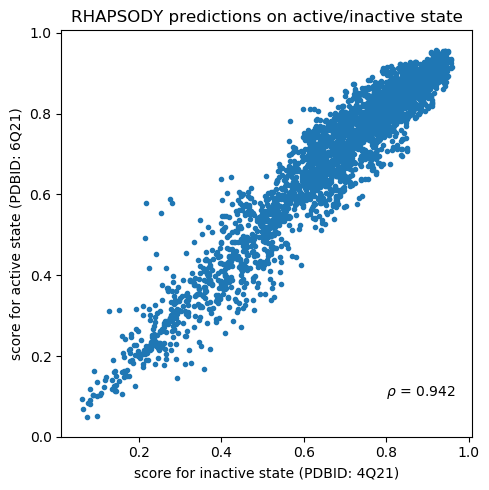

In [27]:
score_inactive = rh.mixPreds['score']
score_active   = rh_2.mixPreds['score']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(score_inactive, score_active, marker='.')
ax.set_xlabel('score for inactive state (PDBID: 4Q21)')
ax.set_ylabel('score for active state (PDBID: 6Q21)')

sel = np.logical_and(~np.isnan(score_inactive), ~np.isnan(score_active))
rho = spearmanr(score_inactive[sel], score_active[sel])[0]

s = r'$\rho$'
ax.set_title('RHAPSODY predictions on active/inactive state')
ax.text(0.8, 0.1, f'{s} = {rho:5.3f}')

fig.tight_layout()
plt.savefig(f'figures/active_vs_inactive_correlation.png', dpi=300)

In general, predictions based on inactive *vs* active conformations are very similar. We can plot the residue-averaged prediction profiles on the respective structure to better highlight differences.

In [44]:
import numpy as np
from prody import *

avg_prob = {}

# inactive conformation
_p = rh.mixPreds['path. probability']
_m = _p.reshape((-1, 19)).T
avg_prob['inactive'] = np.nanmean(_m, axis=0)
# active conformation
_p = rh_2.mixPreds['path. probability']
_m = _p.reshape((-1, 19)).T
avg_prob['active'] = np.nanmean(_m, axis=0)
# difference between inactive and active profiles
avg_prob['difference'] = avg_prob['active'] - avg_prob['inactive']

# residue numbers
resids = rh.SAVcoords['pos'].reshape((-1, 19)).T[0]

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [45]:
# import PDB structures
pdbs = {}
pdbs['inactive']   = parsePDB('4q21', chain='A').select('protein and resid 2 to 166')
pdbs['active']     = parsePDB('6q21', chain='A').select('protein and resid 2 to 166')
pdbs['difference'] = pdbs['active']

@> PDB file is found in the local folder (/home/lponzoni/.../4q21.pdb.gz).
@> 1447 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [46]:
for case in ['inactive', 'active', 'difference']:
    pdb = pdbs[case]
    # replace the B-factor column in chain A with the predictions
    PDBresids = pdb.getResnums()
    new_betas = np.zeros_like(PDBresids, dtype=float)
    for resid, prob in zip(resids, avg_prob[case]):
        if np.isnan(prob):
            prob = 0
        new_betas[PDBresids==int(resid)] = prob
    # write modified PDB
    pdb.setBetas(new_betas)
    f = writePDB(f'figures/mapped_pdb-{case}', pdb)

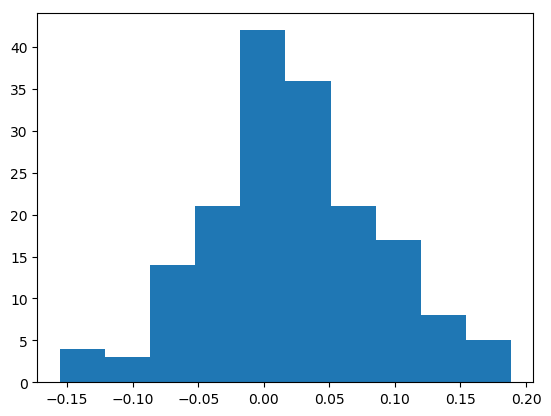

In [47]:
# plot the distribution of difference values
import matplotlib.pyplot as plt

diff = avg_prob['difference']
plt.hist(diff[~np.isnan(diff)]);

## Comparison with experimental results from Bandaru et al.

In [16]:
# import data from file
data = {}

for f in glob.glob('data/*csv'):
    fname = os.path.basename(f, )
    case = fname.replace('.csv', '')
    with open(f, 'r') as _f:
        reader = csv.reader(_f)
        data[case] = list(reader)
        
exp_sequence = ''.join(data['attenuated_RAS'][1])

**NB:** The sequence used in the experiments is a substring of the Uniprot sequence:

In [17]:
from prody import queryUniprot

acc = 'P01112'
sequence = queryUniprot(acc)['sequence   0'].replace('\n', '')

In [18]:
print('Uniprot sequence length:', len(sequence))
print('Exp. sequence length:   ', len(exp_sequence))

Uniprot sequence length: 189
Exp. sequence length:    165


In [19]:
exp_sequence == sequence[1: len(exp_sequence)+1]

True

In [20]:
# convert data to dictionary
tables = {}

for case, d in data.items():
    resids = d[0][1:]
    wt_aas = d[1][1:]
    table = {}
    for line in d[2:]:
        mut_aa = line[0]
        for i, x in enumerate(line[1:]):
            resid = int(resids[i])
            wt_aa = wt_aas[i]
            table[f'P01112 {resid} {wt_aa} {mut_aa}'] = float(x)
    tables[case] = table

In [21]:
# put exp. data in array form and in the same order as Rhapsody predictions
SAV_coords = rh.SAVcoords['text']

exp_scores = {}
for case, table in tables.items():
    a = np.zeros(len(SAV_coords))
    a[:] = np.nan
    for i, SAV in enumerate(SAV_coords):
        if SAV in table:
            a[i] = table[SAV]
    exp_scores[case] = a

# compute residue-averaged functional effects
avg_exp_scores = {}
for case, exp_score in exp_scores.items():
    avg_exp_scores[case] = np.nanmean(exp_score.reshape((-1, 19)), axis=1)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [22]:
# computational scores
rhaps_score_inac = rh.mixPreds['score']
rhaps_score_actv = rh_2.mixPreds['score']
PP2_probs = np.array([float(x) for x in rh.PP2output['pph2_prob']])
EVmut_score = - np.array([float(x) for x in rh.calcEVmutationFeats()['EVmut-DeltaE_epist']])

methods = ['Rhapsody (inactive state)', 'Rhapsody (active state)', 'EVmutation', 'PolyPhen-2']

comput_scores = {
  'Rhapsody (inactive state)': rhaps_score_inac, 
  'Rhapsody (active state)' :  rhaps_score_actv, 
  'EVmutation' :               EVmut_score, 
  'PolyPhen-2' :               PP2_probs
}

# compute residue-averaged computational scores
avg_comput_scores = {}
for method, score in comput_scores.items():
    avg_comput_scores[method] = np.nanmean(score.reshape((-1, 19)), axis=1)

@> Recovering EVmutation data...
@> EVmutation scores recovered in 6.5s.
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


In the following, we compute and plot the correlation between experimental measurements and computational predictions for the functional arrays.

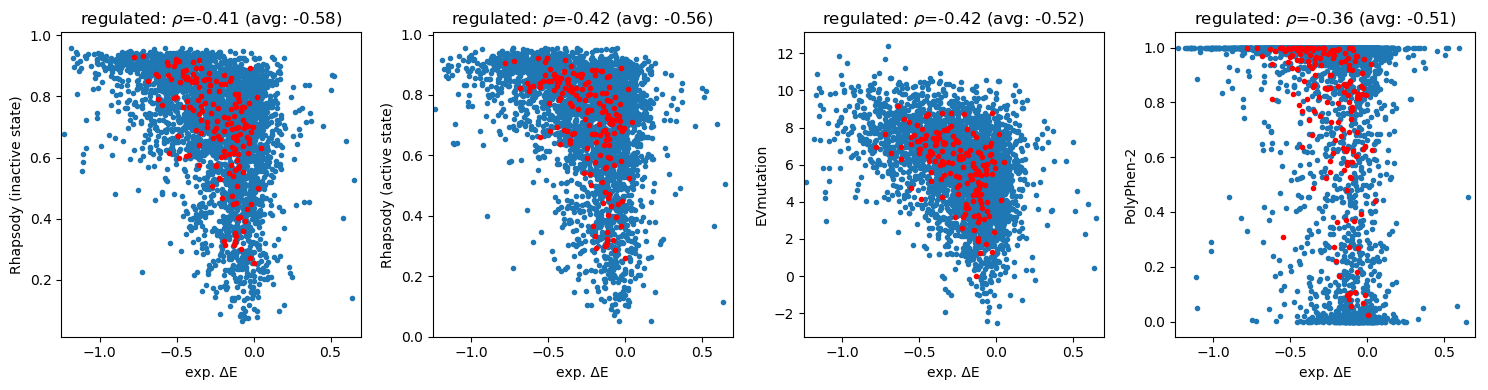

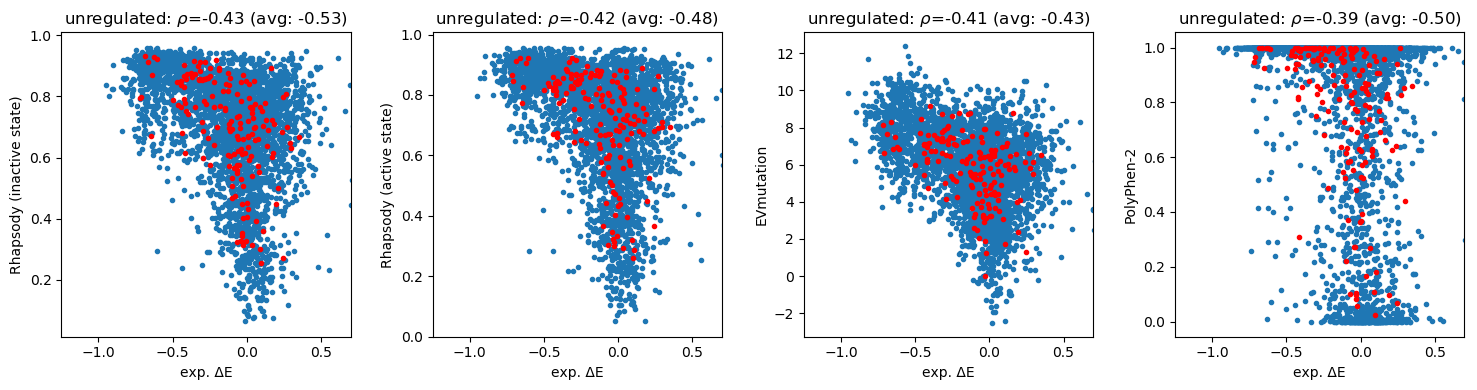

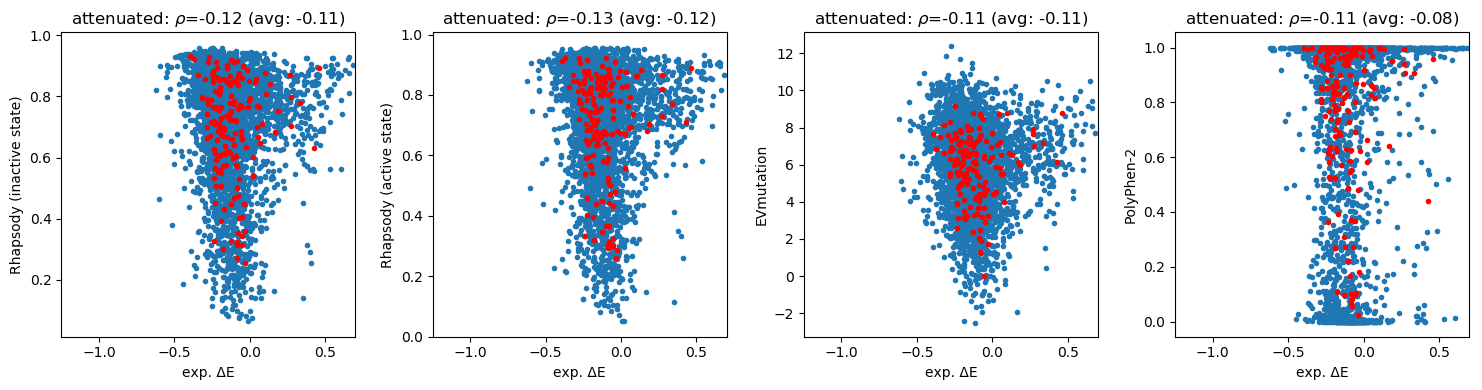

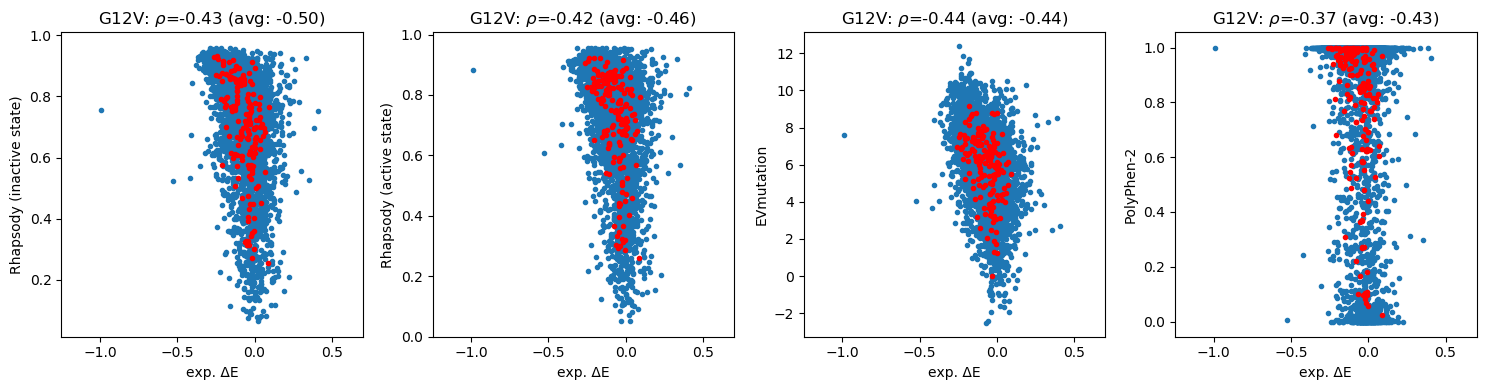

In [28]:
for case in exp_scores:
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]
    
    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        # individual fitness scores
        cs = comput_scores[method]
        ax.scatter(exp_score, cs, marker='.')
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(cs))
        rho = spearmanr(exp_score[sel], cs[sel])[0]
        # residue-averaged fitness scores
        acs = avg_comput_scores[method]
        ax.scatter(avg_exp_score, acs, marker='.', c='r')
        sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(acs))
        rho_av = spearmanr(avg_exp_score[sel], acs[sel])[0]
        # print labels
        ax.set_ylabel(method)
        s = r'$\rho$'
        ax.set_title(f'{case[:-4]}: {s}={rho:5.2f} (avg: {rho_av:5.2f})')
        ax.set_xlim((-1.25, 0.7))
        ax.set_xlabel('exp. ΔE')

    fig.tight_layout()
    plt.savefig(f'figures/correlation-{case}.png', dpi=300)

Since the goal of Rhapsody is to identify mutations that impair the normal activity and interactions of proteins, specifically by taking into account changes to their internal structural dynamics, we can focus on the "regulated" case (its "wild-type" context) among those presented in the paper.
From the plots in the first line, we see that Rhapsody (computed on both inactive and active states) performs in general better than both EVmutation and PolyPhen-2. 

We can also obtain a binary classification from the distribution of functional effects by setting a cutoff according to what is considered a "significant loss of function". We will choose the median as cutoff. This allows us to compute ROC curves and compare performances based on their AUROC.

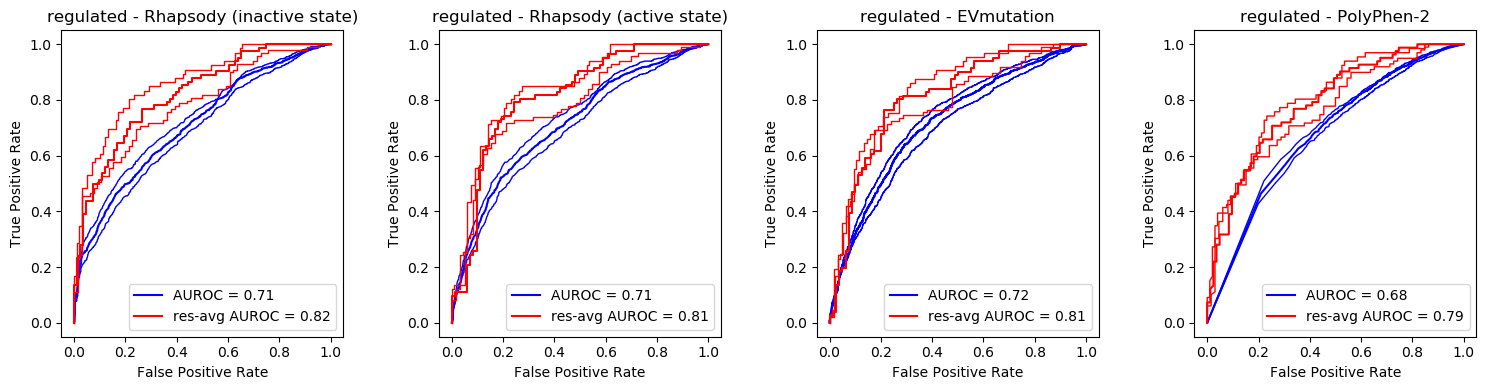

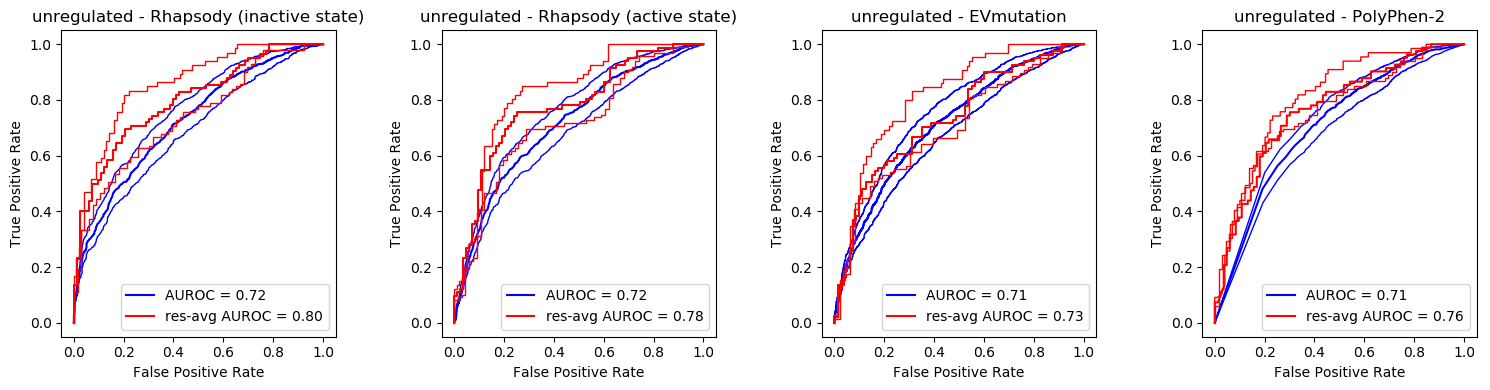

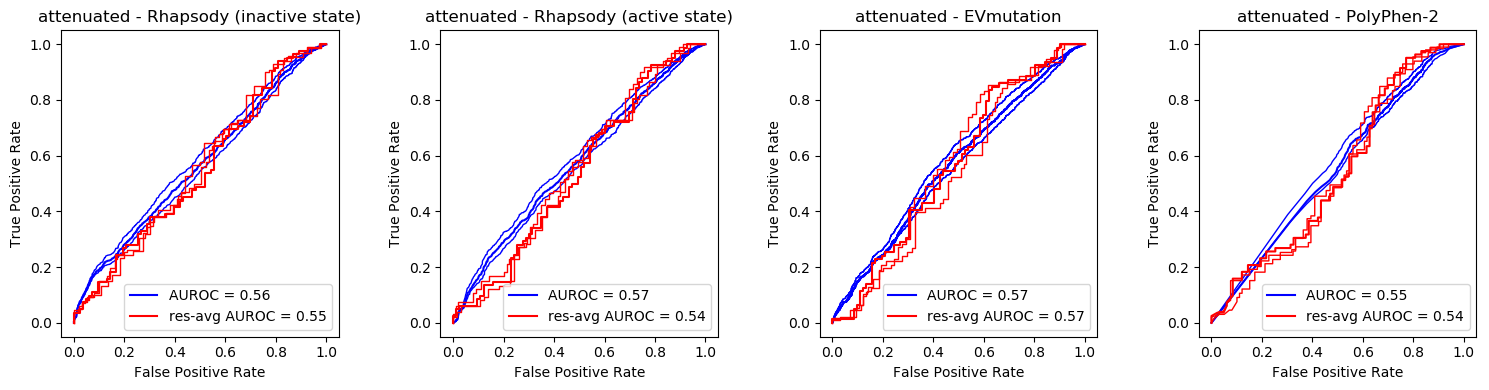

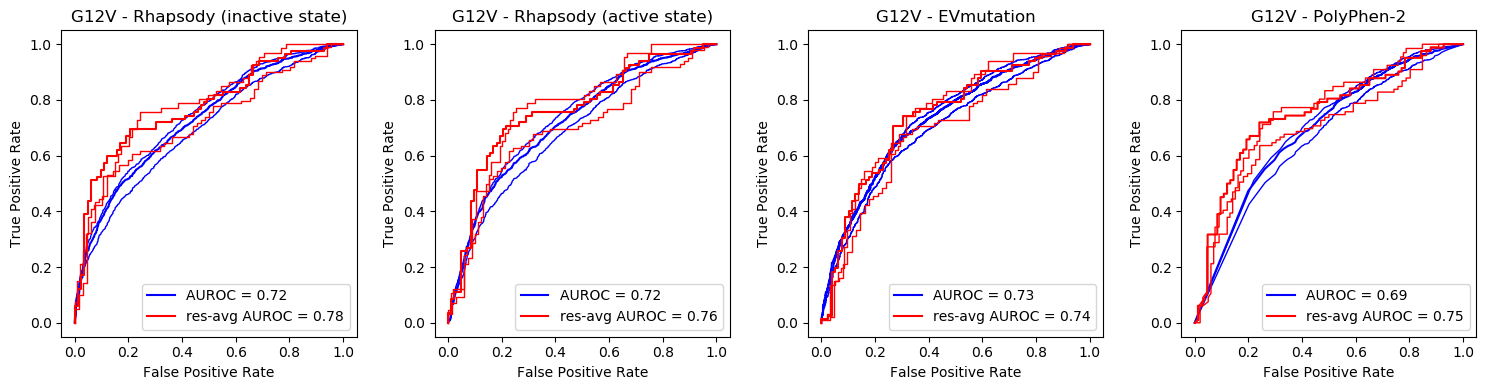

In [29]:
from sklearn.metrics import roc_curve, auc


for case, exp_score in exp_scores.items():
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]
    
    # cutoffs
    cutoffs     = {}
    avg_cutoffs = {}
    for q in [40, 50, 60]:
        cutoffs[q] =     np.nanpercentile(exp_score, q)
        avg_cutoffs[q] = np.nanpercentile(avg_exp_score, q)

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        # individual fitness effects
        cs = comput_scores[method]
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(cs))
        for q, cutoff in cutoffs.items():
            # binary classification
            exp_class = np.where(exp_score[sel] < cutoff, 1, 0)
            # ROC and AUROC
            fpr, tpr, _ = roc_curve(exp_class, cs[sel])
            roc_auc = auc(fpr, tpr)
            # plot
            if q == 50:
                ax.plot(fpr, tpr, 'b-', label=f'AUROC = {roc_auc:4.2f}')
            else:
                ax.plot(fpr, tpr, 'b-', lw=1)
    
        # residue-averaged fitness effects
        acs = avg_comput_scores[method]
        # discard NaN values
        sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(acs))
        for q, avg_cutoff in avg_cutoffs.items():
            # binary classification
            avg_exp_class = np.where(avg_exp_score[sel] < avg_cutoff, 1, 0)
            # ROC and AUROC
            fpr, tpr, _ = roc_curve(avg_exp_class, acs[sel])
            avg_roc_auc = auc(fpr, tpr)
            # plot
            if q == 50:
                ax.plot(fpr, tpr, 'r-', label=f'res-avg AUROC = {avg_roc_auc:4.2f}')
            else:
                ax.plot(fpr, tpr, 'r-', lw=1)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()

    fig.tight_layout()
    plt.savefig(f'figures/ROC-{case}.png', dpi=300)

### *In silico* Saturation mutagenesis tables